In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = True

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : False,
    'huntington'    : True,
    'left'          : False,
    'right'         : True,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'normalized','im':'t1t2','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'connectivity',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_0_1_0_0_0_t1t2_normalized_e_n_e_1_0_e_0_1_connectivity_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1t2_1_42_n_normalized_08_05_06


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(365424, 828)
(365424, 8)
validation
(56968, 828)
(56968, 8)
test
(29712, 828)
(29712, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 1538952 (5.87 MB)


Trainable params: 1538952 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/37 [..............................] - ETA: 45s - loss: 3.1943 - STD: 0.0786 - MAE: 0.2349

 4/37 [==>...........................] - ETA: 0s - loss: 2.2986 - STD: 0.0642 - MAE: 0.2162 

 5/37 [===>..........................] - ETA: 1s - loss: 2.1318 - STD: 0.0791 - MAE: 0.2067

 6/37 [===>..........................] - ETA: 1s - loss: 2.0127 - STD: 0.0967 - MAE: 0.1976

 7/37 [====>.........................] - ETA: 1s - loss: 1.9347 - STD: 0.1135 - MAE: 0.1899

 8/37 [=====>........................] - ETA: 1s - loss: 1.8762 - STD: 0.1282 - MAE: 0.1833

 9/37 [======>.......................] - ETA: 1s - loss: 1.8310 - STD: 0.1405 - MAE: 0.1778

10/37 [=======>......................] - ETA: 1s - loss: 1.7922 - STD: 0.1506 - MAE: 0.1732

11/37 [=======>......................] - ETA: 1s - loss: 1.7589 - STD: 0.1586 - MAE: 0.1694

12/37 [========>.....................] - ETA: 1s - loss: 1.7333 - STD: 0.1648 - MAE: 0.1666

13/37 [=========>....................] - ETA: 1s - loss: 1.7091 - STD: 0.1694 - MAE: 0.1644

14/37 [==========>...................] - ETA: 1s - loss: 1.6892 - STD: 0.1725 - MAE: 0.1629

15/37 [===========>..................] - ETA: 1s - loss: 1.6698 - STD: 0.1745 - MAE: 0.1617

16/37 [===========>..................] - ETA: 1s - loss: 1.6525 - STD: 0.1755 - MAE: 0.1610

17/37 [============>.................] - ETA: 1s - loss: 1.6373 - STD: 0.1758 - MAE: 0.1605

18/37 [=============>................] - ETA: 0s - loss: 1.6241 - STD: 0.1756 - MAE: 0.1603

19/37 [==============>...............] - ETA: 0s - loss: 1.6121 - STD: 0.1752 - MAE: 0.1602

20/37 [===============>..............] - ETA: 0s - loss: 1.6012 - STD: 0.1747 - MAE: 0.1601

21/37 [================>.............] - ETA: 0s - loss: 1.5922 - STD: 0.1743 - MAE: 0.1601

22/37 [================>.............] - ETA: 0s - loss: 1.5842 - STD: 0.1740 - MAE: 0.1601

23/37 [=================>............] - ETA: 0s - loss: 1.5772 - STD: 0.1738 - MAE: 0.1600

24/37 [==================>...........] - ETA: 0s - loss: 1.5703 - STD: 0.1739 - MAE: 0.1599

25/37 [===================>..........] - ETA: 0s - loss: 1.5629 - STD: 0.1741 - MAE: 0.1596

26/37 [====================>.........] - ETA: 0s - loss: 1.5565 - STD: 0.1745 - MAE: 0.1594

27/37 [====================>.........] - ETA: 0s - loss: 1.5493 - STD: 0.1750 - MAE: 0.1590

28/37 [=====================>........] - ETA: 0s - loss: 1.5435 - STD: 0.1757 - MAE: 0.1586

29/37 [======================>.......] - ETA: 0s - loss: 1.5392 - STD: 0.1763 - MAE: 0.1583

30/37 [=======================>......] - ETA: 0s - loss: 1.5340 - STD: 0.1770 - MAE: 0.1580

31/37 [========================>.....] - ETA: 0s - loss: 1.5295 - STD: 0.1777 - MAE: 0.1576

32/37 [========================>.....] - ETA: 0s - loss: 1.5244 - STD: 0.1783 - MAE: 0.1573

33/37 [=========================>....] - ETA: 0s - loss: 1.5202 - STD: 0.1788 - MAE: 0.1570

34/37 [==========================>...] - ETA: 0s - loss: 1.5166 - STD: 0.1792 - MAE: 0.1568

35/37 [===========================>..] - ETA: 0s - loss: 1.5129 - STD: 0.1796 - MAE: 0.1566

36/37 [============================>.] - ETA: 0s - loss: 1.5108 - STD: 0.1798 - MAE: 0.1564

37/37 [==============================] - 5s 91ms/step - loss: 1.5070 - STD: 0.1799 - MAE: 0.1563 - val_loss: 1.4274 - val_STD: 0.1813 - val_MAE: 0.1563


Epoch 2/10000


 1/37 [..............................] - ETA: 3s - loss: 1.3623 - STD: 0.1813 - MAE: 0.1522

 2/37 [>.............................] - ETA: 2s - loss: 1.3699 - STD: 0.1801 - MAE: 0.1531

 3/37 [=>............................] - ETA: 1s - loss: 1.3755 - STD: 0.1790 - MAE: 0.1539

 4/37 [==>...........................] - ETA: 1s - loss: 1.3758 - STD: 0.1781 - MAE: 0.1543

 6/37 [===>..........................] - ETA: 1s - loss: 1.3796 - STD: 0.1770 - MAE: 0.1549

 7/37 [====>.........................] - ETA: 1s - loss: 1.3807 - STD: 0.1767 - MAE: 0.1550

 8/37 [=====>........................] - ETA: 1s - loss: 1.3771 - STD: 0.1766 - MAE: 0.1548

 9/37 [======>.......................] - ETA: 1s - loss: 1.3770 - STD: 0.1767 - MAE: 0.1548

10/37 [=======>......................] - ETA: 1s - loss: 1.3786 - STD: 0.1770 - MAE: 0.1548

11/37 [=======>......................] - ETA: 1s - loss: 1.3768 - STD: 0.1773 - MAE: 0.1545

12/37 [========>.....................] - ETA: 1s - loss: 1.3771 - STD: 0.1778 - MAE: 0.1544

13/37 [=========>....................] - ETA: 1s - loss: 1.3793 - STD: 0.1783 - MAE: 0.1543

14/37 [==========>...................] - ETA: 1s - loss: 1.3803 - STD: 0.1788 - MAE: 0.1542

15/37 [===========>..................] - ETA: 1s - loss: 1.3790 - STD: 0.1792 - MAE: 0.1540

16/37 [===========>..................] - ETA: 1s - loss: 1.3780 - STD: 0.1796 - MAE: 0.1538

17/37 [============>.................] - ETA: 1s - loss: 1.3781 - STD: 0.1799 - MAE: 0.1537

18/37 [=============>................] - ETA: 1s - loss: 1.3774 - STD: 0.1801 - MAE: 0.1536

19/37 [==============>...............] - ETA: 1s - loss: 1.3777 - STD: 0.1803 - MAE: 0.1535

20/37 [===============>..............] - ETA: 0s - loss: 1.3777 - STD: 0.1803 - MAE: 0.1535

21/37 [================>.............] - ETA: 0s - loss: 1.3776 - STD: 0.1804 - MAE: 0.1535

22/37 [================>.............] - ETA: 0s - loss: 1.3778 - STD: 0.1804 - MAE: 0.1535

23/37 [=================>............] - ETA: 0s - loss: 1.3776 - STD: 0.1803 - MAE: 0.1535

24/37 [==================>...........] - ETA: 0s - loss: 1.3782 - STD: 0.1803 - MAE: 0.1536

25/37 [===================>..........] - ETA: 0s - loss: 1.3775 - STD: 0.1802 - MAE: 0.1536

26/37 [====================>.........] - ETA: 0s - loss: 1.3769 - STD: 0.1801 - MAE: 0.1536

27/37 [====================>.........] - ETA: 0s - loss: 1.3767 - STD: 0.1801 - MAE: 0.1536

28/37 [=====================>........] - ETA: 0s - loss: 1.3763 - STD: 0.1801 - MAE: 0.1535

29/37 [======================>.......] - ETA: 0s - loss: 1.3770 - STD: 0.1801 - MAE: 0.1536

30/37 [=======================>......] - ETA: 0s - loss: 1.3770 - STD: 0.1802 - MAE: 0.1535

31/37 [========================>.....] - ETA: 0s - loss: 1.3768 - STD: 0.1803 - MAE: 0.1535

32/37 [========================>.....] - ETA: 0s - loss: 1.3768 - STD: 0.1804 - MAE: 0.1535

33/37 [=========================>....] - ETA: 0s - loss: 1.3770 - STD: 0.1805 - MAE: 0.1534

34/37 [==========================>...] - ETA: 0s - loss: 1.3772 - STD: 0.1806 - MAE: 0.1534

35/37 [===========================>..] - ETA: 0s - loss: 1.3777 - STD: 0.1807 - MAE: 0.1534

36/37 [============================>.] - ETA: 0s - loss: 1.3776 - STD: 0.1807 - MAE: 0.1534

37/37 [==============================] - ETA: 0s - loss: 1.3775 - STD: 0.1807 - MAE: 0.1534

37/37 [==============================] - 2s 63ms/step - loss: 1.3775 - STD: 0.1807 - MAE: 0.1534 - val_loss: 1.4138 - val_STD: 0.1808 - val_MAE: 0.1564


Epoch 3/10000


 1/37 [..............................] - ETA: 3s - loss: 1.3839 - STD: 0.1808 - MAE: 0.1534

 2/37 [>.............................] - ETA: 2s - loss: 1.3794 - STD: 0.1804 - MAE: 0.1535

 3/37 [=>............................] - ETA: 2s - loss: 1.3779 - STD: 0.1801 - MAE: 0.1537

 4/37 [==>...........................] - ETA: 1s - loss: 1.3770 - STD: 0.1798 - MAE: 0.1537

 5/37 [===>..........................] - ETA: 1s - loss: 1.3782 - STD: 0.1796 - MAE: 0.1538

 6/37 [===>..........................] - ETA: 1s - loss: 1.3756 - STD: 0.1794 - MAE: 0.1538

 7/37 [====>.........................] - ETA: 1s - loss: 1.3781 - STD: 0.1793 - MAE: 0.1539

 8/37 [=====>........................] - ETA: 1s - loss: 1.3783 - STD: 0.1793 - MAE: 0.1540

 9/37 [======>.......................] - ETA: 1s - loss: 1.3777 - STD: 0.1793 - MAE: 0.1539

10/37 [=======>......................] - ETA: 1s - loss: 1.3763 - STD: 0.1793 - MAE: 0.1538

11/37 [=======>......................] - ETA: 1s - loss: 1.3768 - STD: 0.1794 - MAE: 0.1538

12/37 [========>.....................] - ETA: 1s - loss: 1.3757 - STD: 0.1795 - MAE: 0.1537

13/37 [=========>....................] - ETA: 1s - loss: 1.3762 - STD: 0.1797 - MAE: 0.1537

14/37 [==========>...................] - ETA: 1s - loss: 1.3765 - STD: 0.1799 - MAE: 0.1537

15/37 [===========>..................] - ETA: 1s - loss: 1.3749 - STD: 0.1800 - MAE: 0.1535

17/37 [============>.................] - ETA: 1s - loss: 1.3743 - STD: 0.1803 - MAE: 0.1534

18/37 [=============>................] - ETA: 1s - loss: 1.3734 - STD: 0.1804 - MAE: 0.1533

19/37 [==============>...............] - ETA: 1s - loss: 1.3736 - STD: 0.1805 - MAE: 0.1533

20/37 [===============>..............] - ETA: 0s - loss: 1.3738 - STD: 0.1806 - MAE: 0.1533

21/37 [================>.............] - ETA: 0s - loss: 1.3742 - STD: 0.1807 - MAE: 0.1532

22/37 [================>.............] - ETA: 0s - loss: 1.3738 - STD: 0.1808 - MAE: 0.1532

23/37 [=================>............] - ETA: 0s - loss: 1.3740 - STD: 0.1808 - MAE: 0.1532

24/37 [==================>...........] - ETA: 0s - loss: 1.3740 - STD: 0.1808 - MAE: 0.1532

25/37 [===================>..........] - ETA: 0s - loss: 1.3748 - STD: 0.1808 - MAE: 0.1532

26/37 [====================>.........] - ETA: 0s - loss: 1.3752 - STD: 0.1808 - MAE: 0.1533

27/37 [====================>.........] - ETA: 0s - loss: 1.3753 - STD: 0.1808 - MAE: 0.1533

28/37 [=====================>........] - ETA: 0s - loss: 1.3756 - STD: 0.1807 - MAE: 0.1533

29/37 [======================>.......] - ETA: 0s - loss: 1.3756 - STD: 0.1806 - MAE: 0.1533

30/37 [=======================>......] - ETA: 0s - loss: 1.3755 - STD: 0.1806 - MAE: 0.1534

31/37 [========================>.....] - ETA: 0s - loss: 1.3750 - STD: 0.1806 - MAE: 0.1534

32/37 [========================>.....] - ETA: 0s - loss: 1.3752 - STD: 0.1805 - MAE: 0.1534

33/37 [=========================>....] - ETA: 0s - loss: 1.3754 - STD: 0.1806 - MAE: 0.1534

34/37 [==========================>...] - ETA: 0s - loss: 1.3759 - STD: 0.1806 - MAE: 0.1534

35/37 [===========================>..] - ETA: 0s - loss: 1.3755 - STD: 0.1806 - MAE: 0.1533

36/37 [============================>.] - ETA: 0s - loss: 1.3757 - STD: 0.1807 - MAE: 0.1533

37/37 [==============================] - ETA: 0s - loss: 1.3761 - STD: 0.1807 - MAE: 0.1533

37/37 [==============================] - 2s 62ms/step - loss: 1.3761 - STD: 0.1807 - MAE: 0.1533 - val_loss: 1.4149 - val_STD: 0.1822 - val_MAE: 0.1559


Epoch 4/10000


 1/37 [..............................] - ETA: 3s - loss: 1.3879 - STD: 0.1822 - MAE: 0.1535

 2/37 [>.............................] - ETA: 2s - loss: 1.3902 - STD: 0.1819 - MAE: 0.1537

 4/37 [==>...........................] - ETA: 1s - loss: 1.3841 - STD: 0.1810 - MAE: 0.1536

 5/37 [===>..........................] - ETA: 1s - loss: 1.3843 - STD: 0.1807 - MAE: 0.1537

 6/37 [===>..........................] - ETA: 1s - loss: 1.3837 - STD: 0.1803 - MAE: 0.1538

 7/37 [====>.........................] - ETA: 1s - loss: 1.3821 - STD: 0.1801 - MAE: 0.1538

 8/37 [=====>........................] - ETA: 1s - loss: 1.3809 - STD: 0.1799 - MAE: 0.1538

 9/37 [======>.......................] - ETA: 1s - loss: 1.3816 - STD: 0.1798 - MAE: 0.1539

10/37 [=======>......................] - ETA: 1s - loss: 1.3811 - STD: 0.1798 - MAE: 0.1539

11/37 [=======>......................] - ETA: 1s - loss: 1.3784 - STD: 0.1798 - MAE: 0.1538

12/37 [========>.....................] - ETA: 1s - loss: 1.3787 - STD: 0.1799 - MAE: 0.1538

13/37 [=========>....................] - ETA: 1s - loss: 1.3785 - STD: 0.1800 - MAE: 0.1537

14/37 [==========>...................] - ETA: 1s - loss: 1.3794 - STD: 0.1802 - MAE: 0.1537

15/37 [===========>..................] - ETA: 1s - loss: 1.3785 - STD: 0.1803 - MAE: 0.1536

16/37 [===========>..................] - ETA: 1s - loss: 1.3792 - STD: 0.1804 - MAE: 0.1536

17/37 [============>.................] - ETA: 1s - loss: 1.3790 - STD: 0.1804 - MAE: 0.1536

18/37 [=============>................] - ETA: 1s - loss: 1.3783 - STD: 0.1805 - MAE: 0.1535

19/37 [==============>...............] - ETA: 1s - loss: 1.3778 - STD: 0.1805 - MAE: 0.1535

20/37 [===============>..............] - ETA: 0s - loss: 1.3781 - STD: 0.1805 - MAE: 0.1535

21/37 [================>.............] - ETA: 0s - loss: 1.3773 - STD: 0.1805 - MAE: 0.1535

22/37 [================>.............] - ETA: 0s - loss: 1.3776 - STD: 0.1806 - MAE: 0.1535

23/37 [=================>............] - ETA: 0s - loss: 1.3768 - STD: 0.1806 - MAE: 0.1534

24/37 [==================>...........] - ETA: 0s - loss: 1.3769 - STD: 0.1806 - MAE: 0.1534

25/37 [===================>..........] - ETA: 0s - loss: 1.3766 - STD: 0.1807 - MAE: 0.1534

26/37 [====================>.........] - ETA: 0s - loss: 1.3772 - STD: 0.1807 - MAE: 0.1534

27/37 [====================>.........] - ETA: 0s - loss: 1.3779 - STD: 0.1807 - MAE: 0.1534

28/37 [=====================>........] - ETA: 0s - loss: 1.3773 - STD: 0.1807 - MAE: 0.1534

29/37 [======================>.......] - ETA: 0s - loss: 1.3772 - STD: 0.1807 - MAE: 0.1534

30/37 [=======================>......] - ETA: 0s - loss: 1.3771 - STD: 0.1807 - MAE: 0.1534

31/37 [========================>.....] - ETA: 0s - loss: 1.3770 - STD: 0.1807 - MAE: 0.1534

32/37 [========================>.....] - ETA: 0s - loss: 1.3770 - STD: 0.1806 - MAE: 0.1534

33/37 [=========================>....] - ETA: 0s - loss: 1.3768 - STD: 0.1806 - MAE: 0.1534

34/37 [==========================>...] - ETA: 0s - loss: 1.3763 - STD: 0.1806 - MAE: 0.1534

35/37 [===========================>..] - ETA: 0s - loss: 1.3761 - STD: 0.1806 - MAE: 0.1534

36/37 [============================>.] - ETA: 0s - loss: 1.3757 - STD: 0.1807 - MAE: 0.1533

37/37 [==============================] - ETA: 0s - loss: 1.3758 - STD: 0.1808 - MAE: 0.1533

37/37 [==============================] - 2s 62ms/step - loss: 1.3758 - STD: 0.1808 - MAE: 0.1533 - val_loss: 1.4146 - val_STD: 0.1838 - val_MAE: 0.1553


Epoch 5/10000


 1/37 [..............................] - ETA: 3s - loss: 1.3546 - STD: 0.1839 - MAE: 0.1513

 2/37 [>.............................] - ETA: 2s - loss: 1.3715 - STD: 0.1839 - MAE: 0.1521

 3/37 [=>............................] - ETA: 2s - loss: 1.3720 - STD: 0.1838 - MAE: 0.1522

 5/37 [===>..........................] - ETA: 1s - loss: 1.3713 - STD: 0.1831 - MAE: 0.1523

 6/37 [===>..........................] - ETA: 1s - loss: 1.3728 - STD: 0.1827 - MAE: 0.1525

 7/37 [====>.........................] - ETA: 1s - loss: 1.3765 - STD: 0.1823 - MAE: 0.1528

 8/37 [=====>........................] - ETA: 1s - loss: 1.3743 - STD: 0.1819 - MAE: 0.1528

 9/37 [======>.......................] - ETA: 1s - loss: 1.3763 - STD: 0.1816 - MAE: 0.1530

10/37 [=======>......................] - ETA: 1s - loss: 1.3749 - STD: 0.1813 - MAE: 0.1531

11/37 [=======>......................] - ETA: 1s - loss: 1.3763 - STD: 0.1812 - MAE: 0.1532

12/37 [========>.....................] - ETA: 1s - loss: 1.3771 - STD: 0.1810 - MAE: 0.1533

13/37 [=========>....................] - ETA: 1s - loss: 1.3753 - STD: 0.1810 - MAE: 0.1532

14/37 [==========>...................] - ETA: 1s - loss: 1.3750 - STD: 0.1809 - MAE: 0.1532

15/37 [===========>..................] - ETA: 1s - loss: 1.3742 - STD: 0.1810 - MAE: 0.1531

16/37 [===========>..................] - ETA: 1s - loss: 1.3754 - STD: 0.1811 - MAE: 0.1531

17/37 [============>.................] - ETA: 1s - loss: 1.3750 - STD: 0.1812 - MAE: 0.1531

18/37 [=============>................] - ETA: 1s - loss: 1.3752 - STD: 0.1813 - MAE: 0.1530

19/37 [==============>...............] - ETA: 1s - loss: 1.3745 - STD: 0.1814 - MAE: 0.1529

20/37 [===============>..............] - ETA: 0s - loss: 1.3739 - STD: 0.1815 - MAE: 0.1529

21/37 [================>.............] - ETA: 0s - loss: 1.3741 - STD: 0.1815 - MAE: 0.1529

22/37 [================>.............] - ETA: 0s - loss: 1.3748 - STD: 0.1815 - MAE: 0.1529

23/37 [=================>............] - ETA: 0s - loss: 1.3738 - STD: 0.1815 - MAE: 0.1529

24/37 [==================>...........] - ETA: 0s - loss: 1.3741 - STD: 0.1815 - MAE: 0.1529

25/37 [===================>..........] - ETA: 0s - loss: 1.3739 - STD: 0.1814 - MAE: 0.1529

26/37 [====================>.........] - ETA: 0s - loss: 1.3745 - STD: 0.1813 - MAE: 0.1530

27/37 [====================>.........] - ETA: 0s - loss: 1.3738 - STD: 0.1812 - MAE: 0.1530

28/37 [=====================>........] - ETA: 0s - loss: 1.3740 - STD: 0.1811 - MAE: 0.1530

29/37 [======================>.......] - ETA: 0s - loss: 1.3729 - STD: 0.1810 - MAE: 0.1530

30/37 [=======================>......] - ETA: 0s - loss: 1.3732 - STD: 0.1810 - MAE: 0.1530

31/37 [========================>.....] - ETA: 0s - loss: 1.3740 - STD: 0.1810 - MAE: 0.1531

32/37 [========================>.....] - ETA: 0s - loss: 1.3738 - STD: 0.1810 - MAE: 0.1530

33/37 [=========================>....] - ETA: 0s - loss: 1.3733 - STD: 0.1810 - MAE: 0.1530

34/37 [==========================>...] - ETA: 0s - loss: 1.3728 - STD: 0.1810 - MAE: 0.1530

35/37 [===========================>..] - ETA: 0s - loss: 1.3732 - STD: 0.1810 - MAE: 0.1530

36/37 [============================>.] - ETA: 0s - loss: 1.3725 - STD: 0.1810 - MAE: 0.1530

37/37 [==============================] - ETA: 0s - loss: 1.3728 - STD: 0.1810 - MAE: 0.1530

37/37 [==============================] - 2s 62ms/step - loss: 1.3728 - STD: 0.1810 - MAE: 0.1530 - val_loss: 1.4042 - val_STD: 0.1799 - val_MAE: 0.1560


Epoch 6/10000


 1/37 [..............................] - ETA: 3s - loss: 1.3769 - STD: 0.1806 - MAE: 0.1536

 2/37 [>.............................] - ETA: 2s - loss: 1.3575 - STD: 0.1801 - MAE: 0.1525

 3/37 [=>............................] - ETA: 2s - loss: 1.3610 - STD: 0.1800 - MAE: 0.1527

 4/37 [==>...........................] - ETA: 2s - loss: 1.3626 - STD: 0.1799 - MAE: 0.1528

 5/37 [===>..........................] - ETA: 1s - loss: 1.3614 - STD: 0.1799 - MAE: 0.1528

 6/37 [===>..........................] - ETA: 1s - loss: 1.3629 - STD: 0.1799 - MAE: 0.1528

 7/37 [====>.........................] - ETA: 1s - loss: 1.3596 - STD: 0.1800 - MAE: 0.1526

 8/37 [=====>........................] - ETA: 1s - loss: 1.3584 - STD: 0.1802 - MAE: 0.1525

 9/37 [======>.......................] - ETA: 1s - loss: 1.3583 - STD: 0.1804 - MAE: 0.1523

10/37 [=======>......................] - ETA: 1s - loss: 1.3586 - STD: 0.1807 - MAE: 0.1522

11/37 [=======>......................] - ETA: 1s - loss: 1.3588 - STD: 0.1810 - MAE: 0.1521

12/37 [========>.....................] - ETA: 1s - loss: 1.3580 - STD: 0.1810 - MAE: 0.1520

13/37 [=========>....................] - ETA: 1s - loss: 1.3593 - STD: 0.1811 - MAE: 0.1521

14/37 [==========>...................] - ETA: 1s - loss: 1.3582 - STD: 0.1810 - MAE: 0.1520

15/37 [===========>..................] - ETA: 1s - loss: 1.3584 - STD: 0.1810 - MAE: 0.1521

16/37 [===========>..................] - ETA: 1s - loss: 1.3582 - STD: 0.1809 - MAE: 0.1521

17/37 [============>.................] - ETA: 1s - loss: 1.3583 - STD: 0.1809 - MAE: 0.1521

18/37 [=============>................] - ETA: 1s - loss: 1.3581 - STD: 0.1809 - MAE: 0.1521

19/37 [==============>...............] - ETA: 1s - loss: 1.3582 - STD: 0.1808 - MAE: 0.1521

21/37 [================>.............] - ETA: 0s - loss: 1.3572 - STD: 0.1806 - MAE: 0.1521

22/37 [================>.............] - ETA: 0s - loss: 1.3560 - STD: 0.1805 - MAE: 0.1520

23/37 [=================>............] - ETA: 0s - loss: 1.3550 - STD: 0.1807 - MAE: 0.1519

24/37 [==================>...........] - ETA: 0s - loss: 1.3545 - STD: 0.1809 - MAE: 0.1518

25/37 [===================>..........] - ETA: 0s - loss: 1.3533 - STD: 0.1810 - MAE: 0.1517

26/37 [====================>.........] - ETA: 0s - loss: 1.3529 - STD: 0.1811 - MAE: 0.1516

27/37 [====================>.........] - ETA: 0s - loss: 1.3518 - STD: 0.1811 - MAE: 0.1515

28/37 [=====================>........] - ETA: 0s - loss: 1.3516 - STD: 0.1813 - MAE: 0.1515

29/37 [======================>.......] - ETA: 0s - loss: 1.3506 - STD: 0.1815 - MAE: 0.1513

30/37 [=======================>......] - ETA: 0s - loss: 1.3500 - STD: 0.1816 - MAE: 0.1512

31/37 [========================>.....] - ETA: 0s - loss: 1.3495 - STD: 0.1817 - MAE: 0.1512

32/37 [========================>.....] - ETA: 0s - loss: 1.3486 - STD: 0.1817 - MAE: 0.1511

33/37 [=========================>....] - ETA: 0s - loss: 1.3481 - STD: 0.1816 - MAE: 0.1511

34/37 [==========================>...] - ETA: 0s - loss: 1.3476 - STD: 0.1817 - MAE: 0.1511

35/37 [===========================>..] - ETA: 0s - loss: 1.3471 - STD: 0.1818 - MAE: 0.1510

36/37 [============================>.] - ETA: 0s - loss: 1.3458 - STD: 0.1819 - MAE: 0.1509

37/37 [==============================] - ETA: 0s - loss: 1.3452 - STD: 0.1820 - MAE: 0.1508

37/37 [==============================] - 2s 62ms/step - loss: 1.3452 - STD: 0.1820 - MAE: 0.1508 - val_loss: 1.3418 - val_STD: 0.1768 - val_MAE: 0.1525


Epoch 7/10000


 1/37 [..............................] - ETA: 3s - loss: 1.3256 - STD: 0.1826 - MAE: 0.1494

 2/37 [>.............................] - ETA: 2s - loss: 1.3111 - STD: 0.1844 - MAE: 0.1479

 3/37 [=>............................] - ETA: 2s - loss: 1.3091 - STD: 0.1867 - MAE: 0.1469

 4/37 [==>...........................] - ETA: 1s - loss: 1.3110 - STD: 0.1884 - MAE: 0.1464

 5/37 [===>..........................] - ETA: 1s - loss: 1.3120 - STD: 0.1879 - MAE: 0.1466

 6/37 [===>..........................] - ETA: 1s - loss: 1.3132 - STD: 0.1870 - MAE: 0.1470

 7/37 [====>.........................] - ETA: 1s - loss: 1.3141 - STD: 0.1866 - MAE: 0.1472

 8/37 [=====>........................] - ETA: 1s - loss: 1.3156 - STD: 0.1873 - MAE: 0.1470

 9/37 [======>.......................] - ETA: 1s - loss: 1.3157 - STD: 0.1881 - MAE: 0.1467

10/37 [=======>......................] - ETA: 1s - loss: 1.3135 - STD: 0.1884 - MAE: 0.1464

11/37 [=======>......................] - ETA: 1s - loss: 1.3127 - STD: 0.1880 - MAE: 0.1465

12/37 [========>.....................] - ETA: 1s - loss: 1.3113 - STD: 0.1879 - MAE: 0.1465

13/37 [=========>....................] - ETA: 1s - loss: 1.3102 - STD: 0.1882 - MAE: 0.1463

14/37 [==========>...................] - ETA: 1s - loss: 1.3098 - STD: 0.1886 - MAE: 0.1462

15/37 [===========>..................] - ETA: 1s - loss: 1.3108 - STD: 0.1886 - MAE: 0.1462

16/37 [===========>..................] - ETA: 1s - loss: 1.3107 - STD: 0.1882 - MAE: 0.1463

17/37 [============>.................] - ETA: 1s - loss: 1.3104 - STD: 0.1882 - MAE: 0.1464

19/37 [==============>...............] - ETA: 1s - loss: 1.3085 - STD: 0.1888 - MAE: 0.1460

20/37 [===============>..............] - ETA: 0s - loss: 1.3085 - STD: 0.1890 - MAE: 0.1460

21/37 [================>.............] - ETA: 0s - loss: 1.3087 - STD: 0.1888 - MAE: 0.1460

22/37 [================>.............] - ETA: 0s - loss: 1.3082 - STD: 0.1885 - MAE: 0.1461

23/37 [=================>............] - ETA: 0s - loss: 1.3074 - STD: 0.1886 - MAE: 0.1460

24/37 [==================>...........] - ETA: 0s - loss: 1.3074 - STD: 0.1891 - MAE: 0.1459

25/37 [===================>..........] - ETA: 0s - loss: 1.3070 - STD: 0.1892 - MAE: 0.1458

26/37 [====================>.........] - ETA: 0s - loss: 1.3067 - STD: 0.1890 - MAE: 0.1458

27/37 [====================>.........] - ETA: 0s - loss: 1.3068 - STD: 0.1891 - MAE: 0.1458

28/37 [=====================>........] - ETA: 0s - loss: 1.3059 - STD: 0.1893 - MAE: 0.1457

29/37 [======================>.......] - ETA: 0s - loss: 1.3060 - STD: 0.1894 - MAE: 0.1457

30/37 [=======================>......] - ETA: 0s - loss: 1.3056 - STD: 0.1892 - MAE: 0.1457

31/37 [========================>.....] - ETA: 0s - loss: 1.3052 - STD: 0.1892 - MAE: 0.1457

32/37 [========================>.....] - ETA: 0s - loss: 1.3048 - STD: 0.1894 - MAE: 0.1456

33/37 [=========================>....] - ETA: 0s - loss: 1.3045 - STD: 0.1893 - MAE: 0.1456

34/37 [==========================>...] - ETA: 0s - loss: 1.3038 - STD: 0.1893 - MAE: 0.1456

35/37 [===========================>..] - ETA: 0s - loss: 1.3035 - STD: 0.1894 - MAE: 0.1455

36/37 [============================>.] - ETA: 0s - loss: 1.3028 - STD: 0.1895 - MAE: 0.1455

37/37 [==============================] - ETA: 0s - loss: 1.3021 - STD: 0.1896 - MAE: 0.1454

37/37 [==============================] - 2s 63ms/step - loss: 1.3021 - STD: 0.1896 - MAE: 0.1454 - val_loss: 1.2982 - val_STD: 0.1874 - val_MAE: 0.1458


Epoch 8/10000


 1/37 [..............................] - ETA: 3s - loss: 1.2936 - STD: 0.1969 - MAE: 0.1420

 2/37 [>.............................] - ETA: 1s - loss: 1.2927 - STD: 0.1929 - MAE: 0.1436

 3/37 [=>............................] - ETA: 1s - loss: 1.2941 - STD: 0.1914 - MAE: 0.1443

 4/37 [==>...........................] - ETA: 1s - loss: 1.2921 - STD: 0.1926 - MAE: 0.1438

 5/37 [===>..........................] - ETA: 1s - loss: 1.2911 - STD: 0.1920 - MAE: 0.1439

 6/37 [===>..........................] - ETA: 1s - loss: 1.2910 - STD: 0.1916 - MAE: 0.1440

 7/37 [====>.........................] - ETA: 1s - loss: 1.2893 - STD: 0.1916 - MAE: 0.1440

 8/37 [=====>........................] - ETA: 1s - loss: 1.2850 - STD: 0.1916 - MAE: 0.1438

 9/37 [======>.......................] - ETA: 1s - loss: 1.2844 - STD: 0.1928 - MAE: 0.1433

10/37 [=======>......................] - ETA: 1s - loss: 1.2849 - STD: 0.1922 - MAE: 0.1435

11/37 [=======>......................] - ETA: 1s - loss: 1.2825 - STD: 0.1918 - MAE: 0.1435

12/37 [========>.....................] - ETA: 1s - loss: 1.2835 - STD: 0.1935 - MAE: 0.1429

13/37 [=========>....................] - ETA: 1s - loss: 1.2811 - STD: 0.1925 - MAE: 0.1432

14/37 [==========>...................] - ETA: 1s - loss: 1.2817 - STD: 0.1919 - MAE: 0.1434

15/37 [===========>..................] - ETA: 1s - loss: 1.2818 - STD: 0.1926 - MAE: 0.1431

16/37 [===========>..................] - ETA: 1s - loss: 1.2810 - STD: 0.1930 - MAE: 0.1430

17/37 [============>.................] - ETA: 1s - loss: 1.2817 - STD: 0.1925 - MAE: 0.1432

18/37 [=============>................] - ETA: 1s - loss: 1.2812 - STD: 0.1921 - MAE: 0.1434

19/37 [==============>...............] - ETA: 1s - loss: 1.2806 - STD: 0.1928 - MAE: 0.1430

20/37 [===============>..............] - ETA: 1s - loss: 1.2813 - STD: 0.1932 - MAE: 0.1429

21/37 [================>.............] - ETA: 0s - loss: 1.2809 - STD: 0.1926 - MAE: 0.1431

22/37 [================>.............] - ETA: 0s - loss: 1.2799 - STD: 0.1923 - MAE: 0.1432

24/37 [==================>...........] - ETA: 0s - loss: 1.2796 - STD: 0.1934 - MAE: 0.1427

25/37 [===================>..........] - ETA: 0s - loss: 1.2791 - STD: 0.1929 - MAE: 0.1429

26/37 [====================>.........] - ETA: 0s - loss: 1.2789 - STD: 0.1928 - MAE: 0.1429

27/37 [====================>.........] - ETA: 0s - loss: 1.2786 - STD: 0.1932 - MAE: 0.1428

28/37 [=====================>........] - ETA: 0s - loss: 1.2783 - STD: 0.1934 - MAE: 0.1427

29/37 [======================>.......] - ETA: 0s - loss: 1.2773 - STD: 0.1930 - MAE: 0.1428

30/37 [=======================>......] - ETA: 0s - loss: 1.2762 - STD: 0.1929 - MAE: 0.1428

31/37 [========================>.....] - ETA: 0s - loss: 1.2761 - STD: 0.1933 - MAE: 0.1426

32/37 [========================>.....] - ETA: 0s - loss: 1.2755 - STD: 0.1934 - MAE: 0.1426

33/37 [=========================>....] - ETA: 0s - loss: 1.2754 - STD: 0.1932 - MAE: 0.1426

34/37 [==========================>...] - ETA: 0s - loss: 1.2751 - STD: 0.1932 - MAE: 0.1426

35/37 [===========================>..] - ETA: 0s - loss: 1.2745 - STD: 0.1934 - MAE: 0.1425

36/37 [============================>.] - ETA: 0s - loss: 1.2743 - STD: 0.1935 - MAE: 0.1425

37/37 [==============================] - ETA: 0s - loss: 1.2737 - STD: 0.1933 - MAE: 0.1425

37/37 [==============================] - 2s 62ms/step - loss: 1.2737 - STD: 0.1933 - MAE: 0.1425 - val_loss: 1.2796 - val_STD: 0.1872 - val_MAE: 0.1453


Epoch 9/10000


 1/37 [..............................] - ETA: 3s - loss: 1.2473 - STD: 0.1938 - MAE: 0.1411

 2/37 [>.............................] - ETA: 2s - loss: 1.2656 - STD: 0.2005 - MAE: 0.1397

 3/37 [=>............................] - ETA: 2s - loss: 1.2620 - STD: 0.1973 - MAE: 0.1407

 4/37 [==>...........................] - ETA: 1s - loss: 1.2591 - STD: 0.1940 - MAE: 0.1418

 5/37 [===>..........................] - ETA: 1s - loss: 1.2560 - STD: 0.1956 - MAE: 0.1411

 6/37 [===>..........................] - ETA: 1s - loss: 1.2599 - STD: 0.1972 - MAE: 0.1407

 7/37 [====>.........................] - ETA: 1s - loss: 1.2603 - STD: 0.1952 - MAE: 0.1414

 8/37 [=====>........................] - ETA: 1s - loss: 1.2607 - STD: 0.1938 - MAE: 0.1420

 9/37 [======>.......................] - ETA: 1s - loss: 1.2585 - STD: 0.1947 - MAE: 0.1415

11/37 [=======>......................] - ETA: 1s - loss: 1.2578 - STD: 0.1956 - MAE: 0.1411

12/37 [========>.....................] - ETA: 1s - loss: 1.2570 - STD: 0.1950 - MAE: 0.1413

13/37 [=========>....................] - ETA: 1s - loss: 1.2555 - STD: 0.1955 - MAE: 0.1410

14/37 [==========>...................] - ETA: 1s - loss: 1.2560 - STD: 0.1963 - MAE: 0.1408

15/37 [===========>..................] - ETA: 1s - loss: 1.2536 - STD: 0.1958 - MAE: 0.1409

16/37 [===========>..................] - ETA: 1s - loss: 1.2521 - STD: 0.1952 - MAE: 0.1410

17/37 [============>.................] - ETA: 1s - loss: 1.2514 - STD: 0.1956 - MAE: 0.1408

18/37 [=============>................] - ETA: 1s - loss: 1.2500 - STD: 0.1963 - MAE: 0.1405

19/37 [==============>...............] - ETA: 1s - loss: 1.2494 - STD: 0.1962 - MAE: 0.1405

20/37 [===============>..............] - ETA: 0s - loss: 1.2492 - STD: 0.1958 - MAE: 0.1407

21/37 [================>.............] - ETA: 0s - loss: 1.2494 - STD: 0.1957 - MAE: 0.1407

22/37 [================>.............] - ETA: 0s - loss: 1.2484 - STD: 0.1958 - MAE: 0.1407

23/37 [=================>............] - ETA: 0s - loss: 1.2481 - STD: 0.1960 - MAE: 0.1406

24/37 [==================>...........] - ETA: 0s - loss: 1.2480 - STD: 0.1959 - MAE: 0.1406

25/37 [===================>..........] - ETA: 0s - loss: 1.2473 - STD: 0.1959 - MAE: 0.1406

26/37 [====================>.........] - ETA: 0s - loss: 1.2474 - STD: 0.1961 - MAE: 0.1405

27/37 [====================>.........] - ETA: 0s - loss: 1.2466 - STD: 0.1961 - MAE: 0.1405

28/37 [=====================>........] - ETA: 0s - loss: 1.2454 - STD: 0.1962 - MAE: 0.1404

29/37 [======================>.......] - ETA: 0s - loss: 1.2436 - STD: 0.1963 - MAE: 0.1403

30/37 [=======================>......] - ETA: 0s - loss: 1.2436 - STD: 0.1966 - MAE: 0.1402

31/37 [========================>.....] - ETA: 0s - loss: 1.2434 - STD: 0.1963 - MAE: 0.1403

32/37 [========================>.....] - ETA: 0s - loss: 1.2432 - STD: 0.1962 - MAE: 0.1403

33/37 [=========================>....] - ETA: 0s - loss: 1.2433 - STD: 0.1965 - MAE: 0.1402

34/37 [==========================>...] - ETA: 0s - loss: 1.2430 - STD: 0.1965 - MAE: 0.1402

35/37 [===========================>..] - ETA: 0s - loss: 1.2423 - STD: 0.1961 - MAE: 0.1403

36/37 [============================>.] - ETA: 0s - loss: 1.2415 - STD: 0.1965 - MAE: 0.1401

37/37 [==============================] - ETA: 0s - loss: 1.2406 - STD: 0.1968 - MAE: 0.1400

37/37 [==============================] - 2s 62ms/step - loss: 1.2406 - STD: 0.1968 - MAE: 0.1400 - val_loss: 1.2715 - val_STD: 0.1814 - val_MAE: 0.1472


Epoch 10/10000


 1/37 [..............................] - ETA: 2s - loss: 1.2268 - STD: 0.1865 - MAE: 0.1435

 2/37 [>.............................] - ETA: 2s - loss: 1.2232 - STD: 0.1890 - MAE: 0.1425

 3/37 [=>............................] - ETA: 1s - loss: 1.2100 - STD: 0.1956 - MAE: 0.1391

 4/37 [==>...........................] - ETA: 1s - loss: 1.2102 - STD: 0.1988 - MAE: 0.1379

 5/37 [===>..........................] - ETA: 1s - loss: 1.2108 - STD: 0.1961 - MAE: 0.1391

 6/37 [===>..........................] - ETA: 1s - loss: 1.2115 - STD: 0.1954 - MAE: 0.1394

 7/37 [====>.........................] - ETA: 1s - loss: 1.2106 - STD: 0.1977 - MAE: 0.1384

 9/37 [======>.......................] - ETA: 1s - loss: 1.2110 - STD: 0.1970 - MAE: 0.1387

10/37 [=======>......................] - ETA: 1s - loss: 1.2115 - STD: 0.1969 - MAE: 0.1388

11/37 [=======>......................] - ETA: 1s - loss: 1.2098 - STD: 0.1978 - MAE: 0.1383

12/37 [========>.....................] - ETA: 1s - loss: 1.2102 - STD: 0.1980 - MAE: 0.1383

13/37 [=========>....................] - ETA: 1s - loss: 1.2096 - STD: 0.1971 - MAE: 0.1386

14/37 [==========>...................] - ETA: 1s - loss: 1.2083 - STD: 0.1973 - MAE: 0.1385

15/37 [===========>..................] - ETA: 1s - loss: 1.2075 - STD: 0.1981 - MAE: 0.1382

16/37 [===========>..................] - ETA: 1s - loss: 1.2062 - STD: 0.1980 - MAE: 0.1382

17/37 [============>.................] - ETA: 1s - loss: 1.2052 - STD: 0.1974 - MAE: 0.1383

18/37 [=============>................] - ETA: 1s - loss: 1.2033 - STD: 0.1979 - MAE: 0.1380

19/37 [==============>...............] - ETA: 1s - loss: 1.2020 - STD: 0.1985 - MAE: 0.1378

20/37 [===============>..............] - ETA: 0s - loss: 1.2010 - STD: 0.1981 - MAE: 0.1379

21/37 [================>.............] - ETA: 0s - loss: 1.2007 - STD: 0.1978 - MAE: 0.1380

22/37 [================>.............] - ETA: 0s - loss: 1.1992 - STD: 0.1983 - MAE: 0.1377

23/37 [=================>............] - ETA: 0s - loss: 1.1978 - STD: 0.1985 - MAE: 0.1376

24/37 [==================>...........] - ETA: 0s - loss: 1.1962 - STD: 0.1981 - MAE: 0.1377

25/37 [===================>..........] - ETA: 0s - loss: 1.1949 - STD: 0.1985 - MAE: 0.1375

26/37 [====================>.........] - ETA: 0s - loss: 1.1936 - STD: 0.1988 - MAE: 0.1374

27/37 [====================>.........] - ETA: 0s - loss: 1.1929 - STD: 0.1984 - MAE: 0.1375

28/37 [=====================>........] - ETA: 0s - loss: 1.1919 - STD: 0.1985 - MAE: 0.1374

29/37 [======================>.......] - ETA: 0s - loss: 1.1907 - STD: 0.1991 - MAE: 0.1372

30/37 [=======================>......] - ETA: 0s - loss: 1.1901 - STD: 0.1989 - MAE: 0.1372

31/37 [========================>.....] - ETA: 0s - loss: 1.1889 - STD: 0.1987 - MAE: 0.1373

32/37 [========================>.....] - ETA: 0s - loss: 1.1888 - STD: 0.1994 - MAE: 0.1370

33/37 [=========================>....] - ETA: 0s - loss: 1.1883 - STD: 0.1992 - MAE: 0.1371

34/37 [==========================>...] - ETA: 0s - loss: 1.1879 - STD: 0.1989 - MAE: 0.1372

35/37 [===========================>..] - ETA: 0s - loss: 1.1867 - STD: 0.1993 - MAE: 0.1370

36/37 [============================>.] - ETA: 0s - loss: 1.1854 - STD: 0.1995 - MAE: 0.1369

37/37 [==============================] - ETA: 0s - loss: 1.1842 - STD: 0.1995 - MAE: 0.1369

37/37 [==============================] - 2s 62ms/step - loss: 1.1842 - STD: 0.1995 - MAE: 0.1369 - val_loss: 1.2807 - val_STD: 0.1935 - val_MAE: 0.1433


Epoch 11/10000


 1/37 [..............................] - ETA: 3s - loss: 1.1474 - STD: 0.2015 - MAE: 0.1350

 2/37 [>.............................] - ETA: 2s - loss: 1.1457 - STD: 0.2058 - MAE: 0.1330

 3/37 [=>............................] - ETA: 1s - loss: 1.1419 - STD: 0.2053 - MAE: 0.1331

 4/37 [==>...........................] - ETA: 1s - loss: 1.1423 - STD: 0.2045 - MAE: 0.1334

 5/37 [===>..........................] - ETA: 1s - loss: 1.1447 - STD: 0.2051 - MAE: 0.1334

 6/37 [===>..........................] - ETA: 1s - loss: 1.1426 - STD: 0.2049 - MAE: 0.1334

 7/37 [====>.........................] - ETA: 1s - loss: 1.1428 - STD: 0.2048 - MAE: 0.1335

 8/37 [=====>........................] - ETA: 1s - loss: 1.1450 - STD: 0.2052 - MAE: 0.1334

 9/37 [======>.......................] - ETA: 1s - loss: 1.1441 - STD: 0.2047 - MAE: 0.1335

10/37 [=======>......................] - ETA: 1s - loss: 1.1427 - STD: 0.2047 - MAE: 0.1335

11/37 [=======>......................] - ETA: 1s - loss: 1.1419 - STD: 0.2053 - MAE: 0.1332

12/37 [========>.....................] - ETA: 1s - loss: 1.1419 - STD: 0.2051 - MAE: 0.1333

14/37 [==========>...................] - ETA: 1s - loss: 1.1420 - STD: 0.2051 - MAE: 0.1333

15/37 [===========>..................] - ETA: 1s - loss: 1.1408 - STD: 0.2053 - MAE: 0.1332

16/37 [===========>..................] - ETA: 1s - loss: 1.1394 - STD: 0.2053 - MAE: 0.1331

17/37 [============>.................] - ETA: 1s - loss: 1.1397 - STD: 0.2055 - MAE: 0.1331

18/37 [=============>................] - ETA: 1s - loss: 1.1389 - STD: 0.2053 - MAE: 0.1331

19/37 [==============>...............] - ETA: 1s - loss: 1.1381 - STD: 0.2055 - MAE: 0.1330

20/37 [===============>..............] - ETA: 0s - loss: 1.1377 - STD: 0.2056 - MAE: 0.1329

21/37 [================>.............] - ETA: 0s - loss: 1.1378 - STD: 0.2053 - MAE: 0.1331

22/37 [================>.............] - ETA: 0s - loss: 1.1373 - STD: 0.2055 - MAE: 0.1330

23/37 [=================>............] - ETA: 0s - loss: 1.1365 - STD: 0.2056 - MAE: 0.1329

24/37 [==================>...........] - ETA: 0s - loss: 1.1361 - STD: 0.2055 - MAE: 0.1330

25/37 [===================>..........] - ETA: 0s - loss: 1.1362 - STD: 0.2056 - MAE: 0.1329

26/37 [====================>.........] - ETA: 0s - loss: 1.1362 - STD: 0.2053 - MAE: 0.1331

27/37 [====================>.........] - ETA: 0s - loss: 1.1356 - STD: 0.2056 - MAE: 0.1329

28/37 [=====================>........] - ETA: 0s - loss: 1.1349 - STD: 0.2057 - MAE: 0.1329

29/37 [======================>.......] - ETA: 0s - loss: 1.1341 - STD: 0.2053 - MAE: 0.1330

30/37 [=======================>......] - ETA: 0s - loss: 1.1345 - STD: 0.2057 - MAE: 0.1329

31/37 [========================>.....] - ETA: 0s - loss: 1.1338 - STD: 0.2055 - MAE: 0.1329

32/37 [========================>.....] - ETA: 0s - loss: 1.1336 - STD: 0.2055 - MAE: 0.1329

33/37 [=========================>....] - ETA: 0s - loss: 1.1331 - STD: 0.2056 - MAE: 0.1328

34/37 [==========================>...] - ETA: 0s - loss: 1.1326 - STD: 0.2056 - MAE: 0.1329

35/37 [===========================>..] - ETA: 0s - loss: 1.1323 - STD: 0.2057 - MAE: 0.1328

36/37 [============================>.] - ETA: 0s - loss: 1.1322 - STD: 0.2056 - MAE: 0.1328

37/37 [==============================] - ETA: 0s - loss: 1.1318 - STD: 0.2057 - MAE: 0.1328

37/37 [==============================] - 2s 62ms/step - loss: 1.1318 - STD: 0.2057 - MAE: 0.1328 - val_loss: 1.2748 - val_STD: 0.2089 - val_MAE: 0.1371


Epoch 12/10000


 1/37 [..............................] - ETA: 3s - loss: 1.1213 - STD: 0.2107 - MAE: 0.1305

 2/37 [>.............................] - ETA: 2s - loss: 1.1152 - STD: 0.2029 - MAE: 0.1333

 3/37 [=>............................] - ETA: 2s - loss: 1.1204 - STD: 0.2080 - MAE: 0.1315

 4/37 [==>...........................] - ETA: 1s - loss: 1.1210 - STD: 0.2071 - MAE: 0.1320

 5/37 [===>..........................] - ETA: 1s - loss: 1.1234 - STD: 0.2042 - MAE: 0.1332

 6/37 [===>..........................] - ETA: 1s - loss: 1.1250 - STD: 0.2074 - MAE: 0.1321

 7/37 [====>.........................] - ETA: 1s - loss: 1.1233 - STD: 0.2062 - MAE: 0.1325

 8/37 [=====>........................] - ETA: 1s - loss: 1.1225 - STD: 0.2057 - MAE: 0.1327

 9/37 [======>.......................] - ETA: 1s - loss: 1.1241 - STD: 0.2069 - MAE: 0.1323

10/37 [=======>......................] - ETA: 1s - loss: 1.1225 - STD: 0.2064 - MAE: 0.1325

11/37 [=======>......................] - ETA: 1s - loss: 1.1238 - STD: 0.2059 - MAE: 0.1327

13/37 [=========>....................] - ETA: 1s - loss: 1.1223 - STD: 0.2063 - MAE: 0.1325

14/37 [==========>...................] - ETA: 1s - loss: 1.1224 - STD: 0.2060 - MAE: 0.1326

15/37 [===========>..................] - ETA: 1s - loss: 1.1220 - STD: 0.2059 - MAE: 0.1326

16/37 [===========>..................] - ETA: 1s - loss: 1.1213 - STD: 0.2061 - MAE: 0.1326

17/37 [============>.................] - ETA: 1s - loss: 1.1201 - STD: 0.2062 - MAE: 0.1325

18/37 [=============>................] - ETA: 1s - loss: 1.1190 - STD: 0.2063 - MAE: 0.1324

19/37 [==============>...............] - ETA: 1s - loss: 1.1190 - STD: 0.2066 - MAE: 0.1322

20/37 [===============>..............] - ETA: 0s - loss: 1.1176 - STD: 0.2064 - MAE: 0.1323

21/37 [================>.............] - ETA: 0s - loss: 1.1178 - STD: 0.2067 - MAE: 0.1322

22/37 [================>.............] - ETA: 0s - loss: 1.1182 - STD: 0.2067 - MAE: 0.1322

23/37 [=================>............] - ETA: 0s - loss: 1.1185 - STD: 0.2063 - MAE: 0.1324

24/37 [==================>...........] - ETA: 0s - loss: 1.1173 - STD: 0.2064 - MAE: 0.1323

25/37 [===================>..........] - ETA: 0s - loss: 1.1174 - STD: 0.2066 - MAE: 0.1322

26/37 [====================>.........] - ETA: 0s - loss: 1.1169 - STD: 0.2063 - MAE: 0.1323

27/37 [====================>.........] - ETA: 0s - loss: 1.1167 - STD: 0.2064 - MAE: 0.1323

28/37 [=====================>........] - ETA: 0s - loss: 1.1158 - STD: 0.2065 - MAE: 0.1322

29/37 [======================>.......] - ETA: 0s - loss: 1.1147 - STD: 0.2066 - MAE: 0.1321

30/37 [=======================>......] - ETA: 0s - loss: 1.1136 - STD: 0.2067 - MAE: 0.1320

31/37 [========================>.....] - ETA: 0s - loss: 1.1130 - STD: 0.2067 - MAE: 0.1320

32/37 [========================>.....] - ETA: 0s - loss: 1.1124 - STD: 0.2068 - MAE: 0.1319

33/37 [=========================>....] - ETA: 0s - loss: 1.1117 - STD: 0.2069 - MAE: 0.1319

34/37 [==========================>...] - ETA: 0s - loss: 1.1112 - STD: 0.2068 - MAE: 0.1319

35/37 [===========================>..] - ETA: 0s - loss: 1.1110 - STD: 0.2069 - MAE: 0.1319

36/37 [============================>.] - ETA: 0s - loss: 1.1105 - STD: 0.2069 - MAE: 0.1318

37/37 [==============================] - ETA: 0s - loss: 1.1100 - STD: 0.2067 - MAE: 0.1319

37/37 [==============================] - 2s 61ms/step - loss: 1.1100 - STD: 0.2067 - MAE: 0.1319 - val_loss: 1.2497 - val_STD: 0.2193 - val_MAE: 0.1335


Epoch 13/10000


 1/37 [..............................] - ETA: 3s - loss: 1.0893 - STD: 0.2209 - MAE: 0.1253

 2/37 [>.............................] - ETA: 2s - loss: 1.0951 - STD: 0.2129 - MAE: 0.1289

 3/37 [=>............................] - ETA: 2s - loss: 1.0946 - STD: 0.2092 - MAE: 0.1304

 4/37 [==>...........................] - ETA: 1s - loss: 1.0967 - STD: 0.2127 - MAE: 0.1290

 5/37 [===>..........................] - ETA: 1s - loss: 1.0983 - STD: 0.2100 - MAE: 0.1302

 6/37 [===>..........................] - ETA: 1s - loss: 1.1000 - STD: 0.2093 - MAE: 0.1307

 7/37 [====>.........................] - ETA: 1s - loss: 1.1002 - STD: 0.2106 - MAE: 0.1301

 8/37 [=====>........................] - ETA: 1s - loss: 1.1012 - STD: 0.2093 - MAE: 0.1307

10/37 [=======>......................] - ETA: 1s - loss: 1.1014 - STD: 0.2094 - MAE: 0.1307

11/37 [=======>......................] - ETA: 1s - loss: 1.0999 - STD: 0.2085 - MAE: 0.1310

12/37 [========>.....................] - ETA: 1s - loss: 1.1005 - STD: 0.2084 - MAE: 0.1311

13/37 [=========>....................] - ETA: 1s - loss: 1.1008 - STD: 0.2085 - MAE: 0.1311

14/37 [==========>...................] - ETA: 1s - loss: 1.0995 - STD: 0.2080 - MAE: 0.1312

15/37 [===========>..................] - ETA: 1s - loss: 1.0988 - STD: 0.2084 - MAE: 0.1310

16/37 [===========>..................] - ETA: 1s - loss: 1.0978 - STD: 0.2081 - MAE: 0.1311

17/37 [============>.................] - ETA: 1s - loss: 1.0974 - STD: 0.2084 - MAE: 0.1310

18/37 [=============>................] - ETA: 1s - loss: 1.0970 - STD: 0.2083 - MAE: 0.1310

19/37 [==============>...............] - ETA: 1s - loss: 1.0962 - STD: 0.2081 - MAE: 0.1310

20/37 [===============>..............] - ETA: 0s - loss: 1.0948 - STD: 0.2084 - MAE: 0.1309

21/37 [================>.............] - ETA: 0s - loss: 1.0939 - STD: 0.2084 - MAE: 0.1308

22/37 [================>.............] - ETA: 0s - loss: 1.0929 - STD: 0.2085 - MAE: 0.1307

23/37 [=================>............] - ETA: 0s - loss: 1.0922 - STD: 0.2085 - MAE: 0.1307

24/37 [==================>...........] - ETA: 0s - loss: 1.0921 - STD: 0.2086 - MAE: 0.1306

25/37 [===================>..........] - ETA: 0s - loss: 1.0918 - STD: 0.2087 - MAE: 0.1306

26/37 [====================>.........] - ETA: 0s - loss: 1.0915 - STD: 0.2087 - MAE: 0.1306

27/37 [====================>.........] - ETA: 0s - loss: 1.0915 - STD: 0.2086 - MAE: 0.1306

28/37 [=====================>........] - ETA: 0s - loss: 1.0913 - STD: 0.2088 - MAE: 0.1306

29/37 [======================>.......] - ETA: 0s - loss: 1.0913 - STD: 0.2086 - MAE: 0.1307

30/37 [=======================>......] - ETA: 0s - loss: 1.0903 - STD: 0.2087 - MAE: 0.1306

31/37 [========================>.....] - ETA: 0s - loss: 1.0903 - STD: 0.2089 - MAE: 0.1305

32/37 [========================>.....] - ETA: 0s - loss: 1.0902 - STD: 0.2085 - MAE: 0.1307

33/37 [=========================>....] - ETA: 0s - loss: 1.0904 - STD: 0.2088 - MAE: 0.1305

34/37 [==========================>...] - ETA: 0s - loss: 1.0908 - STD: 0.2087 - MAE: 0.1306

35/37 [===========================>..] - ETA: 0s - loss: 1.0908 - STD: 0.2084 - MAE: 0.1307

36/37 [============================>.] - ETA: 0s - loss: 1.0911 - STD: 0.2088 - MAE: 0.1306

37/37 [==============================] - ETA: 0s - loss: 1.0909 - STD: 0.2086 - MAE: 0.1307

37/37 [==============================] - 2s 62ms/step - loss: 1.0909 - STD: 0.2086 - MAE: 0.1307 - val_loss: 1.2284 - val_STD: 0.2037 - val_MAE: 0.1394


Epoch 14/10000


 1/37 [..............................] - ETA: 2s - loss: 1.0920 - STD: 0.2033 - MAE: 0.1330

 2/37 [>.............................] - ETA: 2s - loss: 1.0895 - STD: 0.2109 - MAE: 0.1297

 3/37 [=>............................] - ETA: 2s - loss: 1.0863 - STD: 0.2076 - MAE: 0.1310

 4/37 [==>...........................] - ETA: 1s - loss: 1.0818 - STD: 0.2083 - MAE: 0.1305

 5/37 [===>..........................] - ETA: 1s - loss: 1.0792 - STD: 0.2104 - MAE: 0.1295

 6/37 [===>..........................] - ETA: 1s - loss: 1.0792 - STD: 0.2090 - MAE: 0.1301

 7/37 [====>.........................] - ETA: 1s - loss: 1.0794 - STD: 0.2083 - MAE: 0.1304

 8/37 [=====>........................] - ETA: 1s - loss: 1.0795 - STD: 0.2094 - MAE: 0.1300

 9/37 [======>.......................] - ETA: 1s - loss: 1.0801 - STD: 0.2093 - MAE: 0.1301

10/37 [=======>......................] - ETA: 1s - loss: 1.0789 - STD: 0.2084 - MAE: 0.1304

11/37 [=======>......................] - ETA: 1s - loss: 1.0779 - STD: 0.2088 - MAE: 0.1302

12/37 [========>.....................] - ETA: 1s - loss: 1.0778 - STD: 0.2091 - MAE: 0.1301

13/37 [=========>....................] - ETA: 1s - loss: 1.0779 - STD: 0.2086 - MAE: 0.1303

14/37 [==========>...................] - ETA: 1s - loss: 1.0767 - STD: 0.2089 - MAE: 0.1301

15/37 [===========>..................] - ETA: 1s - loss: 1.0769 - STD: 0.2094 - MAE: 0.1299

16/37 [===========>..................] - ETA: 1s - loss: 1.0764 - STD: 0.2091 - MAE: 0.1300

17/37 [============>.................] - ETA: 1s - loss: 1.0765 - STD: 0.2095 - MAE: 0.1299

18/37 [=============>................] - ETA: 1s - loss: 1.0765 - STD: 0.2098 - MAE: 0.1298

19/37 [==============>...............] - ETA: 1s - loss: 1.0779 - STD: 0.2093 - MAE: 0.1301

20/37 [===============>..............] - ETA: 0s - loss: 1.0779 - STD: 0.2094 - MAE: 0.1300

21/37 [================>.............] - ETA: 0s - loss: 1.0778 - STD: 0.2096 - MAE: 0.1299

22/37 [================>.............] - ETA: 0s - loss: 1.0773 - STD: 0.2092 - MAE: 0.1300

23/37 [=================>............] - ETA: 0s - loss: 1.0773 - STD: 0.2091 - MAE: 0.1301

24/37 [==================>...........] - ETA: 0s - loss: 1.0772 - STD: 0.2094 - MAE: 0.1300

25/37 [===================>..........] - ETA: 0s - loss: 1.0773 - STD: 0.2091 - MAE: 0.1301

26/37 [====================>.........] - ETA: 0s - loss: 1.0770 - STD: 0.2089 - MAE: 0.1302

28/37 [=====================>........] - ETA: 0s - loss: 1.0763 - STD: 0.2093 - MAE: 0.1300

29/37 [======================>.......] - ETA: 0s - loss: 1.0759 - STD: 0.2090 - MAE: 0.1301

30/37 [=======================>......] - ETA: 0s - loss: 1.0753 - STD: 0.2095 - MAE: 0.1299

31/37 [========================>.....] - ETA: 0s - loss: 1.0753 - STD: 0.2094 - MAE: 0.1299

32/37 [========================>.....] - ETA: 0s - loss: 1.0753 - STD: 0.2089 - MAE: 0.1301

33/37 [=========================>....] - ETA: 0s - loss: 1.0748 - STD: 0.2092 - MAE: 0.1300

34/37 [==========================>...] - ETA: 0s - loss: 1.0747 - STD: 0.2094 - MAE: 0.1299

35/37 [===========================>..] - ETA: 0s - loss: 1.0749 - STD: 0.2091 - MAE: 0.1301

36/37 [============================>.] - ETA: 0s - loss: 1.0747 - STD: 0.2091 - MAE: 0.1300

37/37 [==============================] - ETA: 0s - loss: 1.0754 - STD: 0.2095 - MAE: 0.1299

37/37 [==============================] - 2s 61ms/step - loss: 1.0754 - STD: 0.2095 - MAE: 0.1299 - val_loss: 1.2175 - val_STD: 0.2011 - val_MAE: 0.1408


Epoch 15/10000


 1/37 [..............................] - ETA: 3s - loss: 1.0650 - STD: 0.2017 - MAE: 0.1329

 2/37 [>.............................] - ETA: 1s - loss: 1.0654 - STD: 0.2018 - MAE: 0.1327

 3/37 [=>............................] - ETA: 1s - loss: 1.0648 - STD: 0.2080 - MAE: 0.1302

 4/37 [==>...........................] - ETA: 1s - loss: 1.0595 - STD: 0.2096 - MAE: 0.1292

 5/37 [===>..........................] - ETA: 1s - loss: 1.0613 - STD: 0.2078 - MAE: 0.1301

 6/37 [===>..........................] - ETA: 1s - loss: 1.0611 - STD: 0.2082 - MAE: 0.1300

 7/37 [====>.........................] - ETA: 1s - loss: 1.0612 - STD: 0.2093 - MAE: 0.1296

 8/37 [=====>........................] - ETA: 1s - loss: 1.0615 - STD: 0.2086 - MAE: 0.1299

 9/37 [======>.......................] - ETA: 1s - loss: 1.0613 - STD: 0.2082 - MAE: 0.1301

10/37 [=======>......................] - ETA: 1s - loss: 1.0606 - STD: 0.2085 - MAE: 0.1299

11/37 [=======>......................] - ETA: 1s - loss: 1.0614 - STD: 0.2088 - MAE: 0.1298

12/37 [========>.....................] - ETA: 1s - loss: 1.0622 - STD: 0.2085 - MAE: 0.1300

13/37 [=========>....................] - ETA: 1s - loss: 1.0602 - STD: 0.2088 - MAE: 0.1298

14/37 [==========>...................] - ETA: 1s - loss: 1.0593 - STD: 0.2094 - MAE: 0.1295

15/37 [===========>..................] - ETA: 1s - loss: 1.0590 - STD: 0.2092 - MAE: 0.1296

16/37 [===========>..................] - ETA: 1s - loss: 1.0573 - STD: 0.2090 - MAE: 0.1296

17/37 [============>.................] - ETA: 1s - loss: 1.0581 - STD: 0.2094 - MAE: 0.1294

18/37 [=============>................] - ETA: 1s - loss: 1.0584 - STD: 0.2091 - MAE: 0.1296

19/37 [==============>...............] - ETA: 1s - loss: 1.0570 - STD: 0.2091 - MAE: 0.1295

20/37 [===============>..............] - ETA: 0s - loss: 1.0567 - STD: 0.2097 - MAE: 0.1292

21/37 [================>.............] - ETA: 0s - loss: 1.0568 - STD: 0.2097 - MAE: 0.1293

22/37 [================>.............] - ETA: 0s - loss: 1.0569 - STD: 0.2095 - MAE: 0.1294

23/37 [=================>............] - ETA: 0s - loss: 1.0559 - STD: 0.2098 - MAE: 0.1292

24/37 [==================>...........] - ETA: 0s - loss: 1.0557 - STD: 0.2098 - MAE: 0.1292

25/37 [===================>..........] - ETA: 0s - loss: 1.0553 - STD: 0.2095 - MAE: 0.1293

26/37 [====================>.........] - ETA: 0s - loss: 1.0551 - STD: 0.2096 - MAE: 0.1293

27/37 [====================>.........] - ETA: 0s - loss: 1.0550 - STD: 0.2097 - MAE: 0.1292

28/37 [=====================>........] - ETA: 0s - loss: 1.0548 - STD: 0.2096 - MAE: 0.1293

29/37 [======================>.......] - ETA: 0s - loss: 1.0542 - STD: 0.2096 - MAE: 0.1293

30/37 [=======================>......] - ETA: 0s - loss: 1.0543 - STD: 0.2098 - MAE: 0.1292

31/37 [========================>.....] - ETA: 0s - loss: 1.0543 - STD: 0.2096 - MAE: 0.1293

32/37 [========================>.....] - ETA: 0s - loss: 1.0534 - STD: 0.2097 - MAE: 0.1292

34/37 [==========================>...] - ETA: 0s - loss: 1.0526 - STD: 0.2097 - MAE: 0.1292

35/37 [===========================>..] - ETA: 0s - loss: 1.0519 - STD: 0.2099 - MAE: 0.1291

36/37 [============================>.] - ETA: 0s - loss: 1.0509 - STD: 0.2100 - MAE: 0.1290

37/37 [==============================] - ETA: 0s - loss: 1.0508 - STD: 0.2098 - MAE: 0.1291

37/37 [==============================] - 2s 60ms/step - loss: 1.0508 - STD: 0.2098 - MAE: 0.1291 - val_loss: 1.1698 - val_STD: 0.2105 - val_MAE: 0.1353


Epoch 16/10000


 1/37 [..............................] - ETA: 3s - loss: 1.0415 - STD: 0.2124 - MAE: 0.1284

 2/37 [>.............................] - ETA: 1s - loss: 1.0400 - STD: 0.2134 - MAE: 0.1277

 3/37 [=>............................] - ETA: 1s - loss: 1.0339 - STD: 0.2105 - MAE: 0.1285

 5/37 [===>..........................] - ETA: 1s - loss: 1.0358 - STD: 0.2113 - MAE: 0.1282

 6/37 [===>..........................] - ETA: 1s - loss: 1.0324 - STD: 0.2110 - MAE: 0.1281

 7/37 [====>.........................] - ETA: 1s - loss: 1.0316 - STD: 0.2114 - MAE: 0.1279

 8/37 [=====>........................] - ETA: 1s - loss: 1.0313 - STD: 0.2110 - MAE: 0.1280

 9/37 [======>.......................] - ETA: 1s - loss: 1.0304 - STD: 0.2113 - MAE: 0.1279

10/37 [=======>......................] - ETA: 1s - loss: 1.0294 - STD: 0.2115 - MAE: 0.1277

11/37 [=======>......................] - ETA: 1s - loss: 1.0282 - STD: 0.2114 - MAE: 0.1277

12/37 [========>.....................] - ETA: 1s - loss: 1.0266 - STD: 0.2117 - MAE: 0.1275

13/37 [=========>....................] - ETA: 1s - loss: 1.0260 - STD: 0.2118 - MAE: 0.1274

14/37 [==========>...................] - ETA: 1s - loss: 1.0265 - STD: 0.2113 - MAE: 0.1277

15/37 [===========>..................] - ETA: 1s - loss: 1.0268 - STD: 0.2114 - MAE: 0.1276

16/37 [===========>..................] - ETA: 1s - loss: 1.0255 - STD: 0.2117 - MAE: 0.1275

17/37 [============>.................] - ETA: 1s - loss: 1.0258 - STD: 0.2116 - MAE: 0.1275

18/37 [=============>................] - ETA: 1s - loss: 1.0245 - STD: 0.2116 - MAE: 0.1274

19/37 [==============>...............] - ETA: 1s - loss: 1.0241 - STD: 0.2117 - MAE: 0.1274

20/37 [===============>..............] - ETA: 0s - loss: 1.0250 - STD: 0.2113 - MAE: 0.1276

21/37 [================>.............] - ETA: 0s - loss: 1.0245 - STD: 0.2117 - MAE: 0.1274

22/37 [================>.............] - ETA: 0s - loss: 1.0240 - STD: 0.2116 - MAE: 0.1274

23/37 [=================>............] - ETA: 0s - loss: 1.0224 - STD: 0.2115 - MAE: 0.1274

24/37 [==================>...........] - ETA: 0s - loss: 1.0220 - STD: 0.2118 - MAE: 0.1273

25/37 [===================>..........] - ETA: 0s - loss: 1.0215 - STD: 0.2116 - MAE: 0.1273

26/37 [====================>.........] - ETA: 0s - loss: 1.0216 - STD: 0.2118 - MAE: 0.1272

27/37 [====================>.........] - ETA: 0s - loss: 1.0212 - STD: 0.2118 - MAE: 0.1272

28/37 [=====================>........] - ETA: 0s - loss: 1.0200 - STD: 0.2115 - MAE: 0.1273

29/37 [======================>.......] - ETA: 0s - loss: 1.0202 - STD: 0.2119 - MAE: 0.1271

30/37 [=======================>......] - ETA: 0s - loss: 1.0196 - STD: 0.2119 - MAE: 0.1271

31/37 [========================>.....] - ETA: 0s - loss: 1.0189 - STD: 0.2118 - MAE: 0.1271

32/37 [========================>.....] - ETA: 0s - loss: 1.0188 - STD: 0.2120 - MAE: 0.1270

33/37 [=========================>....] - ETA: 0s - loss: 1.0181 - STD: 0.2119 - MAE: 0.1270

34/37 [==========================>...] - ETA: 0s - loss: 1.0178 - STD: 0.2119 - MAE: 0.1270

35/37 [===========================>..] - ETA: 0s - loss: 1.0177 - STD: 0.2122 - MAE: 0.1269

36/37 [============================>.] - ETA: 0s - loss: 1.0170 - STD: 0.2118 - MAE: 0.1270

37/37 [==============================] - ETA: 0s - loss: 1.0165 - STD: 0.2118 - MAE: 0.1270

37/37 [==============================] - 2s 62ms/step - loss: 1.0165 - STD: 0.2118 - MAE: 0.1270 - val_loss: 1.1397 - val_STD: 0.2240 - val_MAE: 0.1284


Epoch 17/10000


 1/37 [..............................] - ETA: 3s - loss: 0.9971 - STD: 0.2278 - MAE: 0.1198

 2/37 [>.............................] - ETA: 1s - loss: 1.0003 - STD: 0.2186 - MAE: 0.1238

 3/37 [=>............................] - ETA: 1s - loss: 0.9973 - STD: 0.2145 - MAE: 0.1251

 4/37 [==>...........................] - ETA: 1s - loss: 0.9941 - STD: 0.2151 - MAE: 0.1248

 5/37 [===>..........................] - ETA: 1s - loss: 0.9940 - STD: 0.2158 - MAE: 0.1243

 6/37 [===>..........................] - ETA: 1s - loss: 0.9942 - STD: 0.2160 - MAE: 0.1243

 7/37 [====>.........................] - ETA: 1s - loss: 0.9950 - STD: 0.2145 - MAE: 0.1249

 8/37 [=====>........................] - ETA: 1s - loss: 0.9944 - STD: 0.2142 - MAE: 0.1251

 9/37 [======>.......................] - ETA: 1s - loss: 0.9924 - STD: 0.2149 - MAE: 0.1246

10/37 [=======>......................] - ETA: 1s - loss: 0.9915 - STD: 0.2153 - MAE: 0.1244

11/37 [=======>......................] - ETA: 1s - loss: 0.9924 - STD: 0.2148 - MAE: 0.1247

12/37 [========>.....................] - ETA: 1s - loss: 0.9905 - STD: 0.2142 - MAE: 0.1248

13/37 [=========>....................] - ETA: 1s - loss: 0.9916 - STD: 0.2152 - MAE: 0.1245

14/37 [==========>...................] - ETA: 1s - loss: 0.9926 - STD: 0.2149 - MAE: 0.1246

15/37 [===========>..................] - ETA: 1s - loss: 0.9915 - STD: 0.2143 - MAE: 0.1248

16/37 [===========>..................] - ETA: 1s - loss: 0.9912 - STD: 0.2149 - MAE: 0.1246

17/37 [============>.................] - ETA: 1s - loss: 0.9900 - STD: 0.2150 - MAE: 0.1245

18/37 [=============>................] - ETA: 1s - loss: 0.9895 - STD: 0.2148 - MAE: 0.1245

19/37 [==============>...............] - ETA: 1s - loss: 0.9893 - STD: 0.2150 - MAE: 0.1244

20/37 [===============>..............] - ETA: 0s - loss: 0.9895 - STD: 0.2150 - MAE: 0.1245

21/37 [================>.............] - ETA: 0s - loss: 0.9893 - STD: 0.2149 - MAE: 0.1245

22/37 [================>.............] - ETA: 0s - loss: 0.9887 - STD: 0.2151 - MAE: 0.1244

23/37 [=================>............] - ETA: 0s - loss: 0.9884 - STD: 0.2152 - MAE: 0.1243

24/37 [==================>...........] - ETA: 0s - loss: 0.9881 - STD: 0.2150 - MAE: 0.1244

25/37 [===================>..........] - ETA: 0s - loss: 0.9878 - STD: 0.2152 - MAE: 0.1243

26/37 [====================>.........] - ETA: 0s - loss: 0.9879 - STD: 0.2154 - MAE: 0.1242

27/37 [====================>.........] - ETA: 0s - loss: 0.9880 - STD: 0.2151 - MAE: 0.1243

28/37 [=====================>........] - ETA: 0s - loss: 0.9876 - STD: 0.2151 - MAE: 0.1243

29/37 [======================>.......] - ETA: 0s - loss: 0.9866 - STD: 0.2155 - MAE: 0.1241

30/37 [=======================>......] - ETA: 0s - loss: 0.9863 - STD: 0.2155 - MAE: 0.1241

31/37 [========================>.....] - ETA: 0s - loss: 0.9866 - STD: 0.2152 - MAE: 0.1242

32/37 [========================>.....] - ETA: 0s - loss: 0.9856 - STD: 0.2152 - MAE: 0.1242

34/37 [==========================>...] - ETA: 0s - loss: 0.9852 - STD: 0.2156 - MAE: 0.1240

35/37 [===========================>..] - ETA: 0s - loss: 0.9854 - STD: 0.2153 - MAE: 0.1241

36/37 [============================>.] - ETA: 0s - loss: 0.9850 - STD: 0.2157 - MAE: 0.1239

37/37 [==============================] - ETA: 0s - loss: 0.9848 - STD: 0.2159 - MAE: 0.1238

37/37 [==============================] - 2s 62ms/step - loss: 0.9848 - STD: 0.2159 - MAE: 0.1238 - val_loss: 1.1057 - val_STD: 0.2025 - val_MAE: 0.1370


Epoch 18/10000


 1/37 [..............................] - ETA: 3s - loss: 0.9906 - STD: 0.2014 - MAE: 0.1302

 2/37 [>.............................] - ETA: 1s - loss: 0.9954 - STD: 0.2083 - MAE: 0.1276

 3/37 [=>............................] - ETA: 1s - loss: 0.9925 - STD: 0.2183 - MAE: 0.1234

 4/37 [==>...........................] - ETA: 1s - loss: 0.9904 - STD: 0.2175 - MAE: 0.1234

 5/37 [===>..........................] - ETA: 1s - loss: 0.9979 - STD: 0.2151 - MAE: 0.1249

 6/37 [===>..........................] - ETA: 1s - loss: 0.9936 - STD: 0.2157 - MAE: 0.1244

 7/37 [====>.........................] - ETA: 1s - loss: 0.9961 - STD: 0.2177 - MAE: 0.1237

 8/37 [=====>........................] - ETA: 1s - loss: 0.9930 - STD: 0.2181 - MAE: 0.1234

 9/37 [======>.......................] - ETA: 1s - loss: 0.9918 - STD: 0.2167 - MAE: 0.1240

10/37 [=======>......................] - ETA: 1s - loss: 0.9916 - STD: 0.2158 - MAE: 0.1243

11/37 [=======>......................] - ETA: 1s - loss: 0.9905 - STD: 0.2173 - MAE: 0.1236

12/37 [========>.....................] - ETA: 1s - loss: 0.9889 - STD: 0.2180 - MAE: 0.1232

13/37 [=========>....................] - ETA: 1s - loss: 0.9877 - STD: 0.2169 - MAE: 0.1236

14/37 [==========>...................] - ETA: 1s - loss: 0.9867 - STD: 0.2160 - MAE: 0.1240

15/37 [===========>..................] - ETA: 1s - loss: 0.9843 - STD: 0.2168 - MAE: 0.1235

17/37 [============>.................] - ETA: 1s - loss: 0.9826 - STD: 0.2170 - MAE: 0.1234

18/37 [=============>................] - ETA: 1s - loss: 0.9818 - STD: 0.2165 - MAE: 0.1235

19/37 [==============>...............] - ETA: 1s - loss: 0.9809 - STD: 0.2169 - MAE: 0.1233

20/37 [===============>..............] - ETA: 0s - loss: 0.9797 - STD: 0.2174 - MAE: 0.1230

21/37 [================>.............] - ETA: 0s - loss: 0.9789 - STD: 0.2174 - MAE: 0.1230

22/37 [================>.............] - ETA: 0s - loss: 0.9788 - STD: 0.2173 - MAE: 0.1230

23/37 [=================>............] - ETA: 0s - loss: 0.9783 - STD: 0.2172 - MAE: 0.1231

24/37 [==================>...........] - ETA: 0s - loss: 0.9779 - STD: 0.2173 - MAE: 0.1230

25/37 [===================>..........] - ETA: 0s - loss: 0.9766 - STD: 0.2175 - MAE: 0.1229

26/37 [====================>.........] - ETA: 0s - loss: 0.9757 - STD: 0.2176 - MAE: 0.1228

27/37 [====================>.........] - ETA: 0s - loss: 0.9746 - STD: 0.2175 - MAE: 0.1228

28/37 [=====================>........] - ETA: 0s - loss: 0.9743 - STD: 0.2175 - MAE: 0.1228

29/37 [======================>.......] - ETA: 0s - loss: 0.9748 - STD: 0.2175 - MAE: 0.1228

30/37 [=======================>......] - ETA: 0s - loss: 0.9741 - STD: 0.2175 - MAE: 0.1228

31/37 [========================>.....] - ETA: 0s - loss: 0.9735 - STD: 0.2173 - MAE: 0.1228

32/37 [========================>.....] - ETA: 0s - loss: 0.9726 - STD: 0.2175 - MAE: 0.1227

33/37 [=========================>....] - ETA: 0s - loss: 0.9724 - STD: 0.2177 - MAE: 0.1226

34/37 [==========================>...] - ETA: 0s - loss: 0.9721 - STD: 0.2176 - MAE: 0.1226

35/37 [===========================>..] - ETA: 0s - loss: 0.9716 - STD: 0.2176 - MAE: 0.1226

36/37 [============================>.] - ETA: 0s - loss: 0.9708 - STD: 0.2178 - MAE: 0.1224

37/37 [==============================] - ETA: 0s - loss: 0.9700 - STD: 0.2180 - MAE: 0.1223

37/37 [==============================] - 2s 63ms/step - loss: 0.9700 - STD: 0.2180 - MAE: 0.1223 - val_loss: 1.0710 - val_STD: 0.2168 - val_MAE: 0.1284


Epoch 19/10000


 1/37 [..............................] - ETA: 3s - loss: 0.9346 - STD: 0.2150 - MAE: 0.1217

 2/37 [>.............................] - ETA: 1s - loss: 0.9516 - STD: 0.2168 - MAE: 0.1219

 3/37 [=>............................] - ETA: 1s - loss: 0.9521 - STD: 0.2182 - MAE: 0.1212

 4/37 [==>...........................] - ETA: 1s - loss: 0.9545 - STD: 0.2189 - MAE: 0.1211

 5/37 [===>..........................] - ETA: 1s - loss: 0.9598 - STD: 0.2187 - MAE: 0.1215

 6/37 [===>..........................] - ETA: 1s - loss: 0.9592 - STD: 0.2178 - MAE: 0.1219

 7/37 [====>.........................] - ETA: 1s - loss: 0.9586 - STD: 0.2182 - MAE: 0.1217

 8/37 [=====>........................] - ETA: 1s - loss: 0.9562 - STD: 0.2196 - MAE: 0.1210

 9/37 [======>.......................] - ETA: 1s - loss: 0.9554 - STD: 0.2194 - MAE: 0.1210

10/37 [=======>......................] - ETA: 1s - loss: 0.9558 - STD: 0.2187 - MAE: 0.1213

11/37 [=======>......................] - ETA: 1s - loss: 0.9544 - STD: 0.2192 - MAE: 0.1211

12/37 [========>.....................] - ETA: 1s - loss: 0.9537 - STD: 0.2200 - MAE: 0.1206

13/37 [=========>....................] - ETA: 1s - loss: 0.9541 - STD: 0.2198 - MAE: 0.1207

14/37 [==========>...................] - ETA: 1s - loss: 0.9539 - STD: 0.2192 - MAE: 0.1210

15/37 [===========>..................] - ETA: 1s - loss: 0.9537 - STD: 0.2198 - MAE: 0.1207

16/37 [===========>..................] - ETA: 1s - loss: 0.9534 - STD: 0.2202 - MAE: 0.1205

17/37 [============>.................] - ETA: 1s - loss: 0.9539 - STD: 0.2196 - MAE: 0.1208

18/37 [=============>................] - ETA: 1s - loss: 0.9539 - STD: 0.2195 - MAE: 0.1209

19/37 [==============>...............] - ETA: 1s - loss: 0.9531 - STD: 0.2199 - MAE: 0.1206

20/37 [===============>..............] - ETA: 0s - loss: 0.9532 - STD: 0.2199 - MAE: 0.1206

21/37 [================>.............] - ETA: 0s - loss: 0.9530 - STD: 0.2196 - MAE: 0.1208

22/37 [================>.............] - ETA: 0s - loss: 0.9526 - STD: 0.2197 - MAE: 0.1207

23/37 [=================>............] - ETA: 0s - loss: 0.9519 - STD: 0.2199 - MAE: 0.1206

24/37 [==================>...........] - ETA: 0s - loss: 0.9521 - STD: 0.2198 - MAE: 0.1207

25/37 [===================>..........] - ETA: 0s - loss: 0.9517 - STD: 0.2196 - MAE: 0.1207

26/37 [====================>.........] - ETA: 0s - loss: 0.9509 - STD: 0.2199 - MAE: 0.1206

27/37 [====================>.........] - ETA: 0s - loss: 0.9504 - STD: 0.2200 - MAE: 0.1205

28/37 [=====================>........] - ETA: 0s - loss: 0.9498 - STD: 0.2199 - MAE: 0.1205

29/37 [======================>.......] - ETA: 0s - loss: 0.9501 - STD: 0.2200 - MAE: 0.1205

30/37 [=======================>......] - ETA: 0s - loss: 0.9496 - STD: 0.2200 - MAE: 0.1205

31/37 [========================>.....] - ETA: 0s - loss: 0.9490 - STD: 0.2201 - MAE: 0.1204

32/37 [========================>.....] - ETA: 0s - loss: 0.9489 - STD: 0.2202 - MAE: 0.1203

34/37 [==========================>...] - ETA: 0s - loss: 0.9485 - STD: 0.2201 - MAE: 0.1203

35/37 [===========================>..] - ETA: 0s - loss: 0.9481 - STD: 0.2203 - MAE: 0.1203

36/37 [============================>.] - ETA: 0s - loss: 0.9478 - STD: 0.2202 - MAE: 0.1203

37/37 [==============================] - ETA: 0s - loss: 0.9476 - STD: 0.2203 - MAE: 0.1202

37/37 [==============================] - 2s 62ms/step - loss: 0.9476 - STD: 0.2203 - MAE: 0.1202 - val_loss: 1.0648 - val_STD: 0.2284 - val_MAE: 0.1230


Epoch 20/10000


 1/37 [..............................] - ETA: 3s - loss: 0.9460 - STD: 0.2248 - MAE: 0.1184

 2/37 [>.............................] - ETA: 2s - loss: 0.9436 - STD: 0.2202 - MAE: 0.1202

 3/37 [=>............................] - ETA: 2s - loss: 0.9447 - STD: 0.2209 - MAE: 0.1198

 4/37 [==>...........................] - ETA: 1s - loss: 0.9442 - STD: 0.2222 - MAE: 0.1193

 5/37 [===>..........................] - ETA: 1s - loss: 0.9411 - STD: 0.2209 - MAE: 0.1197

 6/37 [===>..........................] - ETA: 1s - loss: 0.9388 - STD: 0.2208 - MAE: 0.1196

 7/37 [====>.........................] - ETA: 1s - loss: 0.9380 - STD: 0.2222 - MAE: 0.1189

 8/37 [=====>........................] - ETA: 1s - loss: 0.9374 - STD: 0.2214 - MAE: 0.1193

 9/37 [======>.......................] - ETA: 1s - loss: 0.9366 - STD: 0.2209 - MAE: 0.1194

10/37 [=======>......................] - ETA: 1s - loss: 0.9373 - STD: 0.2221 - MAE: 0.1189

11/37 [=======>......................] - ETA: 1s - loss: 0.9380 - STD: 0.2218 - MAE: 0.1192

12/37 [========>.....................] - ETA: 1s - loss: 0.9388 - STD: 0.2210 - MAE: 0.1195

13/37 [=========>....................] - ETA: 1s - loss: 0.9388 - STD: 0.2221 - MAE: 0.1190

14/37 [==========>...................] - ETA: 1s - loss: 0.9382 - STD: 0.2224 - MAE: 0.1189

15/37 [===========>..................] - ETA: 1s - loss: 0.9397 - STD: 0.2217 - MAE: 0.1193

16/37 [===========>..................] - ETA: 1s - loss: 0.9396 - STD: 0.2218 - MAE: 0.1192

17/37 [============>.................] - ETA: 1s - loss: 0.9397 - STD: 0.2223 - MAE: 0.1190

18/37 [=============>................] - ETA: 1s - loss: 0.9395 - STD: 0.2221 - MAE: 0.1191

19/37 [==============>...............] - ETA: 1s - loss: 0.9392 - STD: 0.2218 - MAE: 0.1192

20/37 [===============>..............] - ETA: 1s - loss: 0.9395 - STD: 0.2220 - MAE: 0.1192

21/37 [================>.............] - ETA: 0s - loss: 0.9385 - STD: 0.2222 - MAE: 0.1190

22/37 [================>.............] - ETA: 0s - loss: 0.9386 - STD: 0.2220 - MAE: 0.1191

23/37 [=================>............] - ETA: 0s - loss: 0.9381 - STD: 0.2218 - MAE: 0.1192

24/37 [==================>...........] - ETA: 0s - loss: 0.9375 - STD: 0.2221 - MAE: 0.1190

25/37 [===================>..........] - ETA: 0s - loss: 0.9380 - STD: 0.2220 - MAE: 0.1191

26/37 [====================>.........] - ETA: 0s - loss: 0.9379 - STD: 0.2217 - MAE: 0.1192

27/37 [====================>.........] - ETA: 0s - loss: 0.9380 - STD: 0.2219 - MAE: 0.1191

28/37 [=====================>........] - ETA: 0s - loss: 0.9372 - STD: 0.2220 - MAE: 0.1190

29/37 [======================>.......] - ETA: 0s - loss: 0.9376 - STD: 0.2218 - MAE: 0.1192

30/37 [=======================>......] - ETA: 0s - loss: 0.9372 - STD: 0.2219 - MAE: 0.1191

31/37 [========================>.....] - ETA: 0s - loss: 0.9367 - STD: 0.2220 - MAE: 0.1190

32/37 [========================>.....] - ETA: 0s - loss: 0.9370 - STD: 0.2219 - MAE: 0.1191

33/37 [=========================>....] - ETA: 0s - loss: 0.9366 - STD: 0.2218 - MAE: 0.1191

34/37 [==========================>...] - ETA: 0s - loss: 0.9360 - STD: 0.2220 - MAE: 0.1190

35/37 [===========================>..] - ETA: 0s - loss: 0.9358 - STD: 0.2221 - MAE: 0.1190

36/37 [============================>.] - ETA: 0s - loss: 0.9356 - STD: 0.2220 - MAE: 0.1190

37/37 [==============================] - 2s 62ms/step - loss: 0.9352 - STD: 0.2220 - MAE: 0.1189 - val_loss: 1.0580 - val_STD: 0.2310 - val_MAE: 0.1219


Epoch 21/10000


 1/37 [..............................] - ETA: 3s - loss: 0.9415 - STD: 0.2270 - MAE: 0.1174

 2/37 [>.............................] - ETA: 2s - loss: 0.9365 - STD: 0.2230 - MAE: 0.1190

 3/37 [=>............................] - ETA: 1s - loss: 0.9340 - STD: 0.2221 - MAE: 0.1191

 4/37 [==>...........................] - ETA: 1s - loss: 0.9289 - STD: 0.2233 - MAE: 0.1183

 5/37 [===>..........................] - ETA: 1s - loss: 0.9259 - STD: 0.2231 - MAE: 0.1182

 7/37 [====>.........................] - ETA: 1s - loss: 0.9234 - STD: 0.2236 - MAE: 0.1176

 8/37 [=====>........................] - ETA: 1s - loss: 0.9219 - STD: 0.2239 - MAE: 0.1174

 9/37 [======>.......................] - ETA: 1s - loss: 0.9228 - STD: 0.2232 - MAE: 0.1177

10/37 [=======>......................] - ETA: 1s - loss: 0.9228 - STD: 0.2233 - MAE: 0.1177

11/37 [=======>......................] - ETA: 1s - loss: 0.9227 - STD: 0.2237 - MAE: 0.1175

12/37 [========>.....................] - ETA: 1s - loss: 0.9228 - STD: 0.2234 - MAE: 0.1176

13/37 [=========>....................] - ETA: 1s - loss: 0.9232 - STD: 0.2233 - MAE: 0.1177

14/37 [==========>...................] - ETA: 1s - loss: 0.9243 - STD: 0.2236 - MAE: 0.1176

15/37 [===========>..................] - ETA: 1s - loss: 0.9238 - STD: 0.2232 - MAE: 0.1178

16/37 [===========>..................] - ETA: 1s - loss: 0.9241 - STD: 0.2236 - MAE: 0.1177

17/37 [============>.................] - ETA: 1s - loss: 0.9239 - STD: 0.2234 - MAE: 0.1178

18/37 [=============>................] - ETA: 1s - loss: 0.9242 - STD: 0.2229 - MAE: 0.1180

19/37 [==============>...............] - ETA: 1s - loss: 0.9245 - STD: 0.2236 - MAE: 0.1177

20/37 [===============>..............] - ETA: 0s - loss: 0.9238 - STD: 0.2231 - MAE: 0.1179

21/37 [================>.............] - ETA: 0s - loss: 0.9233 - STD: 0.2229 - MAE: 0.1180

22/37 [================>.............] - ETA: 0s - loss: 0.9234 - STD: 0.2237 - MAE: 0.1177

23/37 [=================>............] - ETA: 0s - loss: 0.9241 - STD: 0.2231 - MAE: 0.1179

24/37 [==================>...........] - ETA: 0s - loss: 0.9249 - STD: 0.2230 - MAE: 0.1180

25/37 [===================>..........] - ETA: 0s - loss: 0.9256 - STD: 0.2236 - MAE: 0.1178

26/37 [====================>.........] - ETA: 0s - loss: 0.9255 - STD: 0.2235 - MAE: 0.1179

27/37 [====================>.........] - ETA: 0s - loss: 0.9258 - STD: 0.2233 - MAE: 0.1180

28/37 [=====================>........] - ETA: 0s - loss: 0.9255 - STD: 0.2235 - MAE: 0.1178

29/37 [======================>.......] - ETA: 0s - loss: 0.9251 - STD: 0.2237 - MAE: 0.1178

30/37 [=======================>......] - ETA: 0s - loss: 0.9253 - STD: 0.2235 - MAE: 0.1179

31/37 [========================>.....] - ETA: 0s - loss: 0.9250 - STD: 0.2235 - MAE: 0.1179

32/37 [========================>.....] - ETA: 0s - loss: 0.9248 - STD: 0.2237 - MAE: 0.1178

33/37 [=========================>....] - ETA: 0s - loss: 0.9248 - STD: 0.2236 - MAE: 0.1178

34/37 [==========================>...] - ETA: 0s - loss: 0.9244 - STD: 0.2234 - MAE: 0.1179

35/37 [===========================>..] - ETA: 0s - loss: 0.9239 - STD: 0.2236 - MAE: 0.1177

36/37 [============================>.] - ETA: 0s - loss: 0.9241 - STD: 0.2238 - MAE: 0.1177

37/37 [==============================] - ETA: 0s - loss: 0.9240 - STD: 0.2234 - MAE: 0.1179

37/37 [==============================] - 2s 61ms/step - loss: 0.9240 - STD: 0.2234 - MAE: 0.1179 - val_loss: 1.0445 - val_STD: 0.2282 - val_MAE: 0.1229


Epoch 22/10000


 1/37 [..............................] - ETA: 3s - loss: 0.9132 - STD: 0.2259 - MAE: 0.1163

 2/37 [>.............................] - ETA: 1s - loss: 0.9157 - STD: 0.2293 - MAE: 0.1150

 3/37 [=>............................] - ETA: 1s - loss: 0.9192 - STD: 0.2254 - MAE: 0.1168

 4/37 [==>...........................] - ETA: 1s - loss: 0.9174 - STD: 0.2238 - MAE: 0.1175

 5/37 [===>..........................] - ETA: 1s - loss: 0.9175 - STD: 0.2253 - MAE: 0.1169

 6/37 [===>..........................] - ETA: 1s - loss: 0.9150 - STD: 0.2258 - MAE: 0.1164

 7/37 [====>.........................] - ETA: 1s - loss: 0.9149 - STD: 0.2249 - MAE: 0.1168

 8/37 [=====>........................] - ETA: 1s - loss: 0.9157 - STD: 0.2253 - MAE: 0.1167

 9/37 [======>.......................] - ETA: 1s - loss: 0.9146 - STD: 0.2252 - MAE: 0.1167

10/37 [=======>......................] - ETA: 1s - loss: 0.9166 - STD: 0.2243 - MAE: 0.1172

11/37 [=======>......................] - ETA: 1s - loss: 0.9163 - STD: 0.2249 - MAE: 0.1169

12/37 [========>.....................] - ETA: 1s - loss: 0.9154 - STD: 0.2247 - MAE: 0.1170

13/37 [=========>....................] - ETA: 1s - loss: 0.9151 - STD: 0.2241 - MAE: 0.1172

14/37 [==========>...................] - ETA: 1s - loss: 0.9143 - STD: 0.2248 - MAE: 0.1169

15/37 [===========>..................] - ETA: 1s - loss: 0.9153 - STD: 0.2246 - MAE: 0.1170

16/37 [===========>..................] - ETA: 1s - loss: 0.9155 - STD: 0.2239 - MAE: 0.1173

17/37 [============>.................] - ETA: 1s - loss: 0.9154 - STD: 0.2244 - MAE: 0.1171

18/37 [=============>................] - ETA: 1s - loss: 0.9159 - STD: 0.2246 - MAE: 0.1170

19/37 [==============>...............] - ETA: 1s - loss: 0.9162 - STD: 0.2246 - MAE: 0.1170

20/37 [===============>..............] - ETA: 0s - loss: 0.9161 - STD: 0.2243 - MAE: 0.1172

21/37 [================>.............] - ETA: 0s - loss: 0.9159 - STD: 0.2246 - MAE: 0.1170

22/37 [================>.............] - ETA: 0s - loss: 0.9160 - STD: 0.2249 - MAE: 0.1169

23/37 [=================>............] - ETA: 0s - loss: 0.9169 - STD: 0.2243 - MAE: 0.1172

24/37 [==================>...........] - ETA: 0s - loss: 0.9174 - STD: 0.2245 - MAE: 0.1171

25/37 [===================>..........] - ETA: 0s - loss: 0.9168 - STD: 0.2247 - MAE: 0.1170

26/37 [====================>.........] - ETA: 0s - loss: 0.9161 - STD: 0.2244 - MAE: 0.1171

27/37 [====================>.........] - ETA: 0s - loss: 0.9163 - STD: 0.2245 - MAE: 0.1170

29/37 [======================>.......] - ETA: 0s - loss: 0.9166 - STD: 0.2244 - MAE: 0.1171

30/37 [=======================>......] - ETA: 0s - loss: 0.9162 - STD: 0.2244 - MAE: 0.1171

31/37 [========================>.....] - ETA: 0s - loss: 0.9158 - STD: 0.2244 - MAE: 0.1170

32/37 [========================>.....] - ETA: 0s - loss: 0.9150 - STD: 0.2247 - MAE: 0.1169

33/37 [=========================>....] - ETA: 0s - loss: 0.9154 - STD: 0.2246 - MAE: 0.1169

34/37 [==========================>...] - ETA: 0s - loss: 0.9155 - STD: 0.2243 - MAE: 0.1171

35/37 [===========================>..] - ETA: 0s - loss: 0.9151 - STD: 0.2247 - MAE: 0.1169

36/37 [============================>.] - ETA: 0s - loss: 0.9150 - STD: 0.2247 - MAE: 0.1169

37/37 [==============================] - ETA: 0s - loss: 0.9148 - STD: 0.2243 - MAE: 0.1170

37/37 [==============================] - 2s 61ms/step - loss: 0.9148 - STD: 0.2243 - MAE: 0.1170 - val_loss: 1.0536 - val_STD: 0.2386 - val_MAE: 0.1185


Epoch 23/10000


 1/37 [..............................] - ETA: 1s - loss: 0.9334 - STD: 0.2360 - MAE: 0.1133

 2/37 [>.............................] - ETA: 2s - loss: 0.9099 - STD: 0.2301 - MAE: 0.1148

 3/37 [=>............................] - ETA: 1s - loss: 0.9066 - STD: 0.2256 - MAE: 0.1165

 4/37 [==>...........................] - ETA: 1s - loss: 0.9079 - STD: 0.2276 - MAE: 0.1156

 5/37 [===>..........................] - ETA: 1s - loss: 0.9037 - STD: 0.2268 - MAE: 0.1157

 6/37 [===>..........................] - ETA: 1s - loss: 0.9017 - STD: 0.2260 - MAE: 0.1159

 7/37 [====>.........................] - ETA: 1s - loss: 0.8988 - STD: 0.2270 - MAE: 0.1153

 8/37 [=====>........................] - ETA: 1s - loss: 0.8983 - STD: 0.2273 - MAE: 0.1151

 9/37 [======>.......................] - ETA: 1s - loss: 0.8974 - STD: 0.2263 - MAE: 0.1155

10/37 [=======>......................] - ETA: 1s - loss: 0.8983 - STD: 0.2267 - MAE: 0.1154

11/37 [=======>......................] - ETA: 1s - loss: 0.9001 - STD: 0.2266 - MAE: 0.1155

12/37 [========>.....................] - ETA: 1s - loss: 0.9023 - STD: 0.2260 - MAE: 0.1159

13/37 [=========>....................] - ETA: 1s - loss: 0.9026 - STD: 0.2261 - MAE: 0.1158

14/37 [==========>...................] - ETA: 1s - loss: 0.9023 - STD: 0.2261 - MAE: 0.1158

15/37 [===========>..................] - ETA: 1s - loss: 0.9031 - STD: 0.2259 - MAE: 0.1159

16/37 [===========>..................] - ETA: 1s - loss: 0.9019 - STD: 0.2258 - MAE: 0.1159

17/37 [============>.................] - ETA: 1s - loss: 0.9015 - STD: 0.2261 - MAE: 0.1157

18/37 [=============>................] - ETA: 1s - loss: 0.9021 - STD: 0.2259 - MAE: 0.1159

19/37 [==============>...............] - ETA: 1s - loss: 0.9017 - STD: 0.2258 - MAE: 0.1159

20/37 [===============>..............] - ETA: 0s - loss: 0.9017 - STD: 0.2260 - MAE: 0.1158

21/37 [================>.............] - ETA: 0s - loss: 0.9013 - STD: 0.2258 - MAE: 0.1158

22/37 [================>.............] - ETA: 0s - loss: 0.9011 - STD: 0.2258 - MAE: 0.1158

23/37 [=================>............] - ETA: 0s - loss: 0.9008 - STD: 0.2259 - MAE: 0.1158

24/37 [==================>...........] - ETA: 0s - loss: 0.9014 - STD: 0.2258 - MAE: 0.1158

25/37 [===================>..........] - ETA: 0s - loss: 0.9017 - STD: 0.2258 - MAE: 0.1158

26/37 [====================>.........] - ETA: 0s - loss: 0.9016 - STD: 0.2256 - MAE: 0.1159

27/37 [====================>.........] - ETA: 0s - loss: 0.9013 - STD: 0.2259 - MAE: 0.1158

28/37 [=====================>........] - ETA: 0s - loss: 0.9015 - STD: 0.2257 - MAE: 0.1159

29/37 [======================>.......] - ETA: 0s - loss: 0.9013 - STD: 0.2256 - MAE: 0.1159

30/37 [=======================>......] - ETA: 0s - loss: 0.9014 - STD: 0.2259 - MAE: 0.1158

31/37 [========================>.....] - ETA: 0s - loss: 0.9017 - STD: 0.2256 - MAE: 0.1159

32/37 [========================>.....] - ETA: 0s - loss: 0.9020 - STD: 0.2257 - MAE: 0.1158

33/37 [=========================>....] - ETA: 0s - loss: 0.9017 - STD: 0.2257 - MAE: 0.1158

34/37 [==========================>...] - ETA: 0s - loss: 0.9019 - STD: 0.2257 - MAE: 0.1158

35/37 [===========================>..] - ETA: 0s - loss: 0.9015 - STD: 0.2257 - MAE: 0.1158

36/37 [============================>.] - ETA: 0s - loss: 0.9013 - STD: 0.2258 - MAE: 0.1158

37/37 [==============================] - ETA: 0s - loss: 0.9011 - STD: 0.2257 - MAE: 0.1158

37/37 [==============================] - 2s 63ms/step - loss: 0.9011 - STD: 0.2257 - MAE: 0.1158 - val_loss: 1.0342 - val_STD: 0.2312 - val_MAE: 0.1211


Epoch 24/10000


 1/37 [..............................] - ETA: 2s - loss: 0.9197 - STD: 0.2271 - MAE: 0.1163

 2/37 [>.............................] - ETA: 1s - loss: 0.9110 - STD: 0.2245 - MAE: 0.1168

 3/37 [=>............................] - ETA: 1s - loss: 0.9043 - STD: 0.2240 - MAE: 0.1167

 4/37 [==>...........................] - ETA: 1s - loss: 0.9011 - STD: 0.2263 - MAE: 0.1154

 5/37 [===>..........................] - ETA: 1s - loss: 0.9030 - STD: 0.2257 - MAE: 0.1158

 6/37 [===>..........................] - ETA: 1s - loss: 0.9020 - STD: 0.2256 - MAE: 0.1159

 7/37 [====>.........................] - ETA: 1s - loss: 0.9023 - STD: 0.2264 - MAE: 0.1155

 8/37 [=====>........................] - ETA: 1s - loss: 0.9019 - STD: 0.2262 - MAE: 0.1156

 9/37 [======>.......................] - ETA: 1s - loss: 0.9021 - STD: 0.2260 - MAE: 0.1157

10/37 [=======>......................] - ETA: 1s - loss: 0.9021 - STD: 0.2265 - MAE: 0.1155

11/37 [=======>......................] - ETA: 1s - loss: 0.9022 - STD: 0.2263 - MAE: 0.1156

12/37 [========>.....................] - ETA: 1s - loss: 0.9021 - STD: 0.2257 - MAE: 0.1158

13/37 [=========>....................] - ETA: 1s - loss: 0.9011 - STD: 0.2257 - MAE: 0.1158

14/37 [==========>...................] - ETA: 1s - loss: 0.9008 - STD: 0.2260 - MAE: 0.1156

15/37 [===========>..................] - ETA: 1s - loss: 0.9007 - STD: 0.2259 - MAE: 0.1157

16/37 [===========>..................] - ETA: 1s - loss: 0.9002 - STD: 0.2257 - MAE: 0.1157

17/37 [============>.................] - ETA: 1s - loss: 0.8995 - STD: 0.2259 - MAE: 0.1156

18/37 [=============>................] - ETA: 1s - loss: 0.9001 - STD: 0.2258 - MAE: 0.1157

19/37 [==============>...............] - ETA: 1s - loss: 0.9004 - STD: 0.2262 - MAE: 0.1155

20/37 [===============>..............] - ETA: 1s - loss: 0.9008 - STD: 0.2256 - MAE: 0.1158

21/37 [================>.............] - ETA: 0s - loss: 0.9009 - STD: 0.2262 - MAE: 0.1155

22/37 [================>.............] - ETA: 0s - loss: 0.9001 - STD: 0.2261 - MAE: 0.1156

23/37 [=================>............] - ETA: 0s - loss: 0.9009 - STD: 0.2266 - MAE: 0.1154

24/37 [==================>...........] - ETA: 0s - loss: 0.9009 - STD: 0.2259 - MAE: 0.1157

25/37 [===================>..........] - ETA: 0s - loss: 0.9009 - STD: 0.2265 - MAE: 0.1155

26/37 [====================>.........] - ETA: 0s - loss: 0.8999 - STD: 0.2264 - MAE: 0.1154

27/37 [====================>.........] - ETA: 0s - loss: 0.8992 - STD: 0.2262 - MAE: 0.1155

29/37 [======================>.......] - ETA: 0s - loss: 0.8988 - STD: 0.2265 - MAE: 0.1153

30/37 [=======================>......] - ETA: 0s - loss: 0.8995 - STD: 0.2264 - MAE: 0.1154

31/37 [========================>.....] - ETA: 0s - loss: 0.8996 - STD: 0.2264 - MAE: 0.1154

32/37 [========================>.....] - ETA: 0s - loss: 0.8995 - STD: 0.2266 - MAE: 0.1153

33/37 [=========================>....] - ETA: 0s - loss: 0.8995 - STD: 0.2264 - MAE: 0.1154

34/37 [==========================>...] - ETA: 0s - loss: 0.8995 - STD: 0.2264 - MAE: 0.1154

35/37 [===========================>..] - ETA: 0s - loss: 0.8995 - STD: 0.2268 - MAE: 0.1152

36/37 [============================>.] - ETA: 0s - loss: 0.8998 - STD: 0.2265 - MAE: 0.1154

37/37 [==============================] - ETA: 0s - loss: 0.8993 - STD: 0.2264 - MAE: 0.1154

37/37 [==============================] - 2s 62ms/step - loss: 0.8993 - STD: 0.2264 - MAE: 0.1154 - val_loss: 1.0651 - val_STD: 0.2434 - val_MAE: 0.1167


Epoch 25/10000


 1/37 [..............................] - ETA: 3s - loss: 0.9313 - STD: 0.2444 - MAE: 0.1087

 2/37 [>.............................] - ETA: 1s - loss: 0.9185 - STD: 0.2298 - MAE: 0.1147

 3/37 [=>............................] - ETA: 1s - loss: 0.9073 - STD: 0.2259 - MAE: 0.1160

 4/37 [==>...........................] - ETA: 1s - loss: 0.9055 - STD: 0.2298 - MAE: 0.1142

 5/37 [===>..........................] - ETA: 1s - loss: 0.9017 - STD: 0.2278 - MAE: 0.1149

 6/37 [===>..........................] - ETA: 1s - loss: 0.8969 - STD: 0.2263 - MAE: 0.1154

 7/37 [====>.........................] - ETA: 1s - loss: 0.8992 - STD: 0.2277 - MAE: 0.1148

 8/37 [=====>........................] - ETA: 1s - loss: 0.8980 - STD: 0.2270 - MAE: 0.1150

 9/37 [======>.......................] - ETA: 1s - loss: 0.8970 - STD: 0.2266 - MAE: 0.1152

10/37 [=======>......................] - ETA: 1s - loss: 0.8976 - STD: 0.2274 - MAE: 0.1149

11/37 [=======>......................] - ETA: 1s - loss: 0.8967 - STD: 0.2268 - MAE: 0.1150

12/37 [========>.....................] - ETA: 1s - loss: 0.8967 - STD: 0.2268 - MAE: 0.1151

14/37 [==========>...................] - ETA: 1s - loss: 0.8956 - STD: 0.2272 - MAE: 0.1148

15/37 [===========>..................] - ETA: 1s - loss: 0.8955 - STD: 0.2271 - MAE: 0.1148

16/37 [===========>..................] - ETA: 1s - loss: 0.8953 - STD: 0.2274 - MAE: 0.1147

17/37 [============>.................] - ETA: 1s - loss: 0.8945 - STD: 0.2273 - MAE: 0.1147

18/37 [=============>................] - ETA: 1s - loss: 0.8936 - STD: 0.2271 - MAE: 0.1147

19/37 [==============>...............] - ETA: 1s - loss: 0.8931 - STD: 0.2274 - MAE: 0.1146

20/37 [===============>..............] - ETA: 0s - loss: 0.8929 - STD: 0.2273 - MAE: 0.1146

21/37 [================>.............] - ETA: 0s - loss: 0.8933 - STD: 0.2270 - MAE: 0.1148

22/37 [================>.............] - ETA: 0s - loss: 0.8933 - STD: 0.2271 - MAE: 0.1148

23/37 [=================>............] - ETA: 0s - loss: 0.8934 - STD: 0.2272 - MAE: 0.1147

24/37 [==================>...........] - ETA: 0s - loss: 0.8928 - STD: 0.2269 - MAE: 0.1149

25/37 [===================>..........] - ETA: 0s - loss: 0.8917 - STD: 0.2269 - MAE: 0.1148

26/37 [====================>.........] - ETA: 0s - loss: 0.8920 - STD: 0.2272 - MAE: 0.1147

27/37 [====================>.........] - ETA: 0s - loss: 0.8921 - STD: 0.2271 - MAE: 0.1147

28/37 [=====================>........] - ETA: 0s - loss: 0.8919 - STD: 0.2270 - MAE: 0.1148

29/37 [======================>.......] - ETA: 0s - loss: 0.8922 - STD: 0.2270 - MAE: 0.1148

30/37 [=======================>......] - ETA: 0s - loss: 0.8914 - STD: 0.2272 - MAE: 0.1147

31/37 [========================>.....] - ETA: 0s - loss: 0.8914 - STD: 0.2272 - MAE: 0.1147

32/37 [========================>.....] - ETA: 0s - loss: 0.8910 - STD: 0.2271 - MAE: 0.1147

33/37 [=========================>....] - ETA: 0s - loss: 0.8909 - STD: 0.2273 - MAE: 0.1146

34/37 [==========================>...] - ETA: 0s - loss: 0.8910 - STD: 0.2271 - MAE: 0.1147

35/37 [===========================>..] - ETA: 0s - loss: 0.8916 - STD: 0.2273 - MAE: 0.1146

36/37 [============================>.] - ETA: 0s - loss: 0.8919 - STD: 0.2272 - MAE: 0.1147

37/37 [==============================] - ETA: 0s - loss: 0.8917 - STD: 0.2269 - MAE: 0.1148

37/37 [==============================] - 2s 60ms/step - loss: 0.8917 - STD: 0.2269 - MAE: 0.1148 - val_loss: 1.0366 - val_STD: 0.2405 - val_MAE: 0.1170


Epoch 26/10000


 1/37 [..............................] - ETA: 3s - loss: 0.8975 - STD: 0.2409 - MAE: 0.1090

 2/37 [>.............................] - ETA: 2s - loss: 0.8976 - STD: 0.2328 - MAE: 0.1124

 3/37 [=>............................] - ETA: 2s - loss: 0.8939 - STD: 0.2279 - MAE: 0.1146

 4/37 [==>...........................] - ETA: 2s - loss: 0.8868 - STD: 0.2301 - MAE: 0.1132

 5/37 [===>..........................] - ETA: 1s - loss: 0.8836 - STD: 0.2306 - MAE: 0.1128

 6/37 [===>..........................] - ETA: 1s - loss: 0.8834 - STD: 0.2284 - MAE: 0.1138

 7/37 [====>.........................] - ETA: 1s - loss: 0.8843 - STD: 0.2289 - MAE: 0.1136

 8/37 [=====>........................] - ETA: 1s - loss: 0.8840 - STD: 0.2290 - MAE: 0.1135

 9/37 [======>.......................] - ETA: 1s - loss: 0.8834 - STD: 0.2284 - MAE: 0.1137

10/37 [=======>......................] - ETA: 1s - loss: 0.8836 - STD: 0.2282 - MAE: 0.1139

11/37 [=======>......................] - ETA: 1s - loss: 0.8838 - STD: 0.2283 - MAE: 0.1138

12/37 [========>.....................] - ETA: 1s - loss: 0.8840 - STD: 0.2286 - MAE: 0.1137

13/37 [=========>....................] - ETA: 1s - loss: 0.8830 - STD: 0.2281 - MAE: 0.1139

14/37 [==========>...................] - ETA: 1s - loss: 0.8835 - STD: 0.2282 - MAE: 0.1139

15/37 [===========>..................] - ETA: 1s - loss: 0.8819 - STD: 0.2282 - MAE: 0.1138

16/37 [===========>..................] - ETA: 1s - loss: 0.8811 - STD: 0.2281 - MAE: 0.1138

17/37 [============>.................] - ETA: 1s - loss: 0.8816 - STD: 0.2286 - MAE: 0.1136

18/37 [=============>................] - ETA: 1s - loss: 0.8810 - STD: 0.2283 - MAE: 0.1137

19/37 [==============>...............] - ETA: 1s - loss: 0.8819 - STD: 0.2280 - MAE: 0.1138

20/37 [===============>..............] - ETA: 1s - loss: 0.8828 - STD: 0.2284 - MAE: 0.1137

21/37 [================>.............] - ETA: 0s - loss: 0.8822 - STD: 0.2283 - MAE: 0.1137

22/37 [================>.............] - ETA: 0s - loss: 0.8822 - STD: 0.2281 - MAE: 0.1138

23/37 [=================>............] - ETA: 0s - loss: 0.8814 - STD: 0.2282 - MAE: 0.1137

24/37 [==================>...........] - ETA: 0s - loss: 0.8811 - STD: 0.2284 - MAE: 0.1136

25/37 [===================>..........] - ETA: 0s - loss: 0.8807 - STD: 0.2281 - MAE: 0.1137

26/37 [====================>.........] - ETA: 0s - loss: 0.8807 - STD: 0.2283 - MAE: 0.1136

27/37 [====================>.........] - ETA: 0s - loss: 0.8801 - STD: 0.2282 - MAE: 0.1136

28/37 [=====================>........] - ETA: 0s - loss: 0.8801 - STD: 0.2282 - MAE: 0.1137

29/37 [======================>.......] - ETA: 0s - loss: 0.8795 - STD: 0.2283 - MAE: 0.1135

30/37 [=======================>......] - ETA: 0s - loss: 0.8794 - STD: 0.2281 - MAE: 0.1136

31/37 [========================>.....] - ETA: 0s - loss: 0.8795 - STD: 0.2282 - MAE: 0.1136

32/37 [========================>.....] - ETA: 0s - loss: 0.8800 - STD: 0.2283 - MAE: 0.1136

33/37 [=========================>....] - ETA: 0s - loss: 0.8799 - STD: 0.2280 - MAE: 0.1137

34/37 [==========================>...] - ETA: 0s - loss: 0.8797 - STD: 0.2282 - MAE: 0.1137

35/37 [===========================>..] - ETA: 0s - loss: 0.8800 - STD: 0.2282 - MAE: 0.1137

37/37 [==============================] - ETA: 0s - loss: 0.8801 - STD: 0.2282 - MAE: 0.1137

37/37 [==============================] - 2s 62ms/step - loss: 0.8801 - STD: 0.2282 - MAE: 0.1137 - val_loss: 1.0110 - val_STD: 0.2299 - val_MAE: 0.1211


Epoch 27/10000


 1/37 [..............................] - ETA: 3s - loss: 0.8775 - STD: 0.2292 - MAE: 0.1133

 2/37 [>.............................] - ETA: 2s - loss: 0.8740 - STD: 0.2255 - MAE: 0.1146

 3/37 [=>............................] - ETA: 1s - loss: 0.8811 - STD: 0.2304 - MAE: 0.1128

 4/37 [==>...........................] - ETA: 1s - loss: 0.8789 - STD: 0.2285 - MAE: 0.1135

 5/37 [===>..........................] - ETA: 1s - loss: 0.8801 - STD: 0.2281 - MAE: 0.1137

 6/37 [===>..........................] - ETA: 1s - loss: 0.8806 - STD: 0.2295 - MAE: 0.1131

 7/37 [====>.........................] - ETA: 1s - loss: 0.8789 - STD: 0.2296 - MAE: 0.1129

 9/37 [======>.......................] - ETA: 1s - loss: 0.8787 - STD: 0.2289 - MAE: 0.1135

10/37 [=======>......................] - ETA: 1s - loss: 0.8785 - STD: 0.2292 - MAE: 0.1133

11/37 [=======>......................] - ETA: 1s - loss: 0.8782 - STD: 0.2281 - MAE: 0.1138

12/37 [========>.....................] - ETA: 1s - loss: 0.8784 - STD: 0.2288 - MAE: 0.1134

13/37 [=========>....................] - ETA: 1s - loss: 0.8789 - STD: 0.2285 - MAE: 0.1136

14/37 [==========>...................] - ETA: 1s - loss: 0.8801 - STD: 0.2285 - MAE: 0.1136

15/37 [===========>..................] - ETA: 1s - loss: 0.8795 - STD: 0.2286 - MAE: 0.1135

16/37 [===========>..................] - ETA: 1s - loss: 0.8792 - STD: 0.2285 - MAE: 0.1135

17/37 [============>.................] - ETA: 1s - loss: 0.8801 - STD: 0.2288 - MAE: 0.1134

18/37 [=============>................] - ETA: 1s - loss: 0.8802 - STD: 0.2284 - MAE: 0.1136

19/37 [==============>...............] - ETA: 1s - loss: 0.8795 - STD: 0.2285 - MAE: 0.1135

20/37 [===============>..............] - ETA: 0s - loss: 0.8788 - STD: 0.2287 - MAE: 0.1134

21/37 [================>.............] - ETA: 0s - loss: 0.8796 - STD: 0.2284 - MAE: 0.1136

22/37 [================>.............] - ETA: 0s - loss: 0.8805 - STD: 0.2287 - MAE: 0.1134

23/37 [=================>............] - ETA: 0s - loss: 0.8806 - STD: 0.2284 - MAE: 0.1136

24/37 [==================>...........] - ETA: 0s - loss: 0.8806 - STD: 0.2284 - MAE: 0.1136

25/37 [===================>..........] - ETA: 0s - loss: 0.8814 - STD: 0.2288 - MAE: 0.1135

26/37 [====================>.........] - ETA: 0s - loss: 0.8817 - STD: 0.2284 - MAE: 0.1136

27/37 [====================>.........] - ETA: 0s - loss: 0.8817 - STD: 0.2284 - MAE: 0.1136

28/37 [=====================>........] - ETA: 0s - loss: 0.8812 - STD: 0.2286 - MAE: 0.1135

29/37 [======================>.......] - ETA: 0s - loss: 0.8814 - STD: 0.2285 - MAE: 0.1136

30/37 [=======================>......] - ETA: 0s - loss: 0.8815 - STD: 0.2286 - MAE: 0.1135

31/37 [========================>.....] - ETA: 0s - loss: 0.8808 - STD: 0.2284 - MAE: 0.1136

32/37 [========================>.....] - ETA: 0s - loss: 0.8800 - STD: 0.2286 - MAE: 0.1134

33/37 [=========================>....] - ETA: 0s - loss: 0.8792 - STD: 0.2287 - MAE: 0.1134

34/37 [==========================>...] - ETA: 0s - loss: 0.8789 - STD: 0.2286 - MAE: 0.1134

35/37 [===========================>..] - ETA: 0s - loss: 0.8790 - STD: 0.2286 - MAE: 0.1134

36/37 [============================>.] - ETA: 0s - loss: 0.8787 - STD: 0.2286 - MAE: 0.1134

37/37 [==============================] - ETA: 0s - loss: 0.8783 - STD: 0.2287 - MAE: 0.1133

37/37 [==============================] - 2s 62ms/step - loss: 0.8783 - STD: 0.2287 - MAE: 0.1133 - val_loss: 1.0105 - val_STD: 0.2240 - val_MAE: 0.1237


Epoch 28/10000


 1/37 [..............................] - ETA: 3s - loss: 0.8693 - STD: 0.2256 - MAE: 0.1142

 2/37 [>.............................] - ETA: 1s - loss: 0.8777 - STD: 0.2291 - MAE: 0.1131

 3/37 [=>............................] - ETA: 1s - loss: 0.8754 - STD: 0.2268 - MAE: 0.1139

 4/37 [==>...........................] - ETA: 1s - loss: 0.8791 - STD: 0.2302 - MAE: 0.1127

 5/37 [===>..........................] - ETA: 1s - loss: 0.8791 - STD: 0.2283 - MAE: 0.1136

 6/37 [===>..........................] - ETA: 1s - loss: 0.8768 - STD: 0.2277 - MAE: 0.1137

 7/37 [====>.........................] - ETA: 1s - loss: 0.8769 - STD: 0.2298 - MAE: 0.1128

 8/37 [=====>........................] - ETA: 1s - loss: 0.8767 - STD: 0.2289 - MAE: 0.1132

 9/37 [======>.......................] - ETA: 1s - loss: 0.8778 - STD: 0.2287 - MAE: 0.1133

10/37 [=======>......................] - ETA: 1s - loss: 0.8778 - STD: 0.2288 - MAE: 0.1133

11/37 [=======>......................] - ETA: 1s - loss: 0.8769 - STD: 0.2284 - MAE: 0.1134

12/37 [========>.....................] - ETA: 1s - loss: 0.8761 - STD: 0.2293 - MAE: 0.1130

14/37 [==========>...................] - ETA: 1s - loss: 0.8762 - STD: 0.2282 - MAE: 0.1135

15/37 [===========>..................] - ETA: 1s - loss: 0.8778 - STD: 0.2291 - MAE: 0.1132

16/37 [===========>..................] - ETA: 1s - loss: 0.8772 - STD: 0.2289 - MAE: 0.1132

17/37 [============>.................] - ETA: 1s - loss: 0.8762 - STD: 0.2283 - MAE: 0.1135

18/37 [=============>................] - ETA: 1s - loss: 0.8763 - STD: 0.2290 - MAE: 0.1132

19/37 [==============>...............] - ETA: 1s - loss: 0.8754 - STD: 0.2289 - MAE: 0.1132

20/37 [===============>..............] - ETA: 0s - loss: 0.8756 - STD: 0.2286 - MAE: 0.1133

21/37 [================>.............] - ETA: 0s - loss: 0.8754 - STD: 0.2288 - MAE: 0.1132

22/37 [================>.............] - ETA: 0s - loss: 0.8747 - STD: 0.2291 - MAE: 0.1131

23/37 [=================>............] - ETA: 0s - loss: 0.8757 - STD: 0.2289 - MAE: 0.1131

24/37 [==================>...........] - ETA: 0s - loss: 0.8750 - STD: 0.2291 - MAE: 0.1130

25/37 [===================>..........] - ETA: 0s - loss: 0.8748 - STD: 0.2291 - MAE: 0.1130

26/37 [====================>.........] - ETA: 0s - loss: 0.8759 - STD: 0.2290 - MAE: 0.1131

27/37 [====================>.........] - ETA: 0s - loss: 0.8750 - STD: 0.2291 - MAE: 0.1130

28/37 [=====================>........] - ETA: 0s - loss: 0.8752 - STD: 0.2292 - MAE: 0.1130

29/37 [======================>.......] - ETA: 0s - loss: 0.8759 - STD: 0.2291 - MAE: 0.1131

30/37 [=======================>......] - ETA: 0s - loss: 0.8758 - STD: 0.2287 - MAE: 0.1132

31/37 [========================>.....] - ETA: 0s - loss: 0.8767 - STD: 0.2293 - MAE: 0.1130

32/37 [========================>.....] - ETA: 0s - loss: 0.8766 - STD: 0.2291 - MAE: 0.1131

33/37 [=========================>....] - ETA: 0s - loss: 0.8766 - STD: 0.2289 - MAE: 0.1132

34/37 [==========================>...] - ETA: 0s - loss: 0.8761 - STD: 0.2291 - MAE: 0.1131

35/37 [===========================>..] - ETA: 0s - loss: 0.8759 - STD: 0.2291 - MAE: 0.1131

36/37 [============================>.] - ETA: 0s - loss: 0.8757 - STD: 0.2290 - MAE: 0.1131

37/37 [==============================] - ETA: 0s - loss: 0.8747 - STD: 0.2290 - MAE: 0.1130

37/37 [==============================] - 2s 59ms/step - loss: 0.8747 - STD: 0.2290 - MAE: 0.1130 - val_loss: 1.0227 - val_STD: 0.2363 - val_MAE: 0.1187


Epoch 29/10000


 1/37 [..............................] - ETA: 3s - loss: 0.8561 - STD: 0.2410 - MAE: 0.1068

 2/37 [>.............................] - ETA: 2s - loss: 0.8588 - STD: 0.2322 - MAE: 0.1107

 3/37 [=>............................] - ETA: 2s - loss: 0.8654 - STD: 0.2282 - MAE: 0.1130

 5/37 [===>..........................] - ETA: 1s - loss: 0.8664 - STD: 0.2309 - MAE: 0.1119

 6/37 [===>..........................] - ETA: 1s - loss: 0.8660 - STD: 0.2294 - MAE: 0.1125

 7/37 [====>.........................] - ETA: 1s - loss: 0.8653 - STD: 0.2298 - MAE: 0.1123

 8/37 [=====>........................] - ETA: 1s - loss: 0.8642 - STD: 0.2305 - MAE: 0.1119

 9/37 [======>.......................] - ETA: 1s - loss: 0.8652 - STD: 0.2299 - MAE: 0.1122

10/37 [=======>......................] - ETA: 1s - loss: 0.8671 - STD: 0.2303 - MAE: 0.1121

11/37 [=======>......................] - ETA: 1s - loss: 0.8670 - STD: 0.2300 - MAE: 0.1122

12/37 [========>.....................] - ETA: 1s - loss: 0.8665 - STD: 0.2297 - MAE: 0.1123

13/37 [=========>....................] - ETA: 1s - loss: 0.8660 - STD: 0.2298 - MAE: 0.1122

14/37 [==========>...................] - ETA: 1s - loss: 0.8662 - STD: 0.2296 - MAE: 0.1123

15/37 [===========>..................] - ETA: 1s - loss: 0.8661 - STD: 0.2297 - MAE: 0.1123

16/37 [===========>..................] - ETA: 1s - loss: 0.8652 - STD: 0.2294 - MAE: 0.1124

17/37 [============>.................] - ETA: 1s - loss: 0.8644 - STD: 0.2296 - MAE: 0.1122

18/37 [=============>................] - ETA: 1s - loss: 0.8636 - STD: 0.2298 - MAE: 0.1121

19/37 [==============>...............] - ETA: 0s - loss: 0.8633 - STD: 0.2294 - MAE: 0.1123

20/37 [===============>..............] - ETA: 0s - loss: 0.8635 - STD: 0.2297 - MAE: 0.1122

21/37 [================>.............] - ETA: 0s - loss: 0.8624 - STD: 0.2299 - MAE: 0.1120

22/37 [================>.............] - ETA: 0s - loss: 0.8621 - STD: 0.2297 - MAE: 0.1121

23/37 [=================>............] - ETA: 0s - loss: 0.8621 - STD: 0.2299 - MAE: 0.1120

24/37 [==================>...........] - ETA: 0s - loss: 0.8621 - STD: 0.2299 - MAE: 0.1120

25/37 [===================>..........] - ETA: 0s - loss: 0.8618 - STD: 0.2298 - MAE: 0.1120

26/37 [====================>.........] - ETA: 0s - loss: 0.8614 - STD: 0.2298 - MAE: 0.1120

27/37 [====================>.........] - ETA: 0s - loss: 0.8615 - STD: 0.2300 - MAE: 0.1119

28/37 [=====================>........] - ETA: 0s - loss: 0.8610 - STD: 0.2299 - MAE: 0.1119

29/37 [======================>.......] - ETA: 0s - loss: 0.8603 - STD: 0.2300 - MAE: 0.1119

30/37 [=======================>......] - ETA: 0s - loss: 0.8601 - STD: 0.2300 - MAE: 0.1119

31/37 [========================>.....] - ETA: 0s - loss: 0.8599 - STD: 0.2299 - MAE: 0.1119

32/37 [========================>.....] - ETA: 0s - loss: 0.8595 - STD: 0.2299 - MAE: 0.1119

33/37 [=========================>....] - ETA: 0s - loss: 0.8598 - STD: 0.2300 - MAE: 0.1118

34/37 [==========================>...] - ETA: 0s - loss: 0.8599 - STD: 0.2299 - MAE: 0.1119

35/37 [===========================>..] - ETA: 0s - loss: 0.8596 - STD: 0.2300 - MAE: 0.1118

36/37 [============================>.] - ETA: 0s - loss: 0.8596 - STD: 0.2301 - MAE: 0.1118

37/37 [==============================] - ETA: 0s - loss: 0.8592 - STD: 0.2300 - MAE: 0.1118

37/37 [==============================] - 2s 61ms/step - loss: 0.8592 - STD: 0.2300 - MAE: 0.1118 - val_loss: 1.0018 - val_STD: 0.2290 - val_MAE: 0.1211


Epoch 30/10000


 1/37 [..............................] - ETA: 3s - loss: 0.8559 - STD: 0.2324 - MAE: 0.1107

 2/37 [>.............................] - ETA: 1s - loss: 0.8652 - STD: 0.2289 - MAE: 0.1126

 3/37 [=>............................] - ETA: 1s - loss: 0.8814 - STD: 0.2328 - MAE: 0.1116

 4/37 [==>...........................] - ETA: 1s - loss: 0.8898 - STD: 0.2287 - MAE: 0.1138

 5/37 [===>..........................] - ETA: 1s - loss: 0.8936 - STD: 0.2328 - MAE: 0.1121

 6/37 [===>..........................] - ETA: 1s - loss: 0.8883 - STD: 0.2308 - MAE: 0.1127

 7/37 [====>.........................] - ETA: 1s - loss: 0.8808 - STD: 0.2308 - MAE: 0.1124

 8/37 [=====>........................] - ETA: 1s - loss: 0.8820 - STD: 0.2324 - MAE: 0.1116

 9/37 [======>.......................] - ETA: 1s - loss: 0.8802 - STD: 0.2311 - MAE: 0.1122

10/37 [=======>......................] - ETA: 1s - loss: 0.8799 - STD: 0.2310 - MAE: 0.1122

11/37 [=======>......................] - ETA: 1s - loss: 0.8807 - STD: 0.2317 - MAE: 0.1120

12/37 [========>.....................] - ETA: 1s - loss: 0.8801 - STD: 0.2307 - MAE: 0.1124

13/37 [=========>....................] - ETA: 1s - loss: 0.8781 - STD: 0.2310 - MAE: 0.1122

14/37 [==========>...................] - ETA: 1s - loss: 0.8780 - STD: 0.2311 - MAE: 0.1122

16/37 [===========>..................] - ETA: 1s - loss: 0.8765 - STD: 0.2307 - MAE: 0.1122

17/37 [============>.................] - ETA: 1s - loss: 0.8743 - STD: 0.2309 - MAE: 0.1121

18/37 [=============>................] - ETA: 1s - loss: 0.8728 - STD: 0.2305 - MAE: 0.1122

19/37 [==============>...............] - ETA: 1s - loss: 0.8725 - STD: 0.2306 - MAE: 0.1122

20/37 [===============>..............] - ETA: 0s - loss: 0.8717 - STD: 0.2308 - MAE: 0.1120

21/37 [================>.............] - ETA: 0s - loss: 0.8701 - STD: 0.2306 - MAE: 0.1120

22/37 [================>.............] - ETA: 0s - loss: 0.8703 - STD: 0.2304 - MAE: 0.1121

23/37 [=================>............] - ETA: 0s - loss: 0.8698 - STD: 0.2306 - MAE: 0.1120

24/37 [==================>...........] - ETA: 0s - loss: 0.8693 - STD: 0.2307 - MAE: 0.1120

25/37 [===================>..........] - ETA: 0s - loss: 0.8698 - STD: 0.2304 - MAE: 0.1121

26/37 [====================>.........] - ETA: 0s - loss: 0.8690 - STD: 0.2305 - MAE: 0.1120

27/37 [====================>.........] - ETA: 0s - loss: 0.8686 - STD: 0.2306 - MAE: 0.1119

28/37 [=====================>........] - ETA: 0s - loss: 0.8680 - STD: 0.2304 - MAE: 0.1120

29/37 [======================>.......] - ETA: 0s - loss: 0.8682 - STD: 0.2305 - MAE: 0.1120

30/37 [=======================>......] - ETA: 0s - loss: 0.8676 - STD: 0.2305 - MAE: 0.1119

31/37 [========================>.....] - ETA: 0s - loss: 0.8671 - STD: 0.2304 - MAE: 0.1119

32/37 [========================>.....] - ETA: 0s - loss: 0.8663 - STD: 0.2305 - MAE: 0.1119

33/37 [=========================>....] - ETA: 0s - loss: 0.8662 - STD: 0.2306 - MAE: 0.1118

34/37 [==========================>...] - ETA: 0s - loss: 0.8656 - STD: 0.2305 - MAE: 0.1118

35/37 [===========================>..] - ETA: 0s - loss: 0.8652 - STD: 0.2306 - MAE: 0.1118

36/37 [============================>.] - ETA: 0s - loss: 0.8645 - STD: 0.2306 - MAE: 0.1117

37/37 [==============================] - ETA: 0s - loss: 0.8642 - STD: 0.2305 - MAE: 0.1118

37/37 [==============================] - 2s 63ms/step - loss: 0.8642 - STD: 0.2305 - MAE: 0.1118 - val_loss: 0.9935 - val_STD: 0.2279 - val_MAE: 0.1213


Epoch 31/10000


 1/37 [..............................] - ETA: 3s - loss: 0.8407 - STD: 0.2333 - MAE: 0.1094

 2/37 [>.............................] - ETA: 1s - loss: 0.8485 - STD: 0.2306 - MAE: 0.1111

 3/37 [=>............................] - ETA: 1s - loss: 0.8498 - STD: 0.2297 - MAE: 0.1115

 4/37 [==>...........................] - ETA: 1s - loss: 0.8463 - STD: 0.2313 - MAE: 0.1105

 5/37 [===>..........................] - ETA: 1s - loss: 0.8494 - STD: 0.2307 - MAE: 0.1110

 6/37 [===>..........................] - ETA: 1s - loss: 0.8506 - STD: 0.2310 - MAE: 0.1110

 7/37 [====>.........................] - ETA: 1s - loss: 0.8492 - STD: 0.2310 - MAE: 0.1109

 8/37 [=====>........................] - ETA: 1s - loss: 0.8490 - STD: 0.2308 - MAE: 0.1109

 9/37 [======>.......................] - ETA: 1s - loss: 0.8486 - STD: 0.2314 - MAE: 0.1107

10/37 [=======>......................] - ETA: 1s - loss: 0.8482 - STD: 0.2308 - MAE: 0.1109

11/37 [=======>......................] - ETA: 1s - loss: 0.8479 - STD: 0.2313 - MAE: 0.1106

12/37 [========>.....................] - ETA: 1s - loss: 0.8487 - STD: 0.2307 - MAE: 0.1109

13/37 [=========>....................] - ETA: 1s - loss: 0.8509 - STD: 0.2312 - MAE: 0.1108

14/37 [==========>...................] - ETA: 1s - loss: 0.8515 - STD: 0.2305 - MAE: 0.1112

15/37 [===========>..................] - ETA: 1s - loss: 0.8524 - STD: 0.2309 - MAE: 0.1110

16/37 [===========>..................] - ETA: 1s - loss: 0.8520 - STD: 0.2308 - MAE: 0.1111

17/37 [============>.................] - ETA: 1s - loss: 0.8511 - STD: 0.2308 - MAE: 0.1110

18/37 [=============>................] - ETA: 1s - loss: 0.8501 - STD: 0.2311 - MAE: 0.1108

19/37 [==============>...............] - ETA: 1s - loss: 0.8503 - STD: 0.2310 - MAE: 0.1108

20/37 [===============>..............] - ETA: 1s - loss: 0.8500 - STD: 0.2311 - MAE: 0.1108

21/37 [================>.............] - ETA: 0s - loss: 0.8494 - STD: 0.2312 - MAE: 0.1107

22/37 [================>.............] - ETA: 0s - loss: 0.8484 - STD: 0.2312 - MAE: 0.1106

23/37 [=================>............] - ETA: 0s - loss: 0.8484 - STD: 0.2312 - MAE: 0.1106

25/37 [===================>..........] - ETA: 0s - loss: 0.8486 - STD: 0.2314 - MAE: 0.1105

26/37 [====================>.........] - ETA: 0s - loss: 0.8496 - STD: 0.2310 - MAE: 0.1108

27/37 [====================>.........] - ETA: 0s - loss: 0.8506 - STD: 0.2316 - MAE: 0.1106

28/37 [=====================>........] - ETA: 0s - loss: 0.8505 - STD: 0.2315 - MAE: 0.1106

29/37 [======================>.......] - ETA: 0s - loss: 0.8513 - STD: 0.2311 - MAE: 0.1109

30/37 [=======================>......] - ETA: 0s - loss: 0.8528 - STD: 0.2316 - MAE: 0.1107

31/37 [========================>.....] - ETA: 0s - loss: 0.8524 - STD: 0.2314 - MAE: 0.1108

32/37 [========================>.....] - ETA: 0s - loss: 0.8534 - STD: 0.2311 - MAE: 0.1109

33/37 [=========================>....] - ETA: 0s - loss: 0.8537 - STD: 0.2316 - MAE: 0.1108

34/37 [==========================>...] - ETA: 0s - loss: 0.8536 - STD: 0.2315 - MAE: 0.1108

35/37 [===========================>..] - ETA: 0s - loss: 0.8537 - STD: 0.2312 - MAE: 0.1109

36/37 [============================>.] - ETA: 0s - loss: 0.8539 - STD: 0.2315 - MAE: 0.1108

37/37 [==============================] - ETA: 0s - loss: 0.8539 - STD: 0.2316 - MAE: 0.1108

37/37 [==============================] - 2s 62ms/step - loss: 0.8539 - STD: 0.2316 - MAE: 0.1108 - val_loss: 0.9962 - val_STD: 0.2166 - val_MAE: 0.1267


Epoch 32/10000


 1/37 [..............................] - ETA: 3s - loss: 0.8602 - STD: 0.2203 - MAE: 0.1166

 2/37 [>.............................] - ETA: 1s - loss: 0.8563 - STD: 0.2257 - MAE: 0.1138

 3/37 [=>............................] - ETA: 1s - loss: 0.8546 - STD: 0.2311 - MAE: 0.1113

 4/37 [==>...........................] - ETA: 1s - loss: 0.8541 - STD: 0.2296 - MAE: 0.1120

 5/37 [===>..........................] - ETA: 1s - loss: 0.8500 - STD: 0.2289 - MAE: 0.1121

 6/37 [===>..........................] - ETA: 1s - loss: 0.8527 - STD: 0.2305 - MAE: 0.1114

 7/37 [====>.........................] - ETA: 1s - loss: 0.8528 - STD: 0.2305 - MAE: 0.1114

 8/37 [=====>........................] - ETA: 1s - loss: 0.8513 - STD: 0.2296 - MAE: 0.1117

10/37 [=======>......................] - ETA: 1s - loss: 0.8534 - STD: 0.2309 - MAE: 0.1111

11/37 [=======>......................] - ETA: 1s - loss: 0.8543 - STD: 0.2304 - MAE: 0.1114

12/37 [========>.....................] - ETA: 1s - loss: 0.8534 - STD: 0.2305 - MAE: 0.1113

13/37 [=========>....................] - ETA: 1s - loss: 0.8547 - STD: 0.2305 - MAE: 0.1114

14/37 [==========>...................] - ETA: 1s - loss: 0.8561 - STD: 0.2306 - MAE: 0.1114

15/37 [===========>..................] - ETA: 1s - loss: 0.8543 - STD: 0.2305 - MAE: 0.1114

16/37 [===========>..................] - ETA: 1s - loss: 0.8539 - STD: 0.2306 - MAE: 0.1113

17/37 [============>.................] - ETA: 1s - loss: 0.8543 - STD: 0.2306 - MAE: 0.1113

18/37 [=============>................] - ETA: 1s - loss: 0.8550 - STD: 0.2302 - MAE: 0.1115

19/37 [==============>...............] - ETA: 1s - loss: 0.8567 - STD: 0.2308 - MAE: 0.1113

20/37 [===============>..............] - ETA: 0s - loss: 0.8562 - STD: 0.2307 - MAE: 0.1113

21/37 [================>.............] - ETA: 0s - loss: 0.8557 - STD: 0.2305 - MAE: 0.1114

22/37 [================>.............] - ETA: 0s - loss: 0.8551 - STD: 0.2310 - MAE: 0.1111

23/37 [=================>............] - ETA: 0s - loss: 0.8553 - STD: 0.2310 - MAE: 0.1111

24/37 [==================>...........] - ETA: 0s - loss: 0.8549 - STD: 0.2309 - MAE: 0.1112

25/37 [===================>..........] - ETA: 0s - loss: 0.8541 - STD: 0.2312 - MAE: 0.1110

26/37 [====================>.........] - ETA: 0s - loss: 0.8534 - STD: 0.2311 - MAE: 0.1110

27/37 [====================>.........] - ETA: 0s - loss: 0.8539 - STD: 0.2311 - MAE: 0.1110

28/37 [=====================>........] - ETA: 0s - loss: 0.8538 - STD: 0.2312 - MAE: 0.1109

29/37 [======================>.......] - ETA: 0s - loss: 0.8539 - STD: 0.2312 - MAE: 0.1109

30/37 [=======================>......] - ETA: 0s - loss: 0.8544 - STD: 0.2313 - MAE: 0.1109

31/37 [========================>.....] - ETA: 0s - loss: 0.8541 - STD: 0.2311 - MAE: 0.1110

32/37 [========================>.....] - ETA: 0s - loss: 0.8531 - STD: 0.2313 - MAE: 0.1109

33/37 [=========================>....] - ETA: 0s - loss: 0.8538 - STD: 0.2316 - MAE: 0.1108

34/37 [==========================>...] - ETA: 0s - loss: 0.8543 - STD: 0.2312 - MAE: 0.1110

35/37 [===========================>..] - ETA: 0s - loss: 0.8540 - STD: 0.2313 - MAE: 0.1109

36/37 [============================>.] - ETA: 0s - loss: 0.8540 - STD: 0.2316 - MAE: 0.1108

37/37 [==============================] - ETA: 0s - loss: 0.8542 - STD: 0.2313 - MAE: 0.1109

37/37 [==============================] - 2s 62ms/step - loss: 0.8542 - STD: 0.2313 - MAE: 0.1109 - val_loss: 1.0121 - val_STD: 0.2298 - val_MAE: 0.1212


Epoch 33/10000


 1/37 [..............................] - ETA: 3s - loss: 0.8526 - STD: 0.2377 - MAE: 0.1076

 2/37 [>.............................] - ETA: 2s - loss: 0.8394 - STD: 0.2357 - MAE: 0.1078

 3/37 [=>............................] - ETA: 2s - loss: 0.8460 - STD: 0.2320 - MAE: 0.1099

 4/37 [==>...........................] - ETA: 1s - loss: 0.8451 - STD: 0.2350 - MAE: 0.1085

 5/37 [===>..........................] - ETA: 1s - loss: 0.8474 - STD: 0.2336 - MAE: 0.1093

 6/37 [===>..........................] - ETA: 1s - loss: 0.8501 - STD: 0.2318 - MAE: 0.1103

 7/37 [====>.........................] - ETA: 1s - loss: 0.8486 - STD: 0.2331 - MAE: 0.1097

 8/37 [=====>........................] - ETA: 1s - loss: 0.8498 - STD: 0.2337 - MAE: 0.1096

 9/37 [======>.......................] - ETA: 1s - loss: 0.8490 - STD: 0.2325 - MAE: 0.1101

10/37 [=======>......................] - ETA: 1s - loss: 0.8469 - STD: 0.2325 - MAE: 0.1100

11/37 [=======>......................] - ETA: 1s - loss: 0.8487 - STD: 0.2332 - MAE: 0.1098

12/37 [========>.....................] - ETA: 1s - loss: 0.8485 - STD: 0.2325 - MAE: 0.1101

13/37 [=========>....................] - ETA: 1s - loss: 0.8474 - STD: 0.2319 - MAE: 0.1103

14/37 [==========>...................] - ETA: 1s - loss: 0.8477 - STD: 0.2326 - MAE: 0.1101

15/37 [===========>..................] - ETA: 1s - loss: 0.8481 - STD: 0.2324 - MAE: 0.1101

16/37 [===========>..................] - ETA: 1s - loss: 0.8473 - STD: 0.2320 - MAE: 0.1103

18/37 [=============>................] - ETA: 1s - loss: 0.8470 - STD: 0.2319 - MAE: 0.1104

19/37 [==============>...............] - ETA: 1s - loss: 0.8462 - STD: 0.2319 - MAE: 0.1104

20/37 [===============>..............] - ETA: 0s - loss: 0.8458 - STD: 0.2319 - MAE: 0.1103

21/37 [================>.............] - ETA: 0s - loss: 0.8462 - STD: 0.2318 - MAE: 0.1104

22/37 [================>.............] - ETA: 0s - loss: 0.8463 - STD: 0.2316 - MAE: 0.1105

23/37 [=================>............] - ETA: 0s - loss: 0.8461 - STD: 0.2319 - MAE: 0.1103

24/37 [==================>...........] - ETA: 0s - loss: 0.8451 - STD: 0.2318 - MAE: 0.1103

25/37 [===================>..........] - ETA: 0s - loss: 0.8448 - STD: 0.2317 - MAE: 0.1103

26/37 [====================>.........] - ETA: 0s - loss: 0.8444 - STD: 0.2320 - MAE: 0.1102

27/37 [====================>.........] - ETA: 0s - loss: 0.8438 - STD: 0.2319 - MAE: 0.1102

28/37 [=====================>........] - ETA: 0s - loss: 0.8439 - STD: 0.2320 - MAE: 0.1102

29/37 [======================>.......] - ETA: 0s - loss: 0.8432 - STD: 0.2319 - MAE: 0.1101

30/37 [=======================>......] - ETA: 0s - loss: 0.8429 - STD: 0.2319 - MAE: 0.1101

31/37 [========================>.....] - ETA: 0s - loss: 0.8431 - STD: 0.2321 - MAE: 0.1101

32/37 [========================>.....] - ETA: 0s - loss: 0.8431 - STD: 0.2319 - MAE: 0.1101

33/37 [=========================>....] - ETA: 0s - loss: 0.8430 - STD: 0.2320 - MAE: 0.1101

34/37 [==========================>...] - ETA: 0s - loss: 0.8427 - STD: 0.2319 - MAE: 0.1101

35/37 [===========================>..] - ETA: 0s - loss: 0.8426 - STD: 0.2322 - MAE: 0.1100

36/37 [============================>.] - ETA: 0s - loss: 0.8424 - STD: 0.2320 - MAE: 0.1100

37/37 [==============================] - ETA: 0s - loss: 0.8425 - STD: 0.2320 - MAE: 0.1100

37/37 [==============================] - 2s 61ms/step - loss: 0.8425 - STD: 0.2320 - MAE: 0.1100 - val_loss: 0.9977 - val_STD: 0.2341 - val_MAE: 0.1183


Epoch 34/10000


 1/37 [..............................] - ETA: 3s - loss: 0.8723 - STD: 0.2398 - MAE: 0.1076

 2/37 [>.............................] - ETA: 2s - loss: 0.8661 - STD: 0.2341 - MAE: 0.1100

 3/37 [=>............................] - ETA: 1s - loss: 0.8532 - STD: 0.2342 - MAE: 0.1094

 4/37 [==>...........................] - ETA: 1s - loss: 0.8493 - STD: 0.2337 - MAE: 0.1094

 5/37 [===>..........................] - ETA: 1s - loss: 0.8466 - STD: 0.2326 - MAE: 0.1099

 6/37 [===>..........................] - ETA: 1s - loss: 0.8509 - STD: 0.2332 - MAE: 0.1098

 7/37 [====>.........................] - ETA: 1s - loss: 0.8501 - STD: 0.2326 - MAE: 0.1100

 8/37 [=====>........................] - ETA: 1s - loss: 0.8486 - STD: 0.2326 - MAE: 0.1100

 9/37 [======>.......................] - ETA: 1s - loss: 0.8486 - STD: 0.2326 - MAE: 0.1100

10/37 [=======>......................] - ETA: 1s - loss: 0.8486 - STD: 0.2326 - MAE: 0.1100

11/37 [=======>......................] - ETA: 1s - loss: 0.8462 - STD: 0.2326 - MAE: 0.1098

12/37 [========>.....................] - ETA: 1s - loss: 0.8451 - STD: 0.2329 - MAE: 0.1097

14/37 [==========>...................] - ETA: 1s - loss: 0.8449 - STD: 0.2328 - MAE: 0.1097

15/37 [===========>..................] - ETA: 1s - loss: 0.8439 - STD: 0.2327 - MAE: 0.1097

16/37 [===========>..................] - ETA: 1s - loss: 0.8432 - STD: 0.2327 - MAE: 0.1097

17/37 [============>.................] - ETA: 1s - loss: 0.8434 - STD: 0.2330 - MAE: 0.1095

18/37 [=============>................] - ETA: 1s - loss: 0.8429 - STD: 0.2328 - MAE: 0.1096

19/37 [==============>...............] - ETA: 1s - loss: 0.8427 - STD: 0.2328 - MAE: 0.1096

20/37 [===============>..............] - ETA: 0s - loss: 0.8426 - STD: 0.2329 - MAE: 0.1095

21/37 [================>.............] - ETA: 0s - loss: 0.8421 - STD: 0.2326 - MAE: 0.1097

22/37 [================>.............] - ETA: 0s - loss: 0.8425 - STD: 0.2330 - MAE: 0.1095

23/37 [=================>............] - ETA: 0s - loss: 0.8419 - STD: 0.2329 - MAE: 0.1095

24/37 [==================>...........] - ETA: 0s - loss: 0.8417 - STD: 0.2326 - MAE: 0.1097

25/37 [===================>..........] - ETA: 0s - loss: 0.8412 - STD: 0.2329 - MAE: 0.1095

26/37 [====================>.........] - ETA: 0s - loss: 0.8408 - STD: 0.2331 - MAE: 0.1094

27/37 [====================>.........] - ETA: 0s - loss: 0.8404 - STD: 0.2328 - MAE: 0.1095

28/37 [=====================>........] - ETA: 0s - loss: 0.8407 - STD: 0.2331 - MAE: 0.1094

29/37 [======================>.......] - ETA: 0s - loss: 0.8400 - STD: 0.2331 - MAE: 0.1094

30/37 [=======================>......] - ETA: 0s - loss: 0.8409 - STD: 0.2328 - MAE: 0.1095

31/37 [========================>.....] - ETA: 0s - loss: 0.8417 - STD: 0.2333 - MAE: 0.1093

32/37 [========================>.....] - ETA: 0s - loss: 0.8417 - STD: 0.2331 - MAE: 0.1095

33/37 [=========================>....] - ETA: 0s - loss: 0.8425 - STD: 0.2327 - MAE: 0.1097

34/37 [==========================>...] - ETA: 0s - loss: 0.8441 - STD: 0.2334 - MAE: 0.1094

35/37 [===========================>..] - ETA: 0s - loss: 0.8443 - STD: 0.2332 - MAE: 0.1095

36/37 [============================>.] - ETA: 0s - loss: 0.8455 - STD: 0.2329 - MAE: 0.1098

37/37 [==============================] - ETA: 0s - loss: 0.8454 - STD: 0.2332 - MAE: 0.1096

37/37 [==============================] - 2s 59ms/step - loss: 0.8454 - STD: 0.2332 - MAE: 0.1096 - val_loss: 1.0309 - val_STD: 0.2266 - val_MAE: 0.1229


Epoch 35/10000


 1/37 [..............................] - ETA: 3s - loss: 0.8796 - STD: 0.2331 - MAE: 0.1115

 2/37 [>.............................] - ETA: 1s - loss: 0.8909 - STD: 0.2309 - MAE: 0.1127

 3/37 [=>............................] - ETA: 1s - loss: 0.8727 - STD: 0.2304 - MAE: 0.1121

 5/37 [===>..........................] - ETA: 1s - loss: 0.8737 - STD: 0.2321 - MAE: 0.1115

 6/37 [===>..........................] - ETA: 1s - loss: 0.8675 - STD: 0.2306 - MAE: 0.1119

 7/37 [====>.........................] - ETA: 1s - loss: 0.8712 - STD: 0.2307 - MAE: 0.1120

 8/37 [=====>........................] - ETA: 1s - loss: 0.8686 - STD: 0.2321 - MAE: 0.1112

 9/37 [======>.......................] - ETA: 1s - loss: 0.8686 - STD: 0.2313 - MAE: 0.1115

10/37 [=======>......................] - ETA: 1s - loss: 0.8640 - STD: 0.2314 - MAE: 0.1113

11/37 [=======>......................] - ETA: 1s - loss: 0.8617 - STD: 0.2321 - MAE: 0.1109

12/37 [========>.....................] - ETA: 1s - loss: 0.8604 - STD: 0.2318 - MAE: 0.1110

13/37 [=========>....................] - ETA: 1s - loss: 0.8573 - STD: 0.2314 - MAE: 0.1110

14/37 [==========>...................] - ETA: 1s - loss: 0.8569 - STD: 0.2321 - MAE: 0.1107

15/37 [===========>..................] - ETA: 1s - loss: 0.8564 - STD: 0.2322 - MAE: 0.1106

16/37 [===========>..................] - ETA: 1s - loss: 0.8569 - STD: 0.2316 - MAE: 0.1109

17/37 [============>.................] - ETA: 1s - loss: 0.8569 - STD: 0.2318 - MAE: 0.1108

18/37 [=============>................] - ETA: 1s - loss: 0.8563 - STD: 0.2319 - MAE: 0.1108

19/37 [==============>...............] - ETA: 1s - loss: 0.8549 - STD: 0.2317 - MAE: 0.1108

20/37 [===============>..............] - ETA: 0s - loss: 0.8543 - STD: 0.2317 - MAE: 0.1107

21/37 [================>.............] - ETA: 0s - loss: 0.8535 - STD: 0.2317 - MAE: 0.1107

22/37 [================>.............] - ETA: 0s - loss: 0.8523 - STD: 0.2317 - MAE: 0.1106

23/37 [=================>............] - ETA: 0s - loss: 0.8517 - STD: 0.2318 - MAE: 0.1106

24/37 [==================>...........] - ETA: 0s - loss: 0.8507 - STD: 0.2316 - MAE: 0.1106

25/37 [===================>..........] - ETA: 0s - loss: 0.8497 - STD: 0.2319 - MAE: 0.1104

26/37 [====================>.........] - ETA: 0s - loss: 0.8491 - STD: 0.2319 - MAE: 0.1104

27/37 [====================>.........] - ETA: 0s - loss: 0.8488 - STD: 0.2318 - MAE: 0.1104

28/37 [=====================>........] - ETA: 0s - loss: 0.8479 - STD: 0.2320 - MAE: 0.1103

29/37 [======================>.......] - ETA: 0s - loss: 0.8473 - STD: 0.2323 - MAE: 0.1101

30/37 [=======================>......] - ETA: 0s - loss: 0.8467 - STD: 0.2321 - MAE: 0.1102

31/37 [========================>.....] - ETA: 0s - loss: 0.8457 - STD: 0.2321 - MAE: 0.1101

32/37 [========================>.....] - ETA: 0s - loss: 0.8453 - STD: 0.2324 - MAE: 0.1099

33/37 [=========================>....] - ETA: 0s - loss: 0.8449 - STD: 0.2323 - MAE: 0.1100

34/37 [==========================>...] - ETA: 0s - loss: 0.8439 - STD: 0.2322 - MAE: 0.1100

35/37 [===========================>..] - ETA: 0s - loss: 0.8435 - STD: 0.2325 - MAE: 0.1098

36/37 [============================>.] - ETA: 0s - loss: 0.8435 - STD: 0.2325 - MAE: 0.1098

37/37 [==============================] - ETA: 0s - loss: 0.8433 - STD: 0.2323 - MAE: 0.1099

37/37 [==============================] - 2s 62ms/step - loss: 0.8433 - STD: 0.2323 - MAE: 0.1099 - val_loss: 0.9765 - val_STD: 0.2267 - val_MAE: 0.1207


Epoch 36/10000


 1/37 [..............................] - ETA: 3s - loss: 0.8304 - STD: 0.2336 - MAE: 0.1084

 2/37 [>.............................] - ETA: 1s - loss: 0.8370 - STD: 0.2360 - MAE: 0.1076

 3/37 [=>............................] - ETA: 1s - loss: 0.8350 - STD: 0.2353 - MAE: 0.1079

 4/37 [==>...........................] - ETA: 1s - loss: 0.8333 - STD: 0.2332 - MAE: 0.1089

 5/37 [===>..........................] - ETA: 1s - loss: 0.8313 - STD: 0.2331 - MAE: 0.1089

 6/37 [===>..........................] - ETA: 1s - loss: 0.8295 - STD: 0.2343 - MAE: 0.1082

 7/37 [====>.........................] - ETA: 1s - loss: 0.8300 - STD: 0.2336 - MAE: 0.1086

 8/37 [=====>........................] - ETA: 1s - loss: 0.8288 - STD: 0.2333 - MAE: 0.1086

 9/37 [======>.......................] - ETA: 1s - loss: 0.8316 - STD: 0.2338 - MAE: 0.1086

10/37 [=======>......................] - ETA: 1s - loss: 0.8343 - STD: 0.2329 - MAE: 0.1091

11/37 [=======>......................] - ETA: 1s - loss: 0.8345 - STD: 0.2336 - MAE: 0.1089

12/37 [========>.....................] - ETA: 1s - loss: 0.8344 - STD: 0.2334 - MAE: 0.1089

13/37 [=========>....................] - ETA: 1s - loss: 0.8341 - STD: 0.2331 - MAE: 0.1090

14/37 [==========>...................] - ETA: 1s - loss: 0.8342 - STD: 0.2338 - MAE: 0.1087

15/37 [===========>..................] - ETA: 1s - loss: 0.8344 - STD: 0.2336 - MAE: 0.1089

16/37 [===========>..................] - ETA: 1s - loss: 0.8341 - STD: 0.2333 - MAE: 0.1090

17/37 [============>.................] - ETA: 1s - loss: 0.8331 - STD: 0.2334 - MAE: 0.1089

18/37 [=============>................] - ETA: 1s - loss: 0.8334 - STD: 0.2335 - MAE: 0.1088

19/37 [==============>...............] - ETA: 1s - loss: 0.8332 - STD: 0.2336 - MAE: 0.1088

20/37 [===============>..............] - ETA: 0s - loss: 0.8333 - STD: 0.2333 - MAE: 0.1089

21/37 [================>.............] - ETA: 0s - loss: 0.8326 - STD: 0.2335 - MAE: 0.1088

22/37 [================>.............] - ETA: 0s - loss: 0.8327 - STD: 0.2334 - MAE: 0.1089

23/37 [=================>............] - ETA: 0s - loss: 0.8325 - STD: 0.2334 - MAE: 0.1089

24/37 [==================>...........] - ETA: 0s - loss: 0.8324 - STD: 0.2333 - MAE: 0.1088

25/37 [===================>..........] - ETA: 0s - loss: 0.8312 - STD: 0.2336 - MAE: 0.1086

26/37 [====================>.........] - ETA: 0s - loss: 0.8303 - STD: 0.2336 - MAE: 0.1086

27/37 [====================>.........] - ETA: 0s - loss: 0.8301 - STD: 0.2337 - MAE: 0.1085

28/37 [=====================>........] - ETA: 0s - loss: 0.8301 - STD: 0.2337 - MAE: 0.1085

29/37 [======================>.......] - ETA: 0s - loss: 0.8302 - STD: 0.2335 - MAE: 0.1087

30/37 [=======================>......] - ETA: 0s - loss: 0.8304 - STD: 0.2336 - MAE: 0.1086

31/37 [========================>.....] - ETA: 0s - loss: 0.8306 - STD: 0.2337 - MAE: 0.1086

32/37 [========================>.....] - ETA: 0s - loss: 0.8307 - STD: 0.2334 - MAE: 0.1088

33/37 [=========================>....] - ETA: 0s - loss: 0.8309 - STD: 0.2337 - MAE: 0.1086

35/37 [===========================>..] - ETA: 0s - loss: 0.8308 - STD: 0.2335 - MAE: 0.1087

36/37 [============================>.] - ETA: 0s - loss: 0.8309 - STD: 0.2337 - MAE: 0.1086

37/37 [==============================] - ETA: 0s - loss: 0.8310 - STD: 0.2338 - MAE: 0.1086

37/37 [==============================] - 2s 60ms/step - loss: 0.8310 - STD: 0.2338 - MAE: 0.1086 - val_loss: 0.9857 - val_STD: 0.2232 - val_MAE: 0.1223


Epoch 37/10000


 1/37 [..............................] - ETA: 3s - loss: 0.8420 - STD: 0.2290 - MAE: 0.1114

 2/37 [>.............................] - ETA: 1s - loss: 0.8332 - STD: 0.2339 - MAE: 0.1087

 3/37 [=>............................] - ETA: 1s - loss: 0.8313 - STD: 0.2346 - MAE: 0.1082

 4/37 [==>...........................] - ETA: 1s - loss: 0.8344 - STD: 0.2329 - MAE: 0.1092

 6/37 [===>..........................] - ETA: 1s - loss: 0.8340 - STD: 0.2342 - MAE: 0.1086

 7/37 [====>.........................] - ETA: 1s - loss: 0.8334 - STD: 0.2327 - MAE: 0.1092

 8/37 [=====>........................] - ETA: 1s - loss: 0.8341 - STD: 0.2334 - MAE: 0.1089

 9/37 [======>.......................] - ETA: 1s - loss: 0.8341 - STD: 0.2334 - MAE: 0.1089

10/37 [=======>......................] - ETA: 1s - loss: 0.8319 - STD: 0.2337 - MAE: 0.1086

11/37 [=======>......................] - ETA: 1s - loss: 0.8308 - STD: 0.2338 - MAE: 0.1085

12/37 [========>.....................] - ETA: 1s - loss: 0.8308 - STD: 0.2333 - MAE: 0.1088

13/37 [=========>....................] - ETA: 1s - loss: 0.8342 - STD: 0.2345 - MAE: 0.1084

14/37 [==========>...................] - ETA: 1s - loss: 0.8348 - STD: 0.2337 - MAE: 0.1088

15/37 [===========>..................] - ETA: 1s - loss: 0.8343 - STD: 0.2336 - MAE: 0.1088

16/37 [===========>..................] - ETA: 1s - loss: 0.8340 - STD: 0.2340 - MAE: 0.1086

17/37 [============>.................] - ETA: 1s - loss: 0.8347 - STD: 0.2337 - MAE: 0.1088

18/37 [=============>................] - ETA: 1s - loss: 0.8341 - STD: 0.2341 - MAE: 0.1086

19/37 [==============>...............] - ETA: 1s - loss: 0.8338 - STD: 0.2338 - MAE: 0.1088

20/37 [===============>..............] - ETA: 0s - loss: 0.8336 - STD: 0.2335 - MAE: 0.1089

21/37 [================>.............] - ETA: 0s - loss: 0.8337 - STD: 0.2340 - MAE: 0.1087

22/37 [================>.............] - ETA: 0s - loss: 0.8328 - STD: 0.2340 - MAE: 0.1086

23/37 [=================>............] - ETA: 0s - loss: 0.8325 - STD: 0.2337 - MAE: 0.1087

24/37 [==================>...........] - ETA: 0s - loss: 0.8321 - STD: 0.2340 - MAE: 0.1086

25/37 [===================>..........] - ETA: 0s - loss: 0.8319 - STD: 0.2341 - MAE: 0.1085

26/37 [====================>.........] - ETA: 0s - loss: 0.8315 - STD: 0.2339 - MAE: 0.1085

27/37 [====================>.........] - ETA: 0s - loss: 0.8311 - STD: 0.2340 - MAE: 0.1085

28/37 [=====================>........] - ETA: 0s - loss: 0.8305 - STD: 0.2339 - MAE: 0.1085

29/37 [======================>.......] - ETA: 0s - loss: 0.8303 - STD: 0.2340 - MAE: 0.1085

30/37 [=======================>......] - ETA: 0s - loss: 0.8296 - STD: 0.2341 - MAE: 0.1084

31/37 [========================>.....] - ETA: 0s - loss: 0.8300 - STD: 0.2339 - MAE: 0.1085

32/37 [========================>.....] - ETA: 0s - loss: 0.8302 - STD: 0.2339 - MAE: 0.1085

33/37 [=========================>....] - ETA: 0s - loss: 0.8300 - STD: 0.2341 - MAE: 0.1084

34/37 [==========================>...] - ETA: 0s - loss: 0.8299 - STD: 0.2340 - MAE: 0.1084

35/37 [===========================>..] - ETA: 0s - loss: 0.8307 - STD: 0.2340 - MAE: 0.1085

36/37 [============================>.] - ETA: 0s - loss: 0.8309 - STD: 0.2339 - MAE: 0.1085

37/37 [==============================] - ETA: 0s - loss: 0.8304 - STD: 0.2340 - MAE: 0.1085

37/37 [==============================] - 2s 61ms/step - loss: 0.8304 - STD: 0.2340 - MAE: 0.1085 - val_loss: 0.9804 - val_STD: 0.2295 - val_MAE: 0.1189


Epoch 38/10000


 1/37 [..............................] - ETA: 3s - loss: 0.8541 - STD: 0.2386 - MAE: 0.1073

 2/37 [>.............................] - ETA: 2s - loss: 0.8487 - STD: 0.2324 - MAE: 0.1101

 3/37 [=>............................] - ETA: 2s - loss: 0.8400 - STD: 0.2352 - MAE: 0.1084

 4/37 [==>...........................] - ETA: 2s - loss: 0.8338 - STD: 0.2356 - MAE: 0.1080

 5/37 [===>..........................] - ETA: 1s - loss: 0.8314 - STD: 0.2333 - MAE: 0.1088

 6/37 [===>..........................] - ETA: 1s - loss: 0.8321 - STD: 0.2351 - MAE: 0.1081

 7/37 [====>.........................] - ETA: 1s - loss: 0.8322 - STD: 0.2348 - MAE: 0.1082

 8/37 [=====>........................] - ETA: 1s - loss: 0.8297 - STD: 0.2334 - MAE: 0.1087

 9/37 [======>.......................] - ETA: 1s - loss: 0.8317 - STD: 0.2348 - MAE: 0.1082

10/37 [=======>......................] - ETA: 1s - loss: 0.8318 - STD: 0.2345 - MAE: 0.1083

11/37 [=======>......................] - ETA: 1s - loss: 0.8321 - STD: 0.2338 - MAE: 0.1087

12/37 [========>.....................] - ETA: 1s - loss: 0.8330 - STD: 0.2347 - MAE: 0.1082

13/37 [=========>....................] - ETA: 1s - loss: 0.8342 - STD: 0.2345 - MAE: 0.1084

14/37 [==========>...................] - ETA: 1s - loss: 0.8359 - STD: 0.2342 - MAE: 0.1086

15/37 [===========>..................] - ETA: 1s - loss: 0.8363 - STD: 0.2348 - MAE: 0.1084

16/37 [===========>..................] - ETA: 1s - loss: 0.8373 - STD: 0.2344 - MAE: 0.1086

17/37 [============>.................] - ETA: 1s - loss: 0.8380 - STD: 0.2342 - MAE: 0.1088

18/37 [=============>................] - ETA: 1s - loss: 0.8364 - STD: 0.2346 - MAE: 0.1085

19/37 [==============>...............] - ETA: 1s - loss: 0.8364 - STD: 0.2347 - MAE: 0.1084

20/37 [===============>..............] - ETA: 1s - loss: 0.8367 - STD: 0.2346 - MAE: 0.1085

21/37 [================>.............] - ETA: 0s - loss: 0.8359 - STD: 0.2343 - MAE: 0.1086

22/37 [================>.............] - ETA: 0s - loss: 0.8366 - STD: 0.2345 - MAE: 0.1086

23/37 [=================>............] - ETA: 0s - loss: 0.8364 - STD: 0.2348 - MAE: 0.1084

24/37 [==================>...........] - ETA: 0s - loss: 0.8362 - STD: 0.2345 - MAE: 0.1086

25/37 [===================>..........] - ETA: 0s - loss: 0.8359 - STD: 0.2343 - MAE: 0.1086

26/37 [====================>.........] - ETA: 0s - loss: 0.8360 - STD: 0.2347 - MAE: 0.1085

27/37 [====================>.........] - ETA: 0s - loss: 0.8356 - STD: 0.2345 - MAE: 0.1085

28/37 [=====================>........] - ETA: 0s - loss: 0.8350 - STD: 0.2343 - MAE: 0.1086

29/37 [======================>.......] - ETA: 0s - loss: 0.8354 - STD: 0.2347 - MAE: 0.1084

30/37 [=======================>......] - ETA: 0s - loss: 0.8347 - STD: 0.2345 - MAE: 0.1085

31/37 [========================>.....] - ETA: 0s - loss: 0.8347 - STD: 0.2342 - MAE: 0.1086

33/37 [=========================>....] - ETA: 0s - loss: 0.8353 - STD: 0.2343 - MAE: 0.1086

34/37 [==========================>...] - ETA: 0s - loss: 0.8350 - STD: 0.2341 - MAE: 0.1087

35/37 [===========================>..] - ETA: 0s - loss: 0.8344 - STD: 0.2344 - MAE: 0.1085

36/37 [============================>.] - ETA: 0s - loss: 0.8339 - STD: 0.2345 - MAE: 0.1085

37/37 [==============================] - ETA: 0s - loss: 0.8339 - STD: 0.2342 - MAE: 0.1086

37/37 [==============================] - 2s 62ms/step - loss: 0.8339 - STD: 0.2342 - MAE: 0.1086 - val_loss: 0.9752 - val_STD: 0.2307 - val_MAE: 0.1185


Epoch 39/10000


 1/37 [..............................] - ETA: 2s - loss: 0.8362 - STD: 0.2386 - MAE: 0.1069

 2/37 [>.............................] - ETA: 2s - loss: 0.8257 - STD: 0.2397 - MAE: 0.1057

 3/37 [=>............................] - ETA: 2s - loss: 0.8259 - STD: 0.2350 - MAE: 0.1079

 4/37 [==>...........................] - ETA: 1s - loss: 0.8268 - STD: 0.2354 - MAE: 0.1077

 5/37 [===>..........................] - ETA: 1s - loss: 0.8268 - STD: 0.2361 - MAE: 0.1074

 6/37 [===>..........................] - ETA: 1s - loss: 0.8232 - STD: 0.2352 - MAE: 0.1076

 7/37 [====>.........................] - ETA: 1s - loss: 0.8287 - STD: 0.2352 - MAE: 0.1078

 8/37 [=====>........................] - ETA: 1s - loss: 0.8281 - STD: 0.2351 - MAE: 0.1078

 9/37 [======>.......................] - ETA: 1s - loss: 0.8297 - STD: 0.2348 - MAE: 0.1080

10/37 [=======>......................] - ETA: 1s - loss: 0.8315 - STD: 0.2349 - MAE: 0.1080

11/37 [=======>......................] - ETA: 1s - loss: 0.8286 - STD: 0.2350 - MAE: 0.1079

12/37 [========>.....................] - ETA: 1s - loss: 0.8300 - STD: 0.2347 - MAE: 0.1081

13/37 [=========>....................] - ETA: 1s - loss: 0.8307 - STD: 0.2349 - MAE: 0.1080

14/37 [==========>...................] - ETA: 1s - loss: 0.8303 - STD: 0.2347 - MAE: 0.1081

15/37 [===========>..................] - ETA: 1s - loss: 0.8303 - STD: 0.2346 - MAE: 0.1081

16/37 [===========>..................] - ETA: 1s - loss: 0.8297 - STD: 0.2351 - MAE: 0.1079

17/37 [============>.................] - ETA: 1s - loss: 0.8295 - STD: 0.2348 - MAE: 0.1080

18/37 [=============>................] - ETA: 1s - loss: 0.8289 - STD: 0.2347 - MAE: 0.1080

19/37 [==============>...............] - ETA: 1s - loss: 0.8295 - STD: 0.2349 - MAE: 0.1080

20/37 [===============>..............] - ETA: 0s - loss: 0.8299 - STD: 0.2348 - MAE: 0.1081

21/37 [================>.............] - ETA: 0s - loss: 0.8297 - STD: 0.2346 - MAE: 0.1081

22/37 [================>.............] - ETA: 0s - loss: 0.8313 - STD: 0.2347 - MAE: 0.1081

23/37 [=================>............] - ETA: 0s - loss: 0.8302 - STD: 0.2347 - MAE: 0.1081

24/37 [==================>...........] - ETA: 0s - loss: 0.8313 - STD: 0.2344 - MAE: 0.1083

25/37 [===================>..........] - ETA: 0s - loss: 0.8304 - STD: 0.2347 - MAE: 0.1081

26/37 [====================>.........] - ETA: 0s - loss: 0.8299 - STD: 0.2347 - MAE: 0.1081

27/37 [====================>.........] - ETA: 0s - loss: 0.8300 - STD: 0.2344 - MAE: 0.1083

28/37 [=====================>........] - ETA: 0s - loss: 0.8296 - STD: 0.2345 - MAE: 0.1082

29/37 [======================>.......] - ETA: 0s - loss: 0.8295 - STD: 0.2346 - MAE: 0.1081

30/37 [=======================>......] - ETA: 0s - loss: 0.8287 - STD: 0.2344 - MAE: 0.1082

32/37 [========================>.....] - ETA: 0s - loss: 0.8279 - STD: 0.2343 - MAE: 0.1082

33/37 [=========================>....] - ETA: 0s - loss: 0.8275 - STD: 0.2345 - MAE: 0.1081

34/37 [==========================>...] - ETA: 0s - loss: 0.8272 - STD: 0.2345 - MAE: 0.1081

35/37 [===========================>..] - ETA: 0s - loss: 0.8275 - STD: 0.2343 - MAE: 0.1082

36/37 [============================>.] - ETA: 0s - loss: 0.8274 - STD: 0.2345 - MAE: 0.1080

37/37 [==============================] - ETA: 0s - loss: 0.8267 - STD: 0.2345 - MAE: 0.1080

37/37 [==============================] - 2s 61ms/step - loss: 0.8267 - STD: 0.2345 - MAE: 0.1080 - val_loss: 0.9758 - val_STD: 0.2237 - val_MAE: 0.1222


Epoch 40/10000


 1/37 [..............................] - ETA: 3s - loss: 0.8101 - STD: 0.2332 - MAE: 0.1077

 2/37 [>.............................] - ETA: 1s - loss: 0.8103 - STD: 0.2333 - MAE: 0.1077

 3/37 [=>............................] - ETA: 1s - loss: 0.8158 - STD: 0.2348 - MAE: 0.1073

 4/37 [==>...........................] - ETA: 1s - loss: 0.8157 - STD: 0.2350 - MAE: 0.1072

 5/37 [===>..........................] - ETA: 1s - loss: 0.8147 - STD: 0.2345 - MAE: 0.1074

 6/37 [===>..........................] - ETA: 1s - loss: 0.8160 - STD: 0.2346 - MAE: 0.1075

 7/37 [====>.........................] - ETA: 1s - loss: 0.8127 - STD: 0.2347 - MAE: 0.1072

 8/37 [=====>........................] - ETA: 1s - loss: 0.8144 - STD: 0.2351 - MAE: 0.1071

 9/37 [======>.......................] - ETA: 1s - loss: 0.8141 - STD: 0.2348 - MAE: 0.1072

10/37 [=======>......................] - ETA: 1s - loss: 0.8153 - STD: 0.2350 - MAE: 0.1072

11/37 [=======>......................] - ETA: 1s - loss: 0.8134 - STD: 0.2350 - MAE: 0.1071

12/37 [========>.....................] - ETA: 1s - loss: 0.8134 - STD: 0.2346 - MAE: 0.1073

13/37 [=========>....................] - ETA: 1s - loss: 0.8136 - STD: 0.2351 - MAE: 0.1071

14/37 [==========>...................] - ETA: 1s - loss: 0.8137 - STD: 0.2348 - MAE: 0.1073

15/37 [===========>..................] - ETA: 1s - loss: 0.8148 - STD: 0.2346 - MAE: 0.1074

16/37 [===========>..................] - ETA: 1s - loss: 0.8133 - STD: 0.2346 - MAE: 0.1073

17/37 [============>.................] - ETA: 1s - loss: 0.8133 - STD: 0.2349 - MAE: 0.1072

18/37 [=============>................] - ETA: 1s - loss: 0.8121 - STD: 0.2348 - MAE: 0.1072

19/37 [==============>...............] - ETA: 1s - loss: 0.8121 - STD: 0.2347 - MAE: 0.1072

20/37 [===============>..............] - ETA: 0s - loss: 0.8122 - STD: 0.2349 - MAE: 0.1071

21/37 [================>.............] - ETA: 0s - loss: 0.8128 - STD: 0.2348 - MAE: 0.1072

22/37 [================>.............] - ETA: 0s - loss: 0.8133 - STD: 0.2350 - MAE: 0.1071

23/37 [=================>............] - ETA: 0s - loss: 0.8142 - STD: 0.2349 - MAE: 0.1072

24/37 [==================>...........] - ETA: 0s - loss: 0.8133 - STD: 0.2350 - MAE: 0.1071

25/37 [===================>..........] - ETA: 0s - loss: 0.8139 - STD: 0.2353 - MAE: 0.1070

26/37 [====================>.........] - ETA: 0s - loss: 0.8147 - STD: 0.2349 - MAE: 0.1072

27/37 [====================>.........] - ETA: 0s - loss: 0.8152 - STD: 0.2352 - MAE: 0.1071

28/37 [=====================>........] - ETA: 0s - loss: 0.8147 - STD: 0.2351 - MAE: 0.1071

30/37 [=======================>......] - ETA: 0s - loss: 0.8144 - STD: 0.2354 - MAE: 0.1069

31/37 [========================>.....] - ETA: 0s - loss: 0.8145 - STD: 0.2352 - MAE: 0.1070

32/37 [========================>.....] - ETA: 0s - loss: 0.8145 - STD: 0.2352 - MAE: 0.1071

33/37 [=========================>....] - ETA: 0s - loss: 0.8147 - STD: 0.2354 - MAE: 0.1069

34/37 [==========================>...] - ETA: 0s - loss: 0.8145 - STD: 0.2353 - MAE: 0.1070

35/37 [===========================>..] - ETA: 0s - loss: 0.8142 - STD: 0.2353 - MAE: 0.1070

36/37 [============================>.] - ETA: 0s - loss: 0.8140 - STD: 0.2355 - MAE: 0.1069

37/37 [==============================] - ETA: 0s - loss: 0.8143 - STD: 0.2353 - MAE: 0.1070

37/37 [==============================] - 2s 62ms/step - loss: 0.8143 - STD: 0.2353 - MAE: 0.1070 - val_loss: 0.9744 - val_STD: 0.2210 - val_MAE: 0.1230


Epoch 41/10000


 1/37 [..............................] - ETA: 3s - loss: 0.8232 - STD: 0.2309 - MAE: 0.1100

 2/37 [>.............................] - ETA: 2s - loss: 0.8160 - STD: 0.2347 - MAE: 0.1077

 3/37 [=>............................] - ETA: 1s - loss: 0.8170 - STD: 0.2361 - MAE: 0.1070

 4/37 [==>...........................] - ETA: 2s - loss: 0.8167 - STD: 0.2352 - MAE: 0.1074

 5/37 [===>..........................] - ETA: 1s - loss: 0.8159 - STD: 0.2343 - MAE: 0.1077

 6/37 [===>..........................] - ETA: 1s - loss: 0.8169 - STD: 0.2356 - MAE: 0.1072

 7/37 [====>.........................] - ETA: 1s - loss: 0.8156 - STD: 0.2356 - MAE: 0.1071

 8/37 [=====>........................] - ETA: 1s - loss: 0.8151 - STD: 0.2351 - MAE: 0.1073

 9/37 [======>.......................] - ETA: 1s - loss: 0.8141 - STD: 0.2351 - MAE: 0.1073

10/37 [=======>......................] - ETA: 1s - loss: 0.8118 - STD: 0.2358 - MAE: 0.1068

11/37 [=======>......................] - ETA: 1s - loss: 0.8099 - STD: 0.2355 - MAE: 0.1067

12/37 [========>.....................] - ETA: 1s - loss: 0.8119 - STD: 0.2357 - MAE: 0.1067

13/37 [=========>....................] - ETA: 1s - loss: 0.8106 - STD: 0.2357 - MAE: 0.1067

14/37 [==========>...................] - ETA: 1s - loss: 0.8103 - STD: 0.2354 - MAE: 0.1068

15/37 [===========>..................] - ETA: 1s - loss: 0.8105 - STD: 0.2358 - MAE: 0.1066

17/37 [============>.................] - ETA: 1s - loss: 0.8111 - STD: 0.2353 - MAE: 0.1069

18/37 [=============>................] - ETA: 1s - loss: 0.8107 - STD: 0.2356 - MAE: 0.1067

19/37 [==============>...............] - ETA: 1s - loss: 0.8111 - STD: 0.2354 - MAE: 0.1068

20/37 [===============>..............] - ETA: 0s - loss: 0.8115 - STD: 0.2356 - MAE: 0.1068

21/37 [================>.............] - ETA: 0s - loss: 0.8117 - STD: 0.2356 - MAE: 0.1068

22/37 [================>.............] - ETA: 0s - loss: 0.8119 - STD: 0.2356 - MAE: 0.1068

23/37 [=================>............] - ETA: 0s - loss: 0.8125 - STD: 0.2357 - MAE: 0.1068

24/37 [==================>...........] - ETA: 0s - loss: 0.8129 - STD: 0.2354 - MAE: 0.1069

25/37 [===================>..........] - ETA: 0s - loss: 0.8123 - STD: 0.2357 - MAE: 0.1068

26/37 [====================>.........] - ETA: 0s - loss: 0.8120 - STD: 0.2358 - MAE: 0.1067

27/37 [====================>.........] - ETA: 0s - loss: 0.8118 - STD: 0.2356 - MAE: 0.1068

28/37 [=====================>........] - ETA: 0s - loss: 0.8121 - STD: 0.2357 - MAE: 0.1068

29/37 [======================>.......] - ETA: 0s - loss: 0.8112 - STD: 0.2357 - MAE: 0.1067

30/37 [=======================>......] - ETA: 0s - loss: 0.8111 - STD: 0.2356 - MAE: 0.1067

31/37 [========================>.....] - ETA: 0s - loss: 0.8110 - STD: 0.2358 - MAE: 0.1066

32/37 [========================>.....] - ETA: 0s - loss: 0.8111 - STD: 0.2356 - MAE: 0.1068

33/37 [=========================>....] - ETA: 0s - loss: 0.8111 - STD: 0.2358 - MAE: 0.1067

34/37 [==========================>...] - ETA: 0s - loss: 0.8109 - STD: 0.2358 - MAE: 0.1067

35/37 [===========================>..] - ETA: 0s - loss: 0.8107 - STD: 0.2356 - MAE: 0.1067

36/37 [============================>.] - ETA: 0s - loss: 0.8102 - STD: 0.2357 - MAE: 0.1066

37/37 [==============================] - ETA: 0s - loss: 0.8095 - STD: 0.2357 - MAE: 0.1066

37/37 [==============================] - 2s 63ms/step - loss: 0.8095 - STD: 0.2357 - MAE: 0.1066 - val_loss: 0.9708 - val_STD: 0.2264 - val_MAE: 0.1205


Epoch 42/10000


 1/37 [..............................] - ETA: 3s - loss: 0.7954 - STD: 0.2351 - MAE: 0.1059

 2/37 [>.............................] - ETA: 2s - loss: 0.8030 - STD: 0.2376 - MAE: 0.1052

 3/37 [=>............................] - ETA: 1s - loss: 0.8043 - STD: 0.2355 - MAE: 0.1063

 4/37 [==>...........................] - ETA: 1s - loss: 0.8031 - STD: 0.2352 - MAE: 0.1064

 5/37 [===>..........................] - ETA: 1s - loss: 0.8039 - STD: 0.2367 - MAE: 0.1059

 6/37 [===>..........................] - ETA: 1s - loss: 0.8043 - STD: 0.2359 - MAE: 0.1063

 7/37 [====>.........................] - ETA: 1s - loss: 0.8028 - STD: 0.2361 - MAE: 0.1061

 8/37 [=====>........................] - ETA: 1s - loss: 0.8022 - STD: 0.2365 - MAE: 0.1059

 9/37 [======>.......................] - ETA: 1s - loss: 0.8036 - STD: 0.2358 - MAE: 0.1063

11/37 [=======>......................] - ETA: 1s - loss: 0.8055 - STD: 0.2360 - MAE: 0.1063

12/37 [========>.....................] - ETA: 1s - loss: 0.8079 - STD: 0.2365 - MAE: 0.1062

13/37 [=========>....................] - ETA: 1s - loss: 0.8081 - STD: 0.2359 - MAE: 0.1064

14/37 [==========>...................] - ETA: 1s - loss: 0.8065 - STD: 0.2363 - MAE: 0.1062

15/37 [===========>..................] - ETA: 1s - loss: 0.8052 - STD: 0.2364 - MAE: 0.1061

16/37 [===========>..................] - ETA: 1s - loss: 0.8052 - STD: 0.2363 - MAE: 0.1061

17/37 [============>.................] - ETA: 1s - loss: 0.8043 - STD: 0.2365 - MAE: 0.1060

18/37 [=============>................] - ETA: 1s - loss: 0.8039 - STD: 0.2364 - MAE: 0.1060

19/37 [==============>...............] - ETA: 1s - loss: 0.8033 - STD: 0.2365 - MAE: 0.1059

20/37 [===============>..............] - ETA: 0s - loss: 0.8030 - STD: 0.2364 - MAE: 0.1059

21/37 [================>.............] - ETA: 0s - loss: 0.8034 - STD: 0.2363 - MAE: 0.1060

22/37 [================>.............] - ETA: 0s - loss: 0.8037 - STD: 0.2364 - MAE: 0.1060

23/37 [=================>............] - ETA: 0s - loss: 0.8033 - STD: 0.2362 - MAE: 0.1060

24/37 [==================>...........] - ETA: 0s - loss: 0.8041 - STD: 0.2366 - MAE: 0.1059

25/37 [===================>..........] - ETA: 0s - loss: 0.8048 - STD: 0.2363 - MAE: 0.1061

26/37 [====================>.........] - ETA: 0s - loss: 0.8043 - STD: 0.2364 - MAE: 0.1060

27/37 [====================>.........] - ETA: 0s - loss: 0.8045 - STD: 0.2365 - MAE: 0.1059

28/37 [=====================>........] - ETA: 0s - loss: 0.8052 - STD: 0.2363 - MAE: 0.1061

29/37 [======================>.......] - ETA: 0s - loss: 0.8064 - STD: 0.2366 - MAE: 0.1060

30/37 [=======================>......] - ETA: 0s - loss: 0.8063 - STD: 0.2364 - MAE: 0.1061

31/37 [========================>.....] - ETA: 0s - loss: 0.8062 - STD: 0.2363 - MAE: 0.1061

32/37 [========================>.....] - ETA: 0s - loss: 0.8072 - STD: 0.2366 - MAE: 0.1060

33/37 [=========================>....] - ETA: 0s - loss: 0.8075 - STD: 0.2364 - MAE: 0.1061

34/37 [==========================>...] - ETA: 0s - loss: 0.8076 - STD: 0.2365 - MAE: 0.1061

35/37 [===========================>..] - ETA: 0s - loss: 0.8078 - STD: 0.2367 - MAE: 0.1060

36/37 [============================>.] - ETA: 0s - loss: 0.8080 - STD: 0.2365 - MAE: 0.1061

37/37 [==============================] - ETA: 0s - loss: 0.8077 - STD: 0.2365 - MAE: 0.1061

37/37 [==============================] - 2s 62ms/step - loss: 0.8077 - STD: 0.2365 - MAE: 0.1061 - val_loss: 0.9768 - val_STD: 0.2325 - val_MAE: 0.1178


Epoch 43/10000


 1/37 [..............................] - ETA: 3s - loss: 0.8249 - STD: 0.2427 - MAE: 0.1040

 2/37 [>.............................] - ETA: 1s - loss: 0.8121 - STD: 0.2377 - MAE: 0.1056

 3/37 [=>............................] - ETA: 1s - loss: 0.8117 - STD: 0.2368 - MAE: 0.1061

 4/37 [==>...........................] - ETA: 1s - loss: 0.8139 - STD: 0.2368 - MAE: 0.1062

 5/37 [===>..........................] - ETA: 1s - loss: 0.8118 - STD: 0.2363 - MAE: 0.1063

 6/37 [===>..........................] - ETA: 1s - loss: 0.8108 - STD: 0.2364 - MAE: 0.1063

 7/37 [====>.........................] - ETA: 1s - loss: 0.8107 - STD: 0.2361 - MAE: 0.1064

 8/37 [=====>........................] - ETA: 1s - loss: 0.8101 - STD: 0.2358 - MAE: 0.1065

 9/37 [======>.......................] - ETA: 1s - loss: 0.8087 - STD: 0.2361 - MAE: 0.1063

10/37 [=======>......................] - ETA: 1s - loss: 0.8076 - STD: 0.2365 - MAE: 0.1061

11/37 [=======>......................] - ETA: 1s - loss: 0.8066 - STD: 0.2362 - MAE: 0.1062

12/37 [========>.....................] - ETA: 1s - loss: 0.8057 - STD: 0.2365 - MAE: 0.1060

13/37 [=========>....................] - ETA: 1s - loss: 0.8063 - STD: 0.2367 - MAE: 0.1060

14/37 [==========>...................] - ETA: 1s - loss: 0.8064 - STD: 0.2365 - MAE: 0.1061

15/37 [===========>..................] - ETA: 1s - loss: 0.8068 - STD: 0.2366 - MAE: 0.1060

16/37 [===========>..................] - ETA: 1s - loss: 0.8053 - STD: 0.2365 - MAE: 0.1060

17/37 [============>.................] - ETA: 1s - loss: 0.8051 - STD: 0.2367 - MAE: 0.1059

18/37 [=============>................] - ETA: 1s - loss: 0.8048 - STD: 0.2368 - MAE: 0.1058

19/37 [==============>...............] - ETA: 1s - loss: 0.8040 - STD: 0.2366 - MAE: 0.1059

20/37 [===============>..............] - ETA: 0s - loss: 0.8030 - STD: 0.2369 - MAE: 0.1057

22/37 [================>.............] - ETA: 0s - loss: 0.8039 - STD: 0.2366 - MAE: 0.1059

23/37 [=================>............] - ETA: 0s - loss: 0.8045 - STD: 0.2370 - MAE: 0.1057

24/37 [==================>...........] - ETA: 0s - loss: 0.8045 - STD: 0.2366 - MAE: 0.1059

25/37 [===================>..........] - ETA: 0s - loss: 0.8044 - STD: 0.2367 - MAE: 0.1059

26/37 [====================>.........] - ETA: 0s - loss: 0.8046 - STD: 0.2371 - MAE: 0.1057

27/37 [====================>.........] - ETA: 0s - loss: 0.8051 - STD: 0.2366 - MAE: 0.1059

28/37 [=====================>........] - ETA: 0s - loss: 0.8055 - STD: 0.2369 - MAE: 0.1058

29/37 [======================>.......] - ETA: 0s - loss: 0.8060 - STD: 0.2371 - MAE: 0.1058

30/37 [=======================>......] - ETA: 0s - loss: 0.8068 - STD: 0.2367 - MAE: 0.1060

31/37 [========================>.....] - ETA: 0s - loss: 0.8074 - STD: 0.2369 - MAE: 0.1059

32/37 [========================>.....] - ETA: 0s - loss: 0.8070 - STD: 0.2369 - MAE: 0.1059

33/37 [=========================>....] - ETA: 0s - loss: 0.8075 - STD: 0.2366 - MAE: 0.1061

34/37 [==========================>...] - ETA: 0s - loss: 0.8086 - STD: 0.2371 - MAE: 0.1060

35/37 [===========================>..] - ETA: 0s - loss: 0.8083 - STD: 0.2368 - MAE: 0.1060

36/37 [============================>.] - ETA: 0s - loss: 0.8086 - STD: 0.2366 - MAE: 0.1062

37/37 [==============================] - ETA: 0s - loss: 0.8095 - STD: 0.2370 - MAE: 0.1060

37/37 [==============================] - 2s 61ms/step - loss: 0.8095 - STD: 0.2370 - MAE: 0.1060 - val_loss: 0.9706 - val_STD: 0.2244 - val_MAE: 0.1215


Epoch 44/10000


 1/37 [..............................] - ETA: 2s - loss: 0.7922 - STD: 0.2336 - MAE: 0.1067

 2/37 [>.............................] - ETA: 2s - loss: 0.8076 - STD: 0.2307 - MAE: 0.1092

 3/37 [=>............................] - ETA: 1s - loss: 0.8129 - STD: 0.2348 - MAE: 0.1074

 4/37 [==>...........................] - ETA: 1s - loss: 0.8130 - STD: 0.2371 - MAE: 0.1062

 5/37 [===>..........................] - ETA: 1s - loss: 0.8138 - STD: 0.2349 - MAE: 0.1073

 6/37 [===>..........................] - ETA: 1s - loss: 0.8140 - STD: 0.2351 - MAE: 0.1071

 7/37 [====>.........................] - ETA: 1s - loss: 0.8118 - STD: 0.2361 - MAE: 0.1065

 8/37 [=====>........................] - ETA: 1s - loss: 0.8106 - STD: 0.2353 - MAE: 0.1068

 9/37 [======>.......................] - ETA: 1s - loss: 0.8097 - STD: 0.2356 - MAE: 0.1067

10/37 [=======>......................] - ETA: 1s - loss: 0.8094 - STD: 0.2362 - MAE: 0.1064

11/37 [=======>......................] - ETA: 1s - loss: 0.8099 - STD: 0.2357 - MAE: 0.1066

12/37 [========>.....................] - ETA: 1s - loss: 0.8090 - STD: 0.2358 - MAE: 0.1065

13/37 [=========>....................] - ETA: 1s - loss: 0.8080 - STD: 0.2364 - MAE: 0.1062

14/37 [==========>...................] - ETA: 1s - loss: 0.8067 - STD: 0.2360 - MAE: 0.1063

15/37 [===========>..................] - ETA: 1s - loss: 0.8068 - STD: 0.2361 - MAE: 0.1063

16/37 [===========>..................] - ETA: 1s - loss: 0.8063 - STD: 0.2363 - MAE: 0.1062

17/37 [============>.................] - ETA: 1s - loss: 0.8059 - STD: 0.2364 - MAE: 0.1061

18/37 [=============>................] - ETA: 1s - loss: 0.8053 - STD: 0.2363 - MAE: 0.1061

19/37 [==============>...............] - ETA: 1s - loss: 0.8051 - STD: 0.2363 - MAE: 0.1061

20/37 [===============>..............] - ETA: 1s - loss: 0.8047 - STD: 0.2365 - MAE: 0.1060

21/37 [================>.............] - ETA: 0s - loss: 0.8044 - STD: 0.2363 - MAE: 0.1061

22/37 [================>.............] - ETA: 0s - loss: 0.8034 - STD: 0.2364 - MAE: 0.1060

23/37 [=================>............] - ETA: 0s - loss: 0.8037 - STD: 0.2364 - MAE: 0.1060

24/37 [==================>...........] - ETA: 0s - loss: 0.8029 - STD: 0.2363 - MAE: 0.1060

25/37 [===================>..........] - ETA: 0s - loss: 0.8019 - STD: 0.2365 - MAE: 0.1059

26/37 [====================>.........] - ETA: 0s - loss: 0.8015 - STD: 0.2366 - MAE: 0.1058

27/37 [====================>.........] - ETA: 0s - loss: 0.8016 - STD: 0.2365 - MAE: 0.1058

28/37 [=====================>........] - ETA: 0s - loss: 0.8015 - STD: 0.2364 - MAE: 0.1059

29/37 [======================>.......] - ETA: 0s - loss: 0.8013 - STD: 0.2366 - MAE: 0.1058

30/37 [=======================>......] - ETA: 0s - loss: 0.8007 - STD: 0.2365 - MAE: 0.1058

31/37 [========================>.....] - ETA: 0s - loss: 0.8007 - STD: 0.2364 - MAE: 0.1059

32/37 [========================>.....] - ETA: 0s - loss: 0.8007 - STD: 0.2366 - MAE: 0.1058

33/37 [=========================>....] - ETA: 0s - loss: 0.8006 - STD: 0.2365 - MAE: 0.1058

35/37 [===========================>..] - ETA: 0s - loss: 0.8008 - STD: 0.2365 - MAE: 0.1058

36/37 [============================>.] - ETA: 0s - loss: 0.8003 - STD: 0.2364 - MAE: 0.1058

37/37 [==============================] - ETA: 0s - loss: 0.8000 - STD: 0.2366 - MAE: 0.1057

37/37 [==============================] - 2s 61ms/step - loss: 0.8000 - STD: 0.2366 - MAE: 0.1057 - val_loss: 0.9833 - val_STD: 0.2248 - val_MAE: 0.1220


Epoch 45/10000


 1/37 [..............................] - ETA: 3s - loss: 0.7859 - STD: 0.2338 - MAE: 0.1060

 2/37 [>.............................] - ETA: 1s - loss: 0.7913 - STD: 0.2355 - MAE: 0.1057

 3/37 [=>............................] - ETA: 1s - loss: 0.7949 - STD: 0.2362 - MAE: 0.1055

 4/37 [==>...........................] - ETA: 1s - loss: 0.7917 - STD: 0.2368 - MAE: 0.1050

 5/37 [===>..........................] - ETA: 1s - loss: 0.7905 - STD: 0.2371 - MAE: 0.1048

 6/37 [===>..........................] - ETA: 1s - loss: 0.7893 - STD: 0.2367 - MAE: 0.1050

 7/37 [====>.........................] - ETA: 1s - loss: 0.7914 - STD: 0.2375 - MAE: 0.1047

 8/37 [=====>........................] - ETA: 1s - loss: 0.7928 - STD: 0.2371 - MAE: 0.1050

 9/37 [======>.......................] - ETA: 1s - loss: 0.7919 - STD: 0.2373 - MAE: 0.1049

10/37 [=======>......................] - ETA: 1s - loss: 0.7919 - STD: 0.2372 - MAE: 0.1049

11/37 [=======>......................] - ETA: 1s - loss: 0.7923 - STD: 0.2371 - MAE: 0.1049

12/37 [========>.....................] - ETA: 1s - loss: 0.7956 - STD: 0.2373 - MAE: 0.1051

13/37 [=========>....................] - ETA: 1s - loss: 0.7973 - STD: 0.2372 - MAE: 0.1052

14/37 [==========>...................] - ETA: 1s - loss: 0.7977 - STD: 0.2375 - MAE: 0.1051

15/37 [===========>..................] - ETA: 1s - loss: 0.7965 - STD: 0.2372 - MAE: 0.1052

16/37 [===========>..................] - ETA: 1s - loss: 0.7970 - STD: 0.2374 - MAE: 0.1050

17/37 [============>.................] - ETA: 1s - loss: 0.7974 - STD: 0.2377 - MAE: 0.1049

18/37 [=============>................] - ETA: 1s - loss: 0.7979 - STD: 0.2373 - MAE: 0.1051

19/37 [==============>...............] - ETA: 1s - loss: 0.7988 - STD: 0.2378 - MAE: 0.1050

20/37 [===============>..............] - ETA: 0s - loss: 0.7995 - STD: 0.2379 - MAE: 0.1049

21/37 [================>.............] - ETA: 0s - loss: 0.8016 - STD: 0.2373 - MAE: 0.1053

22/37 [================>.............] - ETA: 0s - loss: 0.8050 - STD: 0.2381 - MAE: 0.1052

23/37 [=================>............] - ETA: 0s - loss: 0.8045 - STD: 0.2379 - MAE: 0.1052

24/37 [==================>...........] - ETA: 0s - loss: 0.8051 - STD: 0.2374 - MAE: 0.1055

26/37 [====================>.........] - ETA: 0s - loss: 0.8055 - STD: 0.2382 - MAE: 0.1053

27/37 [====================>.........] - ETA: 0s - loss: 0.8074 - STD: 0.2375 - MAE: 0.1057

28/37 [=====================>........] - ETA: 0s - loss: 0.8092 - STD: 0.2381 - MAE: 0.1055

29/37 [======================>.......] - ETA: 0s - loss: 0.8094 - STD: 0.2383 - MAE: 0.1055

30/37 [=======================>......] - ETA: 0s - loss: 0.8118 - STD: 0.2376 - MAE: 0.1059

31/37 [========================>.....] - ETA: 0s - loss: 0.8126 - STD: 0.2377 - MAE: 0.1059

32/37 [========================>.....] - ETA: 0s - loss: 0.8131 - STD: 0.2382 - MAE: 0.1057

33/37 [=========================>....] - ETA: 0s - loss: 0.8127 - STD: 0.2380 - MAE: 0.1058

34/37 [==========================>...] - ETA: 0s - loss: 0.8141 - STD: 0.2378 - MAE: 0.1061

35/37 [===========================>..] - ETA: 0s - loss: 0.8145 - STD: 0.2380 - MAE: 0.1060

36/37 [============================>.] - ETA: 0s - loss: 0.8143 - STD: 0.2382 - MAE: 0.1059

37/37 [==============================] - ETA: 0s - loss: 0.8152 - STD: 0.2379 - MAE: 0.1060

37/37 [==============================] - 2s 61ms/step - loss: 0.8152 - STD: 0.2379 - MAE: 0.1060 - val_loss: 0.9723 - val_STD: 0.2193 - val_MAE: 0.1237


Epoch 46/10000


 1/37 [..............................] - ETA: 2s - loss: 0.7956 - STD: 0.2298 - MAE: 0.1084

 2/37 [>.............................] - ETA: 1s - loss: 0.8048 - STD: 0.2373 - MAE: 0.1057

 3/37 [=>............................] - ETA: 1s - loss: 0.8095 - STD: 0.2403 - MAE: 0.1044

 4/37 [==>...........................] - ETA: 1s - loss: 0.8096 - STD: 0.2369 - MAE: 0.1060

 5/37 [===>..........................] - ETA: 1s - loss: 0.8077 - STD: 0.2356 - MAE: 0.1065

 6/37 [===>..........................] - ETA: 1s - loss: 0.8084 - STD: 0.2368 - MAE: 0.1061

 7/37 [====>.........................] - ETA: 1s - loss: 0.8049 - STD: 0.2372 - MAE: 0.1057

 8/37 [=====>........................] - ETA: 1s - loss: 0.8042 - STD: 0.2364 - MAE: 0.1061

 9/37 [======>.......................] - ETA: 1s - loss: 0.8048 - STD: 0.2360 - MAE: 0.1062

10/37 [=======>......................] - ETA: 1s - loss: 0.8043 - STD: 0.2362 - MAE: 0.1062

11/37 [=======>......................] - ETA: 1s - loss: 0.8042 - STD: 0.2362 - MAE: 0.1062

12/37 [========>.....................] - ETA: 1s - loss: 0.8045 - STD: 0.2362 - MAE: 0.1062

13/37 [=========>....................] - ETA: 1s - loss: 0.8032 - STD: 0.2359 - MAE: 0.1063

14/37 [==========>...................] - ETA: 1s - loss: 0.8034 - STD: 0.2356 - MAE: 0.1064

15/37 [===========>..................] - ETA: 1s - loss: 0.8037 - STD: 0.2359 - MAE: 0.1063

16/37 [===========>..................] - ETA: 1s - loss: 0.8033 - STD: 0.2361 - MAE: 0.1062

17/37 [============>.................] - ETA: 1s - loss: 0.8032 - STD: 0.2358 - MAE: 0.1063

18/37 [=============>................] - ETA: 1s - loss: 0.8026 - STD: 0.2357 - MAE: 0.1064

19/37 [==============>...............] - ETA: 1s - loss: 0.8018 - STD: 0.2360 - MAE: 0.1062

20/37 [===============>..............] - ETA: 0s - loss: 0.8002 - STD: 0.2362 - MAE: 0.1060

21/37 [================>.............] - ETA: 0s - loss: 0.8000 - STD: 0.2361 - MAE: 0.1060

22/37 [================>.............] - ETA: 0s - loss: 0.7993 - STD: 0.2359 - MAE: 0.1060

23/37 [=================>............] - ETA: 0s - loss: 0.7995 - STD: 0.2361 - MAE: 0.1060

24/37 [==================>...........] - ETA: 0s - loss: 0.7991 - STD: 0.2362 - MAE: 0.1059

26/37 [====================>.........] - ETA: 0s - loss: 0.7981 - STD: 0.2361 - MAE: 0.1059

27/37 [====================>.........] - ETA: 0s - loss: 0.7980 - STD: 0.2363 - MAE: 0.1058

28/37 [=====================>........] - ETA: 0s - loss: 0.7977 - STD: 0.2363 - MAE: 0.1058

29/37 [======================>.......] - ETA: 0s - loss: 0.7967 - STD: 0.2363 - MAE: 0.1057

30/37 [=======================>......] - ETA: 0s - loss: 0.7958 - STD: 0.2363 - MAE: 0.1056

31/37 [========================>.....] - ETA: 0s - loss: 0.7958 - STD: 0.2364 - MAE: 0.1056

32/37 [========================>.....] - ETA: 0s - loss: 0.7955 - STD: 0.2365 - MAE: 0.1055

33/37 [=========================>....] - ETA: 0s - loss: 0.7956 - STD: 0.2365 - MAE: 0.1056

34/37 [==========================>...] - ETA: 0s - loss: 0.7955 - STD: 0.2364 - MAE: 0.1056

35/37 [===========================>..] - ETA: 0s - loss: 0.7958 - STD: 0.2367 - MAE: 0.1055

36/37 [============================>.] - ETA: 0s - loss: 0.7955 - STD: 0.2367 - MAE: 0.1055

37/37 [==============================] - ETA: 0s - loss: 0.7951 - STD: 0.2366 - MAE: 0.1055

37/37 [==============================] - 2s 62ms/step - loss: 0.7951 - STD: 0.2366 - MAE: 0.1055 - val_loss: 0.9668 - val_STD: 0.2291 - val_MAE: 0.1186


Epoch 47/10000


 1/37 [..............................] - ETA: 2s - loss: 0.8056 - STD: 0.2398 - MAE: 0.1047

 2/37 [>.............................] - ETA: 1s - loss: 0.7993 - STD: 0.2381 - MAE: 0.1051

 3/37 [=>............................] - ETA: 1s - loss: 0.7965 - STD: 0.2377 - MAE: 0.1051

 4/37 [==>...........................] - ETA: 1s - loss: 0.7898 - STD: 0.2385 - MAE: 0.1043

 5/37 [===>..........................] - ETA: 1s - loss: 0.7878 - STD: 0.2375 - MAE: 0.1047

 6/37 [===>..........................] - ETA: 1s - loss: 0.7846 - STD: 0.2377 - MAE: 0.1044

 7/37 [====>.........................] - ETA: 1s - loss: 0.7859 - STD: 0.2381 - MAE: 0.1043

 8/37 [=====>........................] - ETA: 1s - loss: 0.7862 - STD: 0.2374 - MAE: 0.1046

 9/37 [======>.......................] - ETA: 1s - loss: 0.7857 - STD: 0.2375 - MAE: 0.1045

10/37 [=======>......................] - ETA: 1s - loss: 0.7846 - STD: 0.2378 - MAE: 0.1043

11/37 [=======>......................] - ETA: 1s - loss: 0.7835 - STD: 0.2378 - MAE: 0.1042

12/37 [========>.....................] - ETA: 1s - loss: 0.7838 - STD: 0.2377 - MAE: 0.1043

13/37 [=========>....................] - ETA: 1s - loss: 0.7839 - STD: 0.2378 - MAE: 0.1042

14/37 [==========>...................] - ETA: 1s - loss: 0.7846 - STD: 0.2379 - MAE: 0.1042

15/37 [===========>..................] - ETA: 1s - loss: 0.7846 - STD: 0.2382 - MAE: 0.1041

16/37 [===========>..................] - ETA: 1s - loss: 0.7848 - STD: 0.2380 - MAE: 0.1042

17/37 [============>.................] - ETA: 1s - loss: 0.7842 - STD: 0.2379 - MAE: 0.1042

18/37 [=============>................] - ETA: 1s - loss: 0.7836 - STD: 0.2381 - MAE: 0.1040

19/37 [==============>...............] - ETA: 1s - loss: 0.7834 - STD: 0.2380 - MAE: 0.1041

20/37 [===============>..............] - ETA: 0s - loss: 0.7837 - STD: 0.2380 - MAE: 0.1041

21/37 [================>.............] - ETA: 0s - loss: 0.7837 - STD: 0.2379 - MAE: 0.1041

22/37 [================>.............] - ETA: 0s - loss: 0.7840 - STD: 0.2380 - MAE: 0.1041

23/37 [=================>............] - ETA: 0s - loss: 0.7841 - STD: 0.2380 - MAE: 0.1042

24/37 [==================>...........] - ETA: 0s - loss: 0.7842 - STD: 0.2381 - MAE: 0.1041

25/37 [===================>..........] - ETA: 0s - loss: 0.7841 - STD: 0.2380 - MAE: 0.1042

26/37 [====================>.........] - ETA: 0s - loss: 0.7842 - STD: 0.2380 - MAE: 0.1042

27/37 [====================>.........] - ETA: 0s - loss: 0.7841 - STD: 0.2382 - MAE: 0.1041

28/37 [=====================>........] - ETA: 0s - loss: 0.7838 - STD: 0.2381 - MAE: 0.1041

30/37 [=======================>......] - ETA: 0s - loss: 0.7844 - STD: 0.2381 - MAE: 0.1042

31/37 [========================>.....] - ETA: 0s - loss: 0.7845 - STD: 0.2382 - MAE: 0.1041

32/37 [========================>.....] - ETA: 0s - loss: 0.7845 - STD: 0.2381 - MAE: 0.1042

33/37 [=========================>....] - ETA: 0s - loss: 0.7844 - STD: 0.2381 - MAE: 0.1041

34/37 [==========================>...] - ETA: 0s - loss: 0.7841 - STD: 0.2381 - MAE: 0.1041

35/37 [===========================>..] - ETA: 0s - loss: 0.7841 - STD: 0.2383 - MAE: 0.1040

36/37 [============================>.] - ETA: 0s - loss: 0.7844 - STD: 0.2381 - MAE: 0.1041

37/37 [==============================] - ETA: 0s - loss: 0.7843 - STD: 0.2382 - MAE: 0.1041

37/37 [==============================] - 2s 60ms/step - loss: 0.7843 - STD: 0.2382 - MAE: 0.1041 - val_loss: 0.9798 - val_STD: 0.2319 - val_MAE: 0.1184


Epoch 48/10000


 1/37 [..............................] - ETA: 3s - loss: 0.7711 - STD: 0.2416 - MAE: 0.1020

 2/37 [>.............................] - ETA: 2s - loss: 0.7795 - STD: 0.2398 - MAE: 0.1031

 3/37 [=>............................] - ETA: 2s - loss: 0.7871 - STD: 0.2403 - MAE: 0.1032

 4/37 [==>...........................] - ETA: 1s - loss: 0.7895 - STD: 0.2387 - MAE: 0.1040

 5/37 [===>..........................] - ETA: 1s - loss: 0.7873 - STD: 0.2395 - MAE: 0.1035

 6/37 [===>..........................] - ETA: 1s - loss: 0.7863 - STD: 0.2402 - MAE: 0.1032

 7/37 [====>.........................] - ETA: 1s - loss: 0.7884 - STD: 0.2388 - MAE: 0.1040

 8/37 [=====>........................] - ETA: 1s - loss: 0.7928 - STD: 0.2394 - MAE: 0.1040

 9/37 [======>.......................] - ETA: 1s - loss: 0.7930 - STD: 0.2389 - MAE: 0.1042

10/37 [=======>......................] - ETA: 1s - loss: 0.7908 - STD: 0.2391 - MAE: 0.1040

11/37 [=======>......................] - ETA: 1s - loss: 0.7902 - STD: 0.2396 - MAE: 0.1037

12/37 [========>.....................] - ETA: 1s - loss: 0.7903 - STD: 0.2393 - MAE: 0.1039

13/37 [=========>....................] - ETA: 1s - loss: 0.7893 - STD: 0.2394 - MAE: 0.1038

14/37 [==========>...................] - ETA: 1s - loss: 0.7881 - STD: 0.2396 - MAE: 0.1036

15/37 [===========>..................] - ETA: 1s - loss: 0.7878 - STD: 0.2393 - MAE: 0.1037

16/37 [===========>..................] - ETA: 1s - loss: 0.7887 - STD: 0.2392 - MAE: 0.1039

17/37 [============>.................] - ETA: 1s - loss: 0.7887 - STD: 0.2391 - MAE: 0.1039

18/37 [=============>................] - ETA: 1s - loss: 0.7887 - STD: 0.2394 - MAE: 0.1038

19/37 [==============>...............] - ETA: 1s - loss: 0.7889 - STD: 0.2393 - MAE: 0.1038

20/37 [===============>..............] - ETA: 1s - loss: 0.7882 - STD: 0.2389 - MAE: 0.1040

21/37 [================>.............] - ETA: 0s - loss: 0.7883 - STD: 0.2394 - MAE: 0.1037

22/37 [================>.............] - ETA: 0s - loss: 0.7881 - STD: 0.2394 - MAE: 0.1037

23/37 [=================>............] - ETA: 0s - loss: 0.7878 - STD: 0.2391 - MAE: 0.1039

24/37 [==================>...........] - ETA: 0s - loss: 0.7881 - STD: 0.2393 - MAE: 0.1038

25/37 [===================>..........] - ETA: 0s - loss: 0.7883 - STD: 0.2391 - MAE: 0.1039

26/37 [====================>.........] - ETA: 0s - loss: 0.7882 - STD: 0.2391 - MAE: 0.1039

27/37 [====================>.........] - ETA: 0s - loss: 0.7887 - STD: 0.2391 - MAE: 0.1039

28/37 [=====================>........] - ETA: 0s - loss: 0.7882 - STD: 0.2389 - MAE: 0.1039

29/37 [======================>.......] - ETA: 0s - loss: 0.7881 - STD: 0.2390 - MAE: 0.1039

31/37 [========================>.....] - ETA: 0s - loss: 0.7884 - STD: 0.2388 - MAE: 0.1040

32/37 [========================>.....] - ETA: 0s - loss: 0.7887 - STD: 0.2389 - MAE: 0.1040

33/37 [=========================>....] - ETA: 0s - loss: 0.7891 - STD: 0.2389 - MAE: 0.1040

34/37 [==========================>...] - ETA: 0s - loss: 0.7892 - STD: 0.2388 - MAE: 0.1041

35/37 [===========================>..] - ETA: 0s - loss: 0.7894 - STD: 0.2389 - MAE: 0.1041

36/37 [============================>.] - ETA: 0s - loss: 0.7889 - STD: 0.2389 - MAE: 0.1040

37/37 [==============================] - ETA: 0s - loss: 0.7889 - STD: 0.2388 - MAE: 0.1041

37/37 [==============================] - 2s 62ms/step - loss: 0.7889 - STD: 0.2388 - MAE: 0.1041 - val_loss: 0.9935 - val_STD: 0.2305 - val_MAE: 0.1200


Epoch 49/10000


 1/37 [..............................] - ETA: 2s - loss: 0.7562 - STD: 0.2412 - MAE: 0.1011

 2/37 [>.............................] - ETA: 2s - loss: 0.7686 - STD: 0.2419 - MAE: 0.1014

 3/37 [=>............................] - ETA: 1s - loss: 0.7732 - STD: 0.2396 - MAE: 0.1026

 4/37 [==>...........................] - ETA: 1s - loss: 0.7742 - STD: 0.2390 - MAE: 0.1031

 5/37 [===>..........................] - ETA: 1s - loss: 0.7764 - STD: 0.2396 - MAE: 0.1029

 6/37 [===>..........................] - ETA: 1s - loss: 0.7762 - STD: 0.2395 - MAE: 0.1029

 7/37 [====>.........................] - ETA: 1s - loss: 0.7776 - STD: 0.2393 - MAE: 0.1031

 8/37 [=====>........................] - ETA: 1s - loss: 0.7774 - STD: 0.2392 - MAE: 0.1031

 9/37 [======>.......................] - ETA: 1s - loss: 0.7777 - STD: 0.2390 - MAE: 0.1033

10/37 [=======>......................] - ETA: 1s - loss: 0.7787 - STD: 0.2390 - MAE: 0.1034

11/37 [=======>......................] - ETA: 1s - loss: 0.7796 - STD: 0.2388 - MAE: 0.1035

12/37 [========>.....................] - ETA: 1s - loss: 0.7794 - STD: 0.2387 - MAE: 0.1035

13/37 [=========>....................] - ETA: 1s - loss: 0.7790 - STD: 0.2391 - MAE: 0.1034

14/37 [==========>...................] - ETA: 1s - loss: 0.7792 - STD: 0.2388 - MAE: 0.1035

15/37 [===========>..................] - ETA: 1s - loss: 0.7800 - STD: 0.2386 - MAE: 0.1036

17/37 [============>.................] - ETA: 1s - loss: 0.7804 - STD: 0.2387 - MAE: 0.1037

18/37 [=============>................] - ETA: 1s - loss: 0.7804 - STD: 0.2389 - MAE: 0.1036

19/37 [==============>...............] - ETA: 1s - loss: 0.7794 - STD: 0.2387 - MAE: 0.1036

20/37 [===============>..............] - ETA: 0s - loss: 0.7789 - STD: 0.2387 - MAE: 0.1035

21/37 [================>.............] - ETA: 0s - loss: 0.7793 - STD: 0.2391 - MAE: 0.1034

22/37 [================>.............] - ETA: 0s - loss: 0.7814 - STD: 0.2385 - MAE: 0.1038

23/37 [=================>............] - ETA: 0s - loss: 0.7831 - STD: 0.2388 - MAE: 0.1038

24/37 [==================>...........] - ETA: 0s - loss: 0.7831 - STD: 0.2388 - MAE: 0.1038

25/37 [===================>..........] - ETA: 0s - loss: 0.7834 - STD: 0.2388 - MAE: 0.1038

26/37 [====================>.........] - ETA: 0s - loss: 0.7846 - STD: 0.2389 - MAE: 0.1038

27/37 [====================>.........] - ETA: 0s - loss: 0.7861 - STD: 0.2386 - MAE: 0.1040

28/37 [=====================>........] - ETA: 0s - loss: 0.7868 - STD: 0.2388 - MAE: 0.1039

29/37 [======================>.......] - ETA: 0s - loss: 0.7867 - STD: 0.2389 - MAE: 0.1039

30/37 [=======================>......] - ETA: 0s - loss: 0.7864 - STD: 0.2387 - MAE: 0.1040

31/37 [========================>.....] - ETA: 0s - loss: 0.7868 - STD: 0.2389 - MAE: 0.1039

32/37 [========================>.....] - ETA: 0s - loss: 0.7866 - STD: 0.2390 - MAE: 0.1039

33/37 [=========================>....] - ETA: 0s - loss: 0.7862 - STD: 0.2390 - MAE: 0.1038

34/37 [==========================>...] - ETA: 0s - loss: 0.7861 - STD: 0.2391 - MAE: 0.1037

35/37 [===========================>..] - ETA: 0s - loss: 0.7854 - STD: 0.2390 - MAE: 0.1037

36/37 [============================>.] - ETA: 0s - loss: 0.7853 - STD: 0.2390 - MAE: 0.1037

37/37 [==============================] - ETA: 0s - loss: 0.7851 - STD: 0.2392 - MAE: 0.1036

37/37 [==============================] - 2s 61ms/step - loss: 0.7851 - STD: 0.2392 - MAE: 0.1036 - val_loss: 0.9917 - val_STD: 0.2241 - val_MAE: 0.1228


Epoch 50/10000


 1/37 [..............................] - ETA: 3s - loss: 0.7834 - STD: 0.2338 - MAE: 0.1062

 2/37 [>.............................] - ETA: 1s - loss: 0.7735 - STD: 0.2353 - MAE: 0.1050

 3/37 [=>............................] - ETA: 1s - loss: 0.7763 - STD: 0.2389 - MAE: 0.1036

 4/37 [==>...........................] - ETA: 1s - loss: 0.7754 - STD: 0.2386 - MAE: 0.1036

 5/37 [===>..........................] - ETA: 1s - loss: 0.7763 - STD: 0.2380 - MAE: 0.1039

 6/37 [===>..........................] - ETA: 1s - loss: 0.7755 - STD: 0.2382 - MAE: 0.1036

 7/37 [====>.........................] - ETA: 1s - loss: 0.7767 - STD: 0.2389 - MAE: 0.1033

 8/37 [=====>........................] - ETA: 1s - loss: 0.7791 - STD: 0.2388 - MAE: 0.1035

 9/37 [======>.......................] - ETA: 1s - loss: 0.7799 - STD: 0.2383 - MAE: 0.1038

10/37 [=======>......................] - ETA: 1s - loss: 0.7778 - STD: 0.2387 - MAE: 0.1035

11/37 [=======>......................] - ETA: 1s - loss: 0.7772 - STD: 0.2387 - MAE: 0.1034

12/37 [========>.....................] - ETA: 1s - loss: 0.7770 - STD: 0.2387 - MAE: 0.1034

13/37 [=========>....................] - ETA: 1s - loss: 0.7772 - STD: 0.2387 - MAE: 0.1034

14/37 [==========>...................] - ETA: 1s - loss: 0.7762 - STD: 0.2385 - MAE: 0.1034

15/37 [===========>..................] - ETA: 1s - loss: 0.7767 - STD: 0.2388 - MAE: 0.1033

16/37 [===========>..................] - ETA: 1s - loss: 0.7776 - STD: 0.2387 - MAE: 0.1034

17/37 [============>.................] - ETA: 1s - loss: 0.7783 - STD: 0.2385 - MAE: 0.1036

18/37 [=============>................] - ETA: 1s - loss: 0.7789 - STD: 0.2387 - MAE: 0.1035

19/37 [==============>...............] - ETA: 1s - loss: 0.7790 - STD: 0.2385 - MAE: 0.1036

20/37 [===============>..............] - ETA: 0s - loss: 0.7784 - STD: 0.2387 - MAE: 0.1035

21/37 [================>.............] - ETA: 0s - loss: 0.7775 - STD: 0.2386 - MAE: 0.1035

22/37 [================>.............] - ETA: 0s - loss: 0.7771 - STD: 0.2386 - MAE: 0.1035

23/37 [=================>............] - ETA: 0s - loss: 0.7774 - STD: 0.2389 - MAE: 0.1033

24/37 [==================>...........] - ETA: 0s - loss: 0.7776 - STD: 0.2388 - MAE: 0.1034

25/37 [===================>..........] - ETA: 0s - loss: 0.7770 - STD: 0.2389 - MAE: 0.1033

26/37 [====================>.........] - ETA: 0s - loss: 0.7767 - STD: 0.2391 - MAE: 0.1032

27/37 [====================>.........] - ETA: 0s - loss: 0.7764 - STD: 0.2390 - MAE: 0.1033

28/37 [=====================>........] - ETA: 0s - loss: 0.7766 - STD: 0.2391 - MAE: 0.1032

30/37 [=======================>......] - ETA: 0s - loss: 0.7765 - STD: 0.2390 - MAE: 0.1032

31/37 [========================>.....] - ETA: 0s - loss: 0.7776 - STD: 0.2393 - MAE: 0.1032

32/37 [========================>.....] - ETA: 0s - loss: 0.7773 - STD: 0.2392 - MAE: 0.1032

33/37 [=========================>....] - ETA: 0s - loss: 0.7777 - STD: 0.2391 - MAE: 0.1033

34/37 [==========================>...] - ETA: 0s - loss: 0.7778 - STD: 0.2392 - MAE: 0.1033

35/37 [===========================>..] - ETA: 0s - loss: 0.7775 - STD: 0.2393 - MAE: 0.1032

36/37 [============================>.] - ETA: 0s - loss: 0.7779 - STD: 0.2391 - MAE: 0.1033

37/37 [==============================] - ETA: 0s - loss: 0.7785 - STD: 0.2393 - MAE: 0.1033

37/37 [==============================] - 2s 61ms/step - loss: 0.7785 - STD: 0.2393 - MAE: 0.1033 - val_loss: 0.9789 - val_STD: 0.2301 - val_MAE: 0.1191


Epoch 51/10000


 1/37 [..............................] - ETA: 3s - loss: 0.7642 - STD: 0.2409 - MAE: 0.1015

 2/37 [>.............................] - ETA: 2s - loss: 0.7679 - STD: 0.2376 - MAE: 0.1034

 3/37 [=>............................] - ETA: 1s - loss: 0.7755 - STD: 0.2410 - MAE: 0.1024

 4/37 [==>...........................] - ETA: 1s - loss: 0.7714 - STD: 0.2404 - MAE: 0.1024

 5/37 [===>..........................] - ETA: 1s - loss: 0.7763 - STD: 0.2389 - MAE: 0.1034

 6/37 [===>..........................] - ETA: 1s - loss: 0.7821 - STD: 0.2409 - MAE: 0.1029

 7/37 [====>.........................] - ETA: 1s - loss: 0.7808 - STD: 0.2397 - MAE: 0.1034

 8/37 [=====>........................] - ETA: 1s - loss: 0.7818 - STD: 0.2396 - MAE: 0.1034

 9/37 [======>.......................] - ETA: 1s - loss: 0.7817 - STD: 0.2397 - MAE: 0.1034

10/37 [=======>......................] - ETA: 1s - loss: 0.7811 - STD: 0.2402 - MAE: 0.1031

11/37 [=======>......................] - ETA: 1s - loss: 0.7809 - STD: 0.2394 - MAE: 0.1035

12/37 [========>.....................] - ETA: 1s - loss: 0.7798 - STD: 0.2396 - MAE: 0.1033

13/37 [=========>....................] - ETA: 1s - loss: 0.7806 - STD: 0.2403 - MAE: 0.1030

14/37 [==========>...................] - ETA: 1s - loss: 0.7822 - STD: 0.2396 - MAE: 0.1034

15/37 [===========>..................] - ETA: 1s - loss: 0.7824 - STD: 0.2399 - MAE: 0.1033

16/37 [===========>..................] - ETA: 1s - loss: 0.7817 - STD: 0.2402 - MAE: 0.1031

17/37 [============>.................] - ETA: 1s - loss: 0.7831 - STD: 0.2396 - MAE: 0.1034

18/37 [=============>................] - ETA: 1s - loss: 0.7848 - STD: 0.2401 - MAE: 0.1033

19/37 [==============>...............] - ETA: 1s - loss: 0.7840 - STD: 0.2400 - MAE: 0.1033

20/37 [===============>..............] - ETA: 0s - loss: 0.7835 - STD: 0.2397 - MAE: 0.1034

21/37 [================>.............] - ETA: 0s - loss: 0.7841 - STD: 0.2402 - MAE: 0.1032

22/37 [================>.............] - ETA: 0s - loss: 0.7849 - STD: 0.2401 - MAE: 0.1033

23/37 [=================>............] - ETA: 0s - loss: 0.7861 - STD: 0.2397 - MAE: 0.1035

24/37 [==================>...........] - ETA: 0s - loss: 0.7855 - STD: 0.2400 - MAE: 0.1034

25/37 [===================>..........] - ETA: 0s - loss: 0.7858 - STD: 0.2402 - MAE: 0.1033

26/37 [====================>.........] - ETA: 0s - loss: 0.7875 - STD: 0.2399 - MAE: 0.1035

27/37 [====================>.........] - ETA: 0s - loss: 0.7872 - STD: 0.2398 - MAE: 0.1036

28/37 [=====================>........] - ETA: 0s - loss: 0.7880 - STD: 0.2401 - MAE: 0.1035

29/37 [======================>.......] - ETA: 0s - loss: 0.7887 - STD: 0.2399 - MAE: 0.1036

30/37 [=======================>......] - ETA: 0s - loss: 0.7894 - STD: 0.2396 - MAE: 0.1038

31/37 [========================>.....] - ETA: 0s - loss: 0.7907 - STD: 0.2401 - MAE: 0.1037

32/37 [========================>.....] - ETA: 0s - loss: 0.7904 - STD: 0.2399 - MAE: 0.1037

33/37 [=========================>....] - ETA: 0s - loss: 0.7915 - STD: 0.2395 - MAE: 0.1040

35/37 [===========================>..] - ETA: 0s - loss: 0.7918 - STD: 0.2400 - MAE: 0.1038

36/37 [============================>.] - ETA: 0s - loss: 0.7924 - STD: 0.2397 - MAE: 0.1040

37/37 [==============================] - ETA: 0s - loss: 0.7921 - STD: 0.2398 - MAE: 0.1039

37/37 [==============================] - 2s 58ms/step - loss: 0.7921 - STD: 0.2398 - MAE: 0.1039 - val_loss: 1.0167 - val_STD: 0.2376 - val_MAE: 0.1172


Epoch 52/10000


 1/37 [..............................] - ETA: 3s - loss: 0.7981 - STD: 0.2494 - MAE: 0.1001

 2/37 [>.............................] - ETA: 2s - loss: 0.7948 - STD: 0.2415 - MAE: 0.1033

 3/37 [=>............................] - ETA: 1s - loss: 0.8056 - STD: 0.2395 - MAE: 0.1048

 4/37 [==>...........................] - ETA: 1s - loss: 0.7994 - STD: 0.2401 - MAE: 0.1042

 5/37 [===>..........................] - ETA: 1s - loss: 0.8015 - STD: 0.2403 - MAE: 0.1041

 6/37 [===>..........................] - ETA: 1s - loss: 0.8072 - STD: 0.2404 - MAE: 0.1043

 7/37 [====>.........................] - ETA: 1s - loss: 0.8013 - STD: 0.2396 - MAE: 0.1043

 8/37 [=====>........................] - ETA: 1s - loss: 0.8052 - STD: 0.2395 - MAE: 0.1046

 9/37 [======>.......................] - ETA: 1s - loss: 0.8042 - STD: 0.2400 - MAE: 0.1043

11/37 [=======>......................] - ETA: 1s - loss: 0.8023 - STD: 0.2387 - MAE: 0.1048

12/37 [========>.....................] - ETA: 1s - loss: 0.8015 - STD: 0.2395 - MAE: 0.1044

13/37 [=========>....................] - ETA: 1s - loss: 0.7988 - STD: 0.2396 - MAE: 0.1042

14/37 [==========>...................] - ETA: 1s - loss: 0.7980 - STD: 0.2389 - MAE: 0.1045

15/37 [===========>..................] - ETA: 1s - loss: 0.7970 - STD: 0.2393 - MAE: 0.1043

16/37 [===========>..................] - ETA: 1s - loss: 0.7954 - STD: 0.2396 - MAE: 0.1041

17/37 [============>.................] - ETA: 1s - loss: 0.7946 - STD: 0.2390 - MAE: 0.1043

18/37 [=============>................] - ETA: 1s - loss: 0.7935 - STD: 0.2390 - MAE: 0.1043

19/37 [==============>...............] - ETA: 1s - loss: 0.7928 - STD: 0.2393 - MAE: 0.1041

20/37 [===============>..............] - ETA: 0s - loss: 0.7916 - STD: 0.2390 - MAE: 0.1042

21/37 [================>.............] - ETA: 0s - loss: 0.7909 - STD: 0.2389 - MAE: 0.1042

22/37 [================>.............] - ETA: 0s - loss: 0.7900 - STD: 0.2391 - MAE: 0.1040

23/37 [=================>............] - ETA: 0s - loss: 0.7894 - STD: 0.2391 - MAE: 0.1040

24/37 [==================>...........] - ETA: 0s - loss: 0.7884 - STD: 0.2390 - MAE: 0.1039

25/37 [===================>..........] - ETA: 0s - loss: 0.7880 - STD: 0.2390 - MAE: 0.1039

26/37 [====================>.........] - ETA: 0s - loss: 0.7874 - STD: 0.2391 - MAE: 0.1039

27/37 [====================>.........] - ETA: 0s - loss: 0.7868 - STD: 0.2391 - MAE: 0.1039

28/37 [=====================>........] - ETA: 0s - loss: 0.7866 - STD: 0.2391 - MAE: 0.1039

29/37 [======================>.......] - ETA: 0s - loss: 0.7859 - STD: 0.2391 - MAE: 0.1038

30/37 [=======================>......] - ETA: 0s - loss: 0.7855 - STD: 0.2392 - MAE: 0.1038

31/37 [========================>.....] - ETA: 0s - loss: 0.7855 - STD: 0.2391 - MAE: 0.1038

32/37 [========================>.....] - ETA: 0s - loss: 0.7845 - STD: 0.2391 - MAE: 0.1037

33/37 [=========================>....] - ETA: 0s - loss: 0.7842 - STD: 0.2392 - MAE: 0.1037

34/37 [==========================>...] - ETA: 0s - loss: 0.7839 - STD: 0.2392 - MAE: 0.1037

35/37 [===========================>..] - ETA: 0s - loss: 0.7833 - STD: 0.2391 - MAE: 0.1037

36/37 [============================>.] - ETA: 0s - loss: 0.7826 - STD: 0.2392 - MAE: 0.1036

37/37 [==============================] - ETA: 0s - loss: 0.7825 - STD: 0.2392 - MAE: 0.1035

37/37 [==============================] - 2s 62ms/step - loss: 0.7825 - STD: 0.2392 - MAE: 0.1035 - val_loss: 0.9773 - val_STD: 0.2242 - val_MAE: 0.1217


Epoch 53/10000


 1/37 [..............................] - ETA: 3s - loss: 0.7804 - STD: 0.2348 - MAE: 0.1055

 2/37 [>.............................] - ETA: 2s - loss: 0.7683 - STD: 0.2370 - MAE: 0.1038

 3/37 [=>............................] - ETA: 1s - loss: 0.7696 - STD: 0.2418 - MAE: 0.1018

 4/37 [==>...........................] - ETA: 1s - loss: 0.7689 - STD: 0.2400 - MAE: 0.1025

 5/37 [===>..........................] - ETA: 1s - loss: 0.7705 - STD: 0.2383 - MAE: 0.1034

 6/37 [===>..........................] - ETA: 1s - loss: 0.7756 - STD: 0.2402 - MAE: 0.1028

 7/37 [====>.........................] - ETA: 1s - loss: 0.7748 - STD: 0.2399 - MAE: 0.1029

 8/37 [=====>........................] - ETA: 1s - loss: 0.7761 - STD: 0.2392 - MAE: 0.1033

 9/37 [======>.......................] - ETA: 1s - loss: 0.7777 - STD: 0.2402 - MAE: 0.1029

10/37 [=======>......................] - ETA: 1s - loss: 0.7771 - STD: 0.2402 - MAE: 0.1029

11/37 [=======>......................] - ETA: 1s - loss: 0.7772 - STD: 0.2399 - MAE: 0.1030

12/37 [========>.....................] - ETA: 1s - loss: 0.7777 - STD: 0.2401 - MAE: 0.1029

13/37 [=========>....................] - ETA: 1s - loss: 0.7763 - STD: 0.2400 - MAE: 0.1029

14/37 [==========>...................] - ETA: 1s - loss: 0.7763 - STD: 0.2399 - MAE: 0.1029

15/37 [===========>..................] - ETA: 1s - loss: 0.7764 - STD: 0.2398 - MAE: 0.1030

16/37 [===========>..................] - ETA: 1s - loss: 0.7767 - STD: 0.2397 - MAE: 0.1030

17/37 [============>.................] - ETA: 1s - loss: 0.7759 - STD: 0.2398 - MAE: 0.1029

18/37 [=============>................] - ETA: 1s - loss: 0.7764 - STD: 0.2395 - MAE: 0.1031

20/37 [===============>..............] - ETA: 0s - loss: 0.7760 - STD: 0.2399 - MAE: 0.1028

21/37 [================>.............] - ETA: 0s - loss: 0.7757 - STD: 0.2397 - MAE: 0.1029

22/37 [================>.............] - ETA: 0s - loss: 0.7754 - STD: 0.2397 - MAE: 0.1029

23/37 [=================>............] - ETA: 0s - loss: 0.7760 - STD: 0.2401 - MAE: 0.1028

24/37 [==================>...........] - ETA: 0s - loss: 0.7752 - STD: 0.2399 - MAE: 0.1028

25/37 [===================>..........] - ETA: 0s - loss: 0.7749 - STD: 0.2396 - MAE: 0.1029

26/37 [====================>.........] - ETA: 0s - loss: 0.7747 - STD: 0.2401 - MAE: 0.1027

27/37 [====================>.........] - ETA: 0s - loss: 0.7745 - STD: 0.2401 - MAE: 0.1027

28/37 [=====================>........] - ETA: 0s - loss: 0.7746 - STD: 0.2398 - MAE: 0.1028

29/37 [======================>.......] - ETA: 0s - loss: 0.7749 - STD: 0.2401 - MAE: 0.1027

30/37 [=======================>......] - ETA: 0s - loss: 0.7752 - STD: 0.2401 - MAE: 0.1027

31/37 [========================>.....] - ETA: 0s - loss: 0.7750 - STD: 0.2400 - MAE: 0.1028

32/37 [========================>.....] - ETA: 0s - loss: 0.7758 - STD: 0.2401 - MAE: 0.1028

33/37 [=========================>....] - ETA: 0s - loss: 0.7767 - STD: 0.2401 - MAE: 0.1028

34/37 [==========================>...] - ETA: 0s - loss: 0.7761 - STD: 0.2401 - MAE: 0.1028

35/37 [===========================>..] - ETA: 0s - loss: 0.7763 - STD: 0.2401 - MAE: 0.1028

36/37 [============================>.] - ETA: 0s - loss: 0.7762 - STD: 0.2400 - MAE: 0.1028

37/37 [==============================] - ETA: 0s - loss: 0.7756 - STD: 0.2402 - MAE: 0.1027

37/37 [==============================] - 2s 61ms/step - loss: 0.7756 - STD: 0.2402 - MAE: 0.1027 - val_loss: 0.9737 - val_STD: 0.2282 - val_MAE: 0.1194


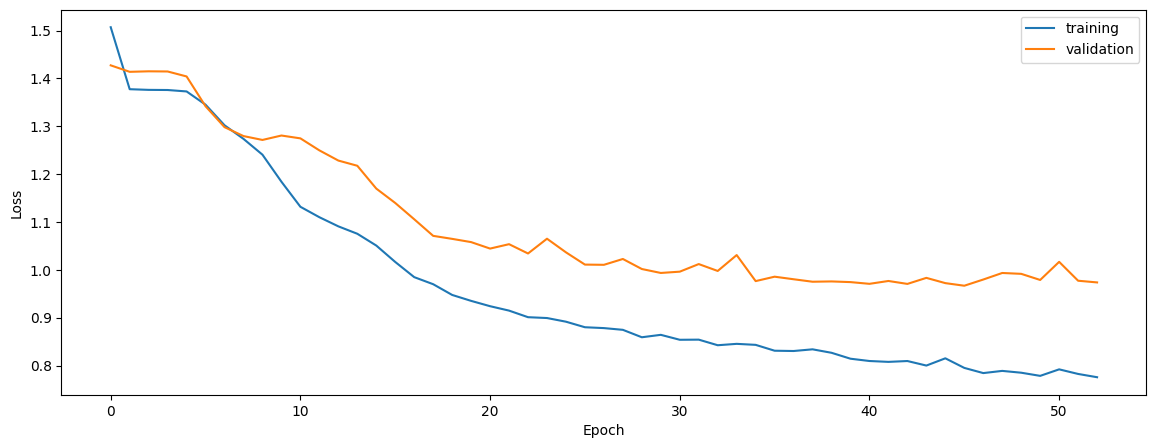

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuarcy, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getAccuarcy(train[1],train_pred))
print(getAccuarcy(val[1],val_pred))
print(getAccuarcy(test[1],test_pred))

train
0.6893882175226587
0.6261409914337874
0.694096661281637


In [8]:
props2 = props.copy()
props2['balance_data'] = False
props2['include_warp'] = True
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

train_pred2 = predictInBatches(model,train2[0],architecture['batch_size'])
val_pred2 = predictInBatches(model,val2[0],architecture['batch_size'])
test_pred2 = predictInBatches(model,test2[0],architecture['batch_size'])

print('normalized')
print(getAccuarcy(train2[1],train_pred2))
print(getAccuarcy(val2[1],val_pred2))
print(getAccuarcy(test2[1],test_pred2))

normalized
0.6893882175226587
0.6261409914337874
0.694096661281637


In [9]:
print('native')
print(getAccuarcy(train2[1][train2[2]],train_pred2[train2[2]]))
print(getAccuarcy(val2[1][val2[2]],val_pred2[val2[2]]))
print(getAccuarcy(test2[1][test2[2]],test_pred2[test2[2]]))

native
0.6979132109364253
0.6428359942605962
0.7071405816229008


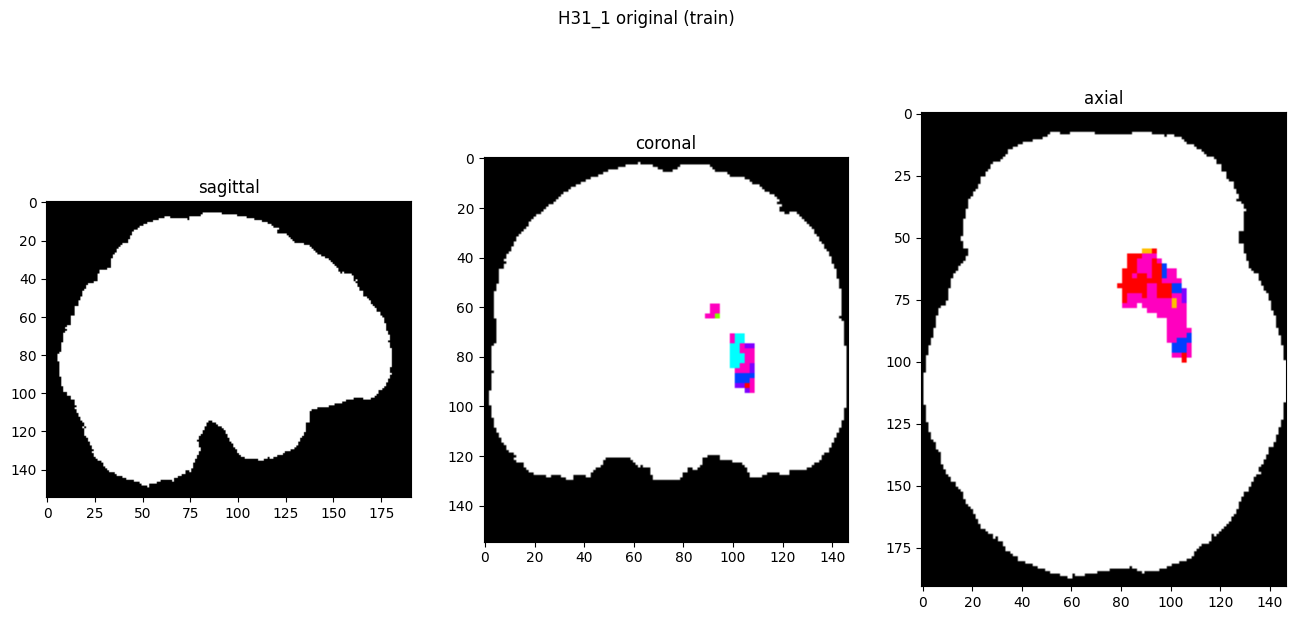

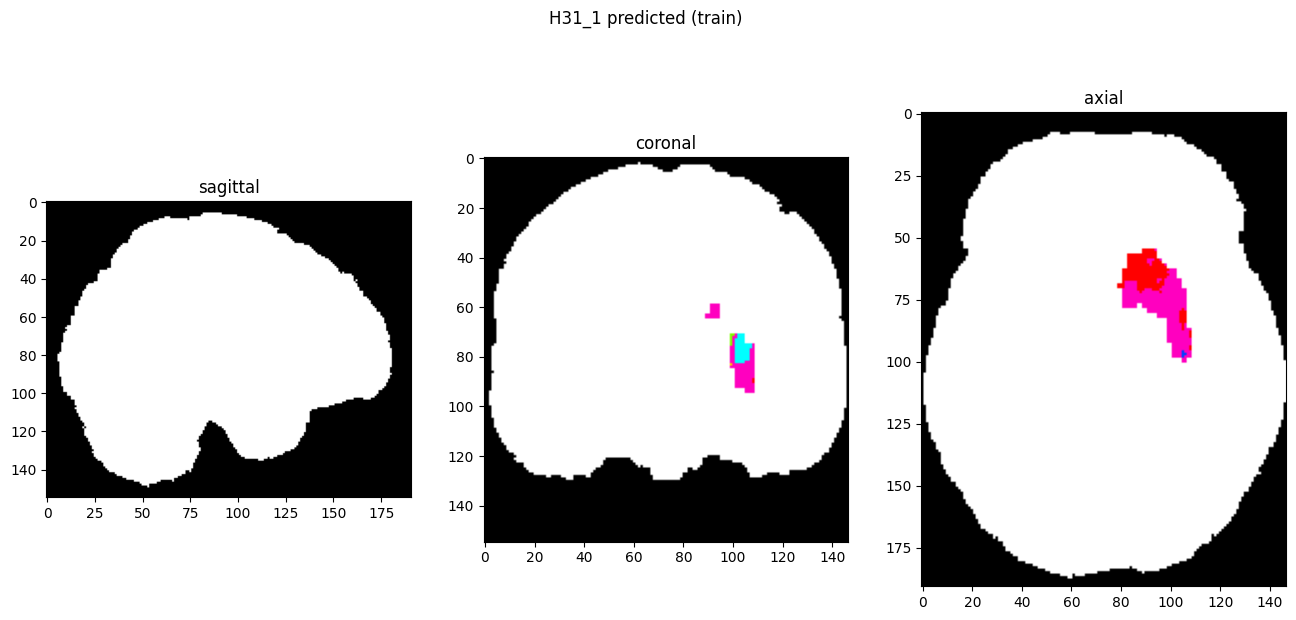

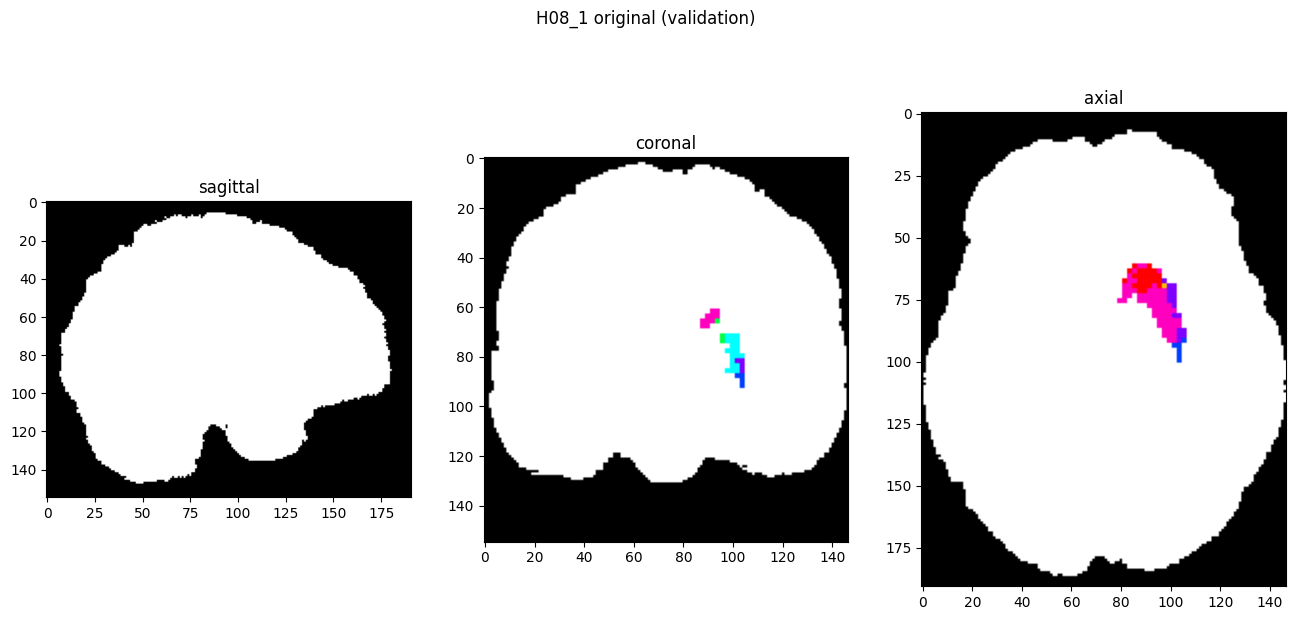

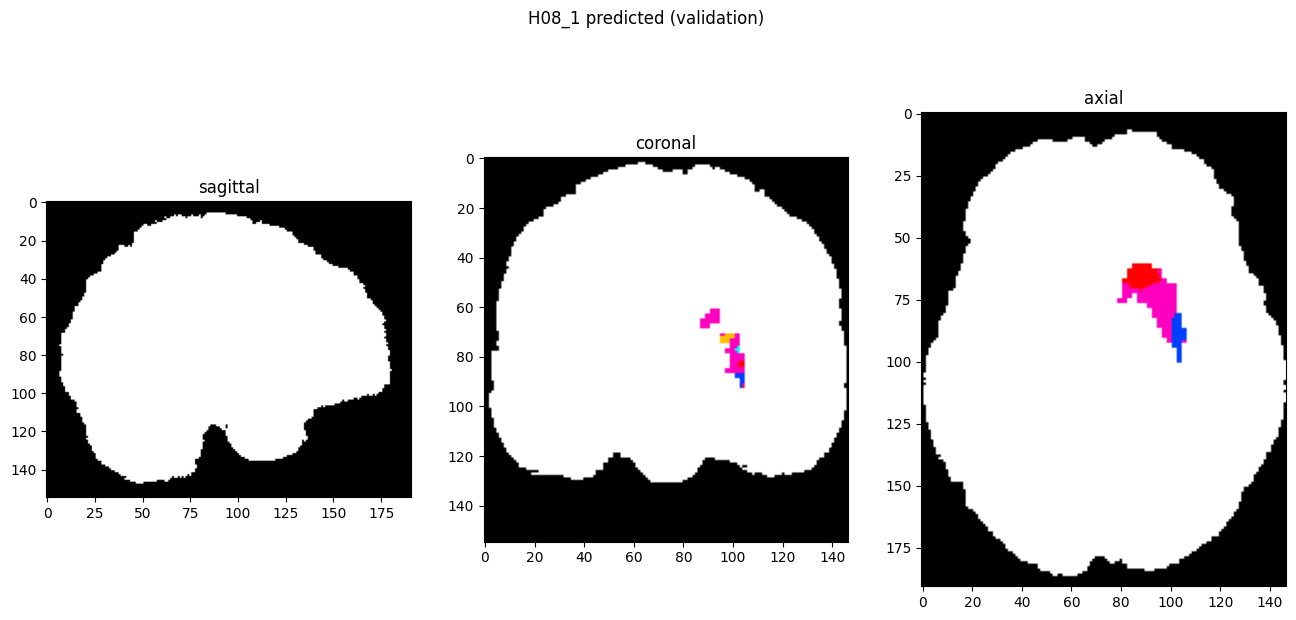

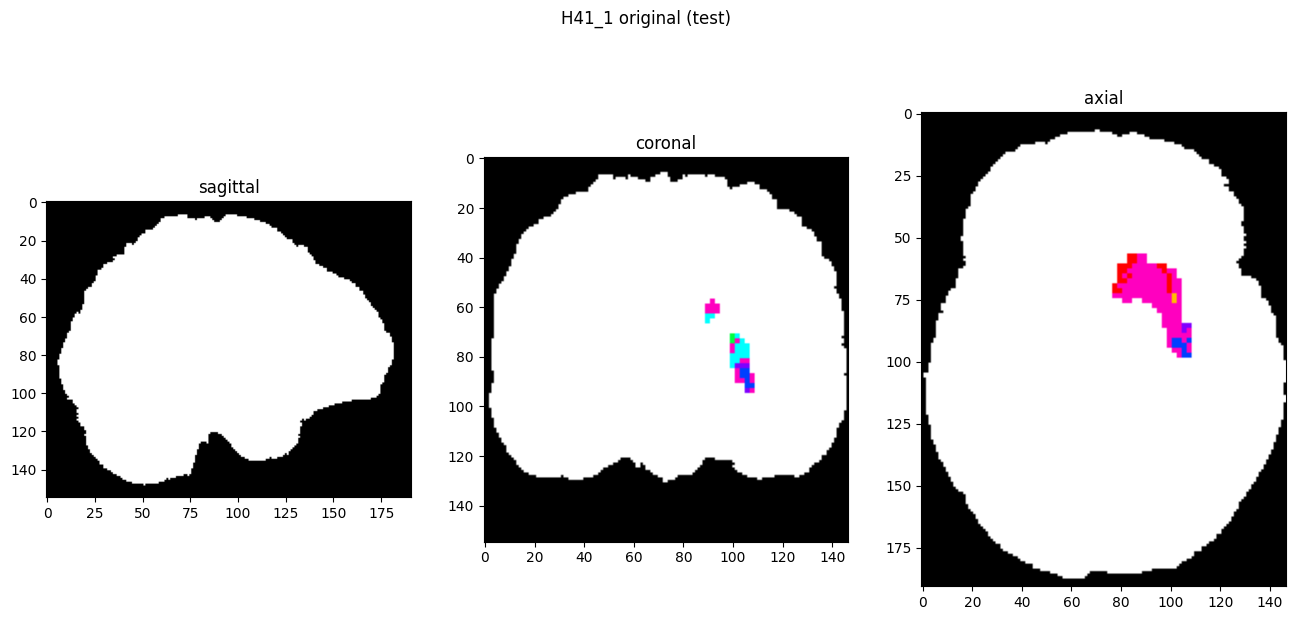

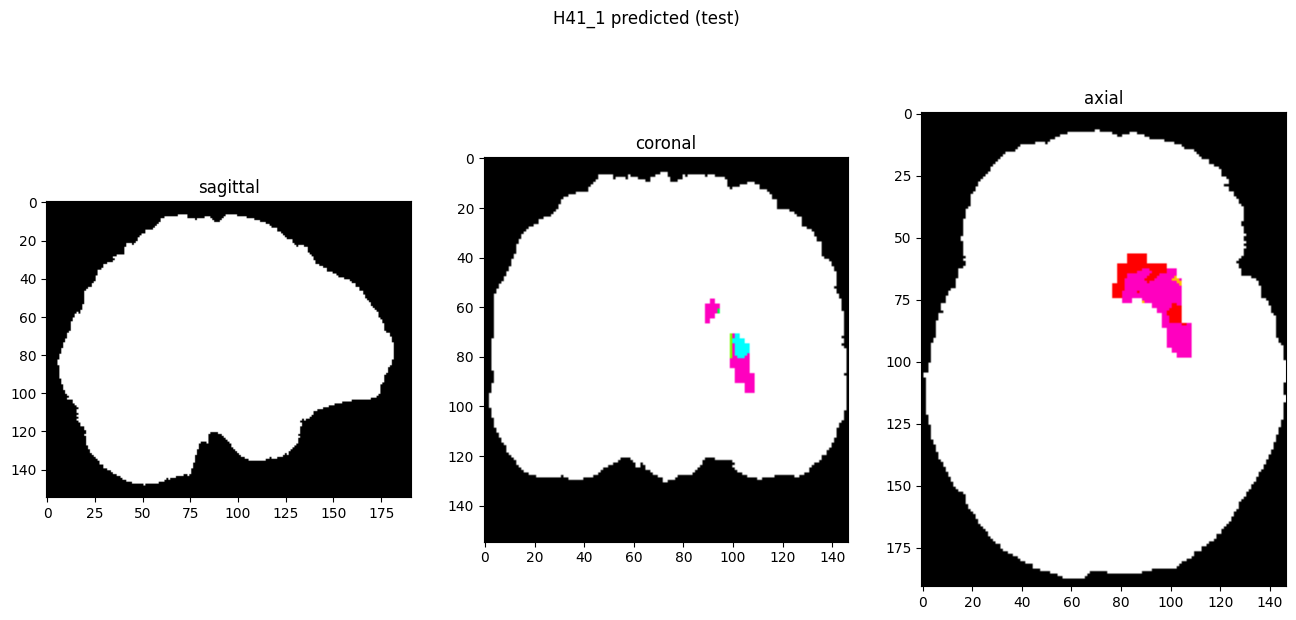

In [10]:
showResults(model, gen, threshold=0)